# 0.Introduction

## 0.1 Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import warnings
from sklearn import linear_model
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from sklearn.svm import SVR
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler,FunctionTransformer, PowerTransformer, QuantileTransformer, RobustScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import activations
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from IPython.display import display_html 
from re import VERBOSE
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from pyparsing.helpers import disable_diag
from scipy.stats.mstats import winsorize

warnings.filterwarnings("ignore", category= RuntimeWarning)
warnings.filterwarnings("ignore", category= FutureWarning)
set_config(display="diagram")

## 0.2 Variables

In [ ]:
#dataframe to save various results
results_mse = pd.DataFrame(columns=['modelName', 'train_mse', 'test_mse'])
results_mae = pd.DataFrame(columns=['modelName', 'train_mae', 'test_mae'])
results_r2score = pd.DataFrame(columns=['modelName', 'train_r2score', 'test_r2score'])
results_evs = pd.DataFrame(columns=['modelName', 'train_evs', 'test_evs'])

## 0.3 Functions

### -data preparation

In [ ]:
#checks missing data in %-tage in given dataset
def checkDataForNulls (dataset):
    percent_missing = dataset.isnull().sum() * 100 / len(dataset)
    missing_value_df = pd.DataFrame({'Column': dataset.columns,
                                 'percent_missing': percent_missing})
    print(missing_value_df)

In [ ]:
#show boxplot for dataset befroe modifications and after
def boxplot_compare_dist(df, y_before, y_after):
    f = plt.figure(figsize=(16,8))
    st = f.suptitle(f"{y_before} comparison", fontsize="x-large")
    ax1=plt.subplot(2,2,1)
    a = sns.distplot(df[y_before])
    plt.subplot(2,2,3)
    sns.boxplot(y=y_before, data = df)
    ax2=plt.subplot(2,2,2)
    b = sns.distplot(df [y_after])
    plt.subplot(2,2,4)
    sns.boxplot(y=y_after, data = df)
    a.title.set_text('before')
    b.title.set_text('after')
    plt.show()

In [ ]:
#transform specific column with requested tranfromer
def transform (transf, X_train, X_test, name, col):
  #train
  X_train_df = pd.DataFrame(X_train, columns = ['AT','V', 'AP', "RH"])
  X_train_df = X_train_df.drop(['AT','V'], axis=1)
  data_trans = transf.fit_transform(X_train_df) 
  data_trans_df = pd.DataFrame(data_trans, columns = ['AP', "RH"])

  #test
  X_test_df = pd.DataFrame(X_test, columns = ['AT','V', 'AP', "RH"])
  X_test_df = X_test_df.drop(['AT','V'], axis=1)
  data_trans_test = transf.transform(X_test_df)
  data_trans_test_df = pd.DataFrame(data_trans_test, columns = ['AP', "RH"])

  #show results
  compare_to_normal (X_train_df,data_trans_df, col, f'{name}_Train')
  compare_to_normal (X_test_df,data_trans_test_df, col, f'{name}_Test')
  return data_trans, data_trans_test

In [ ]:
#iterate over list of transformers and check specific column
def transform_list(X_train, X_test, col):
    rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
    sqr_transformer = FunctionTransformer(lambda x: x ** (1 / 2), validate = True)
    exp_transformer = FunctionTransformer(lambda x: x **( 1 * 1.2), validate = True)
    yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)
    bc_transformer = PowerTransformer(method = 'box-cox', standardize = False)
    transformer_list=[rcpr_transformer,sqr_transformer, exp_transformer, yj_transformer, bc_transformer ]
    transformer_names = ["rcpr_transformer","sqr_transformer", "exp_transformer", "yj_transformer", "bc_transformer" ]
    for j in range(0, len(transformer_list)):
         transform(transformer_list[j] ,X_train, X_test, transformer_names[j], col) 

In [ ]:
#plot specific column before modification and after modification in comparison to normal destribution
def compare_to_normal (df_before,df_after, col, name):
    f = plt.figure(figsize = (50, 10))
    st = f.suptitle(f"{col}_{name}", fontsize=30)
    plt.subplot(1, 4, 1)
    data = df_before[col]
    ax = sns.histplot(x=data, stat="density")
    mean = data.mean()
    std = data.std()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, color="black", linewidth=2)
    plt.xlabel(f'{col} before transformation', fontsize=20)
    plt.subplot(1, 4, 2)
    stats.probplot(df_before[col], dist = 'norm', plot = plt)
    plt.xlabel(f'{col} before transformation', fontsize=20)
    plt.subplot(1, 4, 3)
    data = df_after[col]
    ax = sns.histplot(x=data, stat="density")
    mean = data.mean()
    std = data.std()
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    plt.plot(x, p, color="black", linewidth=2)
    plt.xlabel(f'{col} after transformation', fontsize=20)
    plt.subplot(1, 4, 4)
    stats.probplot(df_after[col], dist = 'norm', plot = plt)
    plt.xlabel(f'{col} after transformation', fontsize=20)
    plt.show()

In [ ]:
#split and impute dataset
def reset_t_t_split(df, imputer):
  X = df.iloc[:, :-1].values
  y= df.iloc[:, -1].values
  #split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
  #impute
  X_train_i = imputer.fit_transform(X_train)
  X_test_i = imputer.transform(X_test)
  return X_train_i, X_test_i, y_train, y_test

In [ ]:
# scale only
def scale (scaler, X_train_i, X_test_i, y_train, y_test ):
  #scale
  sc_x=scaler
  sc_y=scaler
  y_train_r = y_train.reshape(len(y_train), 1)
  y_test_r = y_test.reshape(len(y_test), 1)
  X_train_sc = sc_x.fit_transform(X_train_i)
  X_test_sc = sc_x.transform(X_test_i)
  y_train_sc = sc_y.fit_transform(y_train_r)
  y_test_sc = sc_y.transform(y_test_r)
  
  return  X_train_sc, X_test_sc, y_train_sc, y_test_sc, sc_y, y_test, y_train

### -model training

In [ ]:
#split dataset and preprocess data according to given pipeline
def split_impute_scale_pipe (df, pipe, imputer, winsorize_rh = False,winsorize_ap = False):
  pipe_s = define_pipeline_simple(RobustScaler())
  X = df.iloc[:, :-1].values
  y= df.iloc[:, -1].values
  #split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

  y_test_orig, y_train_orig = y_test, y_train

  X_train_i = imputer.fit_transform(X_train)
  X_test_i = imputer.transform(X_test)

  cols = ['AT', 'V', 'AP', 'RH']
  if winsorize_rh:
    X_train_i = winsorize_nparray(X_train_i, 3,  0.00135, 0)
    X_test_i = winsorize_nparray(X_test_i, 3,  0.00135, 0)
    
  if winsorize_ap:
    X_train_i= winsorize_nparray(X_train_i, 2,  0.00165, 0.015)
    X_test_i= winsorize_nparray(X_test_i, 2,  0.00165, 0.015)
    cols = ['AT', 'V', 'RH', 'AP']

  X_train_i = pd.DataFrame(X_train_i, columns = cols)
  X_test_i = pd.DataFrame(X_test_i, columns = cols)

  X_train_p = pipe.fit_transform(X_train_i)
  X_test_p = pipe.transform(X_test_i)

  pipe 

  y_train_r = y_train.reshape(len(y_train), 1)
  y_test_r = y_test.reshape(len(y_test), 1)
  y_train_p = pipe_s.fit_transform(y_train_r)
  y_test_p = pipe_s.transform(y_test_r)

  return X_train_p, X_test_p, y_train_p, y_test_p, pipe_s,  y_test_orig, y_train_orig

In [ ]:
#define pipeline with scaler only
def define_pipeline_simple(scaler):
  pipe_simple = Pipeline([
    ('scaler', scaler)
    ])
  return pipe_simple

In [ ]:
#define pipeline with transformer and scaler:

def define_pipeline_complex(scaler, rh_step, ap_step, is_rh = True, is_ap = True ):
  if is_rh:
    rh_pipe = Pipeline([('transformer_step', rh_step),
                        ('scaler', scaler)])
  else:
    rh_pipe = Pipeline([('scaler', scaler)])
  
  if is_ap:
    ap_pipe = Pipeline([('preprocess_step', ap_step),
                        ('scaler', scaler)])
  else:
    ap_pipe =  Pipeline([('scaler', scaler)])

  simple_pipe = define_pipeline_simple(RobustScaler())                        
  pipe = ColumnTransformer(
    [("RH_col"  , rh_pipe  , ["RH"]),
     ("AP_col", ap_pipe, ["AP"])
    ],
    remainder = simple_pipe
  )
  set_config(display="diagram")

  return pipe

In [ ]:
# treat outliers with winsorize method
def winsorize_nparray(nparray, col_index, lower, upper):
  array_col =  nparray[ : , col_index]
  array_col_win = winsorize(array_col, (lower, upper))
  array_col_win_reshape = array_col_win.reshape(len(array_col_win), 1)
  combo = np.delete(nparray, col_index, 1)
  nparray = np.c_[combo, array_col_win_reshape]
  return nparray

#### -ML model training

In [ ]:
#train ML model, evaluate, save to results dataframe
def train_report_hist_pipe (name,regressor, pipe):
    model = regressor
    model.fit(X_train, y_train)
    results = pd.DataFrame(columns=['modelName', 'mse', 'mae',  'evs', 'r2'])


    r_sq = model.score(X_train, y_train)
    print(f"coefficient of determination: {r_sq}")

    y_pred_train = pipe.inverse_transform(model.predict(X_train).reshape(-1,1))

    r2_score_train =  r2_score(y_train_orig, y_pred_train)
    evs_train = explained_variance_score(y_train_orig, y_pred_train)
    mae_train =  mean_absolute_error(y_train_orig, y_pred_train)
    mse_train = mean_squared_error(y_train_orig, y_pred_train)

    y_pred_test = pipe.inverse_transform(model.predict(X_test).reshape(-1,1))
  
    r2_score_test =  r2_score(y_test_orig, y_pred_test)
    evs_test = explained_variance_score(y_test_orig, y_pred_test)
    mae_test =  mean_absolute_error(y_test_orig, y_pred_test)
    mse_test = mean_squared_error(y_test_orig, y_pred_test)

    results_r2score.loc[len(results_r2score.index)] = [name, round( r2_score_train*100,3), round( r2_score_test*100,3)]
    results_evs.loc[len(results_evs.index)] = [name, round( evs_train*100,3), round( evs_test*100,3)]
    results_mae.loc[len(results_mae.index)] = [name, round( mae_train,3), round( mae_test,3)]
    results_mse.loc[len(results_mse.index)] = [name, round( mse_train,3), round( mse_test,3)]

    results.loc[len(results.index)] = [f'{name}_train', round( mse_train,3), round( mae_train,3),round( evs_train*100,3),round( r2_score_train*100,3) ]
    results.loc[len(results.index)] = [f'{name}_test', round( mse_test,3), round( mae_test,3),round( evs_test*100,3),round( r2_score_test*100,3) ]

    print (results)

#### -ANN model training

tbd in part 2 of current project

### -show results

In [ ]:
# print tables with results and graphs
def show_results():
    new_results_mse = results_mse.sort_values('test_mse', ascending=True)
    new_results_mae = results_mae.sort_values('test_mae', ascending=True)
    new_results_r2score = results_r2score.sort_values('test_r2score', ascending=False)
    new_results_evs = results_evs.sort_values('test_evs', ascending=False)

    df1_styler = new_results_mse.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('MSE')
    df2_styler = new_results_mae.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('MAE')
    df3_styler = new_results_r2score.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('r2score')
    df4_styler = new_results_evs.style.set_table_attributes('border="1" class="dataframe table table-hover table-bordered" style="display:inline"').set_precision(3).set_caption('EVS')
    
    display_html(df1_styler._repr_html_()+"____\n"+df2_styler._repr_html_()+"____"+df3_styler._repr_html_()+"____"+df4_styler._repr_html_(), raw=True)

    m_mse = new_results_mse['modelName'].to_list()
    tr_mse = new_results_mse['train_mse'].to_list()
    te_mse = new_results_mse['test_mse'].to_list()

    m_mae = new_results_mae['modelName'].to_list()
    tr_mae = new_results_mae['train_mae'].to_list()
    te_mae = new_results_mae['test_mae'].to_list()

    m_r2score = new_results_r2score['modelName'].to_list()
    tr_r2score = new_results_r2score['train_r2score'].to_list()
    te_r2score = new_results_r2score['test_r2score'].to_list()

    m_evs = new_results_evs['modelName'].to_list()
    tr_evs = new_results_evs['train_evs'].to_list()
    te_evs = new_results_evs['test_evs'].to_list()

    f = plt.figure(figsize=(40,15))
    st = f.suptitle('Results', fontsize="x-large")

    plt.subplot(2,2,1)  
    X_axis = np.arange(len(m_mse))  
    plt.bar(X_axis - 0.2, tr_mse, 0.4, label = 'train_mse')
    plt.bar(X_axis + 0.2, te_mse, 0.4, label = 'test_mse')
  
    plt.xticks(X_axis, m_mse, rotation=90)
    plt.xlabel("models")
    plt.ylabel("mse")
    plt.title("Train mse and test mse")
    plt.legend()

    plt.subplot(2,2,2) 
    X_axis = np.arange(len(m_mae))
    plt.bar(X_axis - 0.2, tr_mae, 0.4, label = 'train_mae')
    plt.bar(X_axis + 0.2, te_mae, 0.4, label = 'test_mae')
  
    plt.xticks(X_axis, m_mae, rotation=90)
    plt.xlabel("models")
    plt.ylabel("mae")
    plt.title("train mae vs test mae")
    plt.legend()

    plt.subplot(2,2,3) 
    X_axis = np.arange(len(m_r2score))
    plt.bar(X_axis - 0.2, tr_r2score, 0.4, label = 'train_r2score')
    plt.bar(X_axis + 0.2, te_r2score, 0.4, label = 'test_r2score')
  
    plt.xticks(X_axis, m_r2score, rotation=90)
    plt.xlabel("models")
    plt.ylabel("r2score")
    plt.title("train r2score vs test r2score")
    plt.legend()

    plt.subplot(2,2,4) 
    X_axis = np.arange(len(m_evs))
    plt.bar(X_axis - 0.2, tr_evs, 0.4, label = 'train_evs')
    plt.bar(X_axis + 0.2, te_evs, 0.4, label = 'test_evs')
  
    plt.xticks(X_axis, m_evs, rotation=90)
    plt.xlabel("models")
    plt.ylabel("evs")
    plt.title("train evs vs test evs")
    plt.legend()

    plt.show()

# 1.Data Preparation

### 1.1 Data Exploration

In [ ]:
pp_dataset = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Folds5x2_pp_TP.xlsx")
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Folds5x2_pp_TP.xlsx")

In [ ]:
pp_dataset.describe()

AT            V           AP           RH           PE
count  9525.000000  9533.000000  9503.000000  9510.000000  9568.000000
mean     19.641594    54.311154  1013.250053    73.291181   454.365009
std       7.454601    12.705674     5.934166    14.593837    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.090000    63.320000   439.750000
50%      20.320000    52.080000  1012.930000    74.955000   451.550000
75%      25.720000    66.540000  1017.250000    84.810000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000

In [ ]:
pp_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9525 non-null   float64
 1   V       9533 non-null   float64
 2   AP      9503 non-null   float64
 3   RH      9510 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


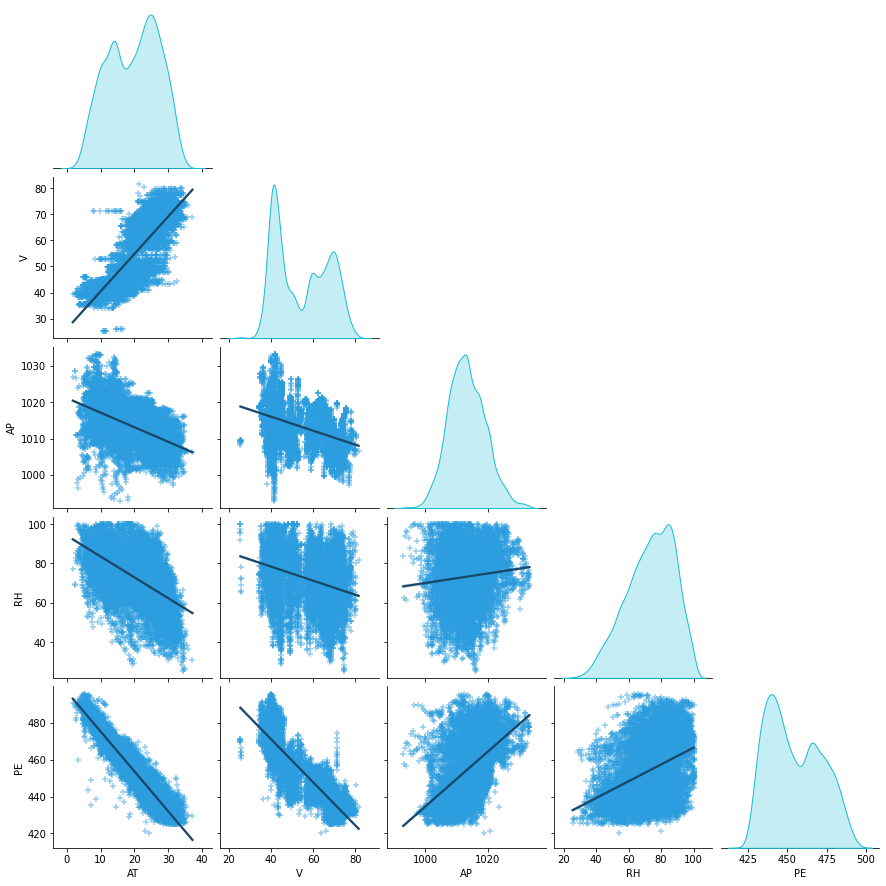

In [ ]:
sns.pairplot(pp_dataset,
                 markers="+",
                 kind='reg',
                 diag_kind="kde",
                 plot_kws={'line_kws':{'color':'#184769'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#2C9DDE'}},
               corner=True,
                 diag_kws= {'color': '#19BBD5'})
plt.savefig('save_as_a_png2.png',transparent=True)

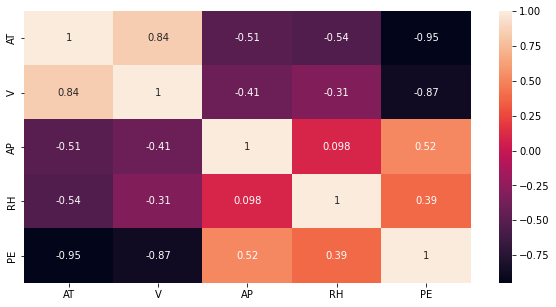

In [ ]:
# Compute correlation between the variables
corr = pp_dataset.corr()


plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True)
plt.savefig('save_as_a_png3.png',transparent=True)
plt.show()

In [ ]:
checkDataForNulls(pp_dataset)

   Column  percent_missing
AT     AT         0.449415
V       V         0.365803
AP     AP         0.679348
RH     RH         0.606187
PE     PE         0.000000


In [ ]:
from datetime import datetime, timedelta
t_list = []
start_date = datetime(2006, 1, 1, 00, 00)
for i in range(0,len(pp_dataset)):
  t_list.append(start_date)
  start_date += timedelta(hours=1)


In [ ]:
df['art_timestamp'] = t_list

In [ ]:
#added date_time to dataset to check possibility of time series
df

AT      V       AP     RH      PE       art_timestamp
0     14.96  41.76  1024.07  73.17  463.26 2006-01-01 00:00:00
1     25.18  62.96  1020.04  59.08  444.37 2006-01-01 01:00:00
2      5.11  39.40  1012.16  92.14  488.56 2006-01-01 02:00:00
3     20.86  57.32  1010.24  76.64  446.48 2006-01-01 03:00:00
4     10.82  37.50  1009.23  96.62  473.90 2006-01-01 04:00:00
...     ...    ...      ...    ...     ...                 ...
9563  16.65  49.69  1014.01  91.00  460.03 2007-02-03 11:00:00
9564  13.19  39.18  1023.67  66.78  469.62 2007-02-03 12:00:00
9565  31.32  74.33  1012.92  36.48  429.57 2007-02-03 13:00:00
9566  24.48  69.45  1013.86  62.39  435.74 2007-02-03 14:00:00
9567  21.60  62.52  1017.23  67.87  453.28 2007-02-03 15:00:00

[9568 rows x 6 columns]

As our dataset is in time between 2006-2011 it can be clearly seen that data was gathered not hourly over all 6 years.

________________________________________________________________________________________________________________


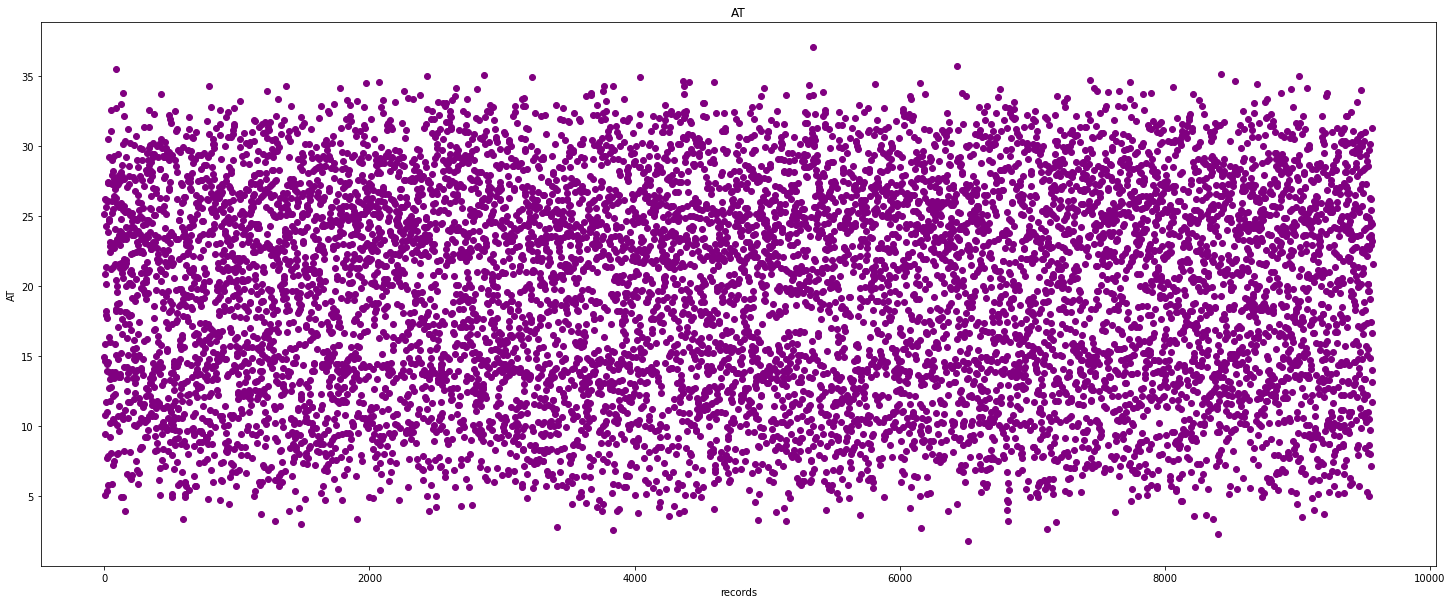

________________________________________________________________________________________________________________


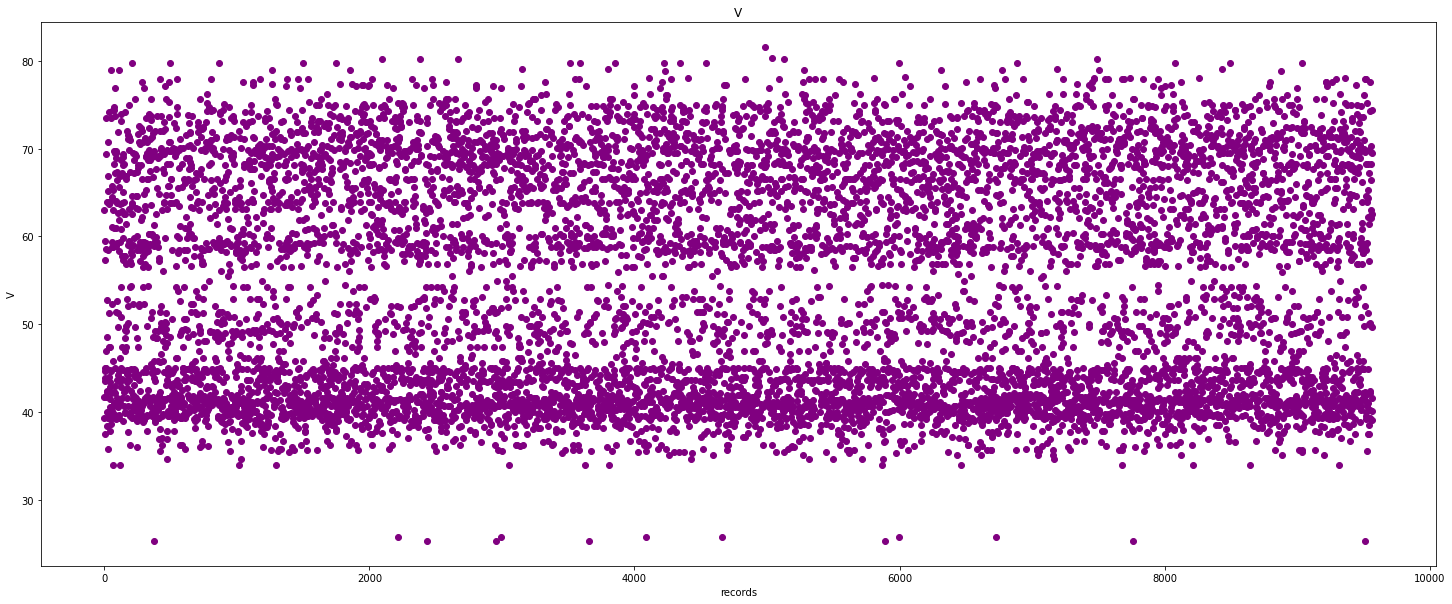

________________________________________________________________________________________________________________


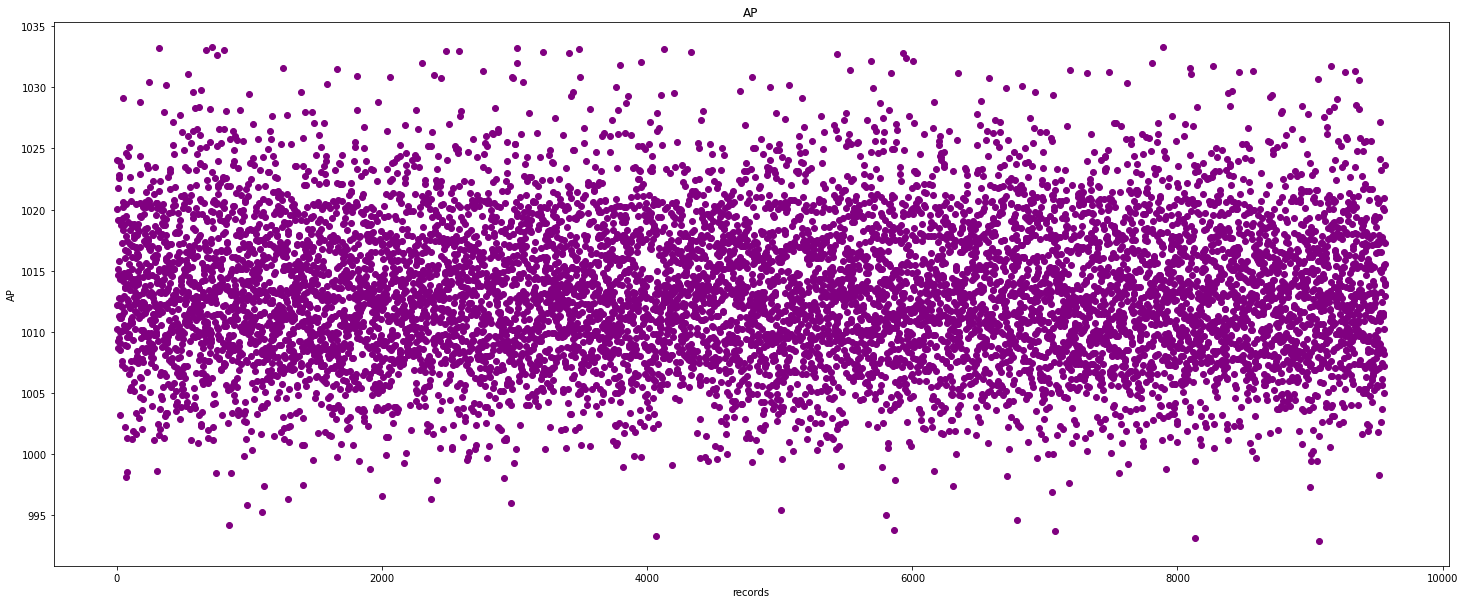

________________________________________________________________________________________________________________


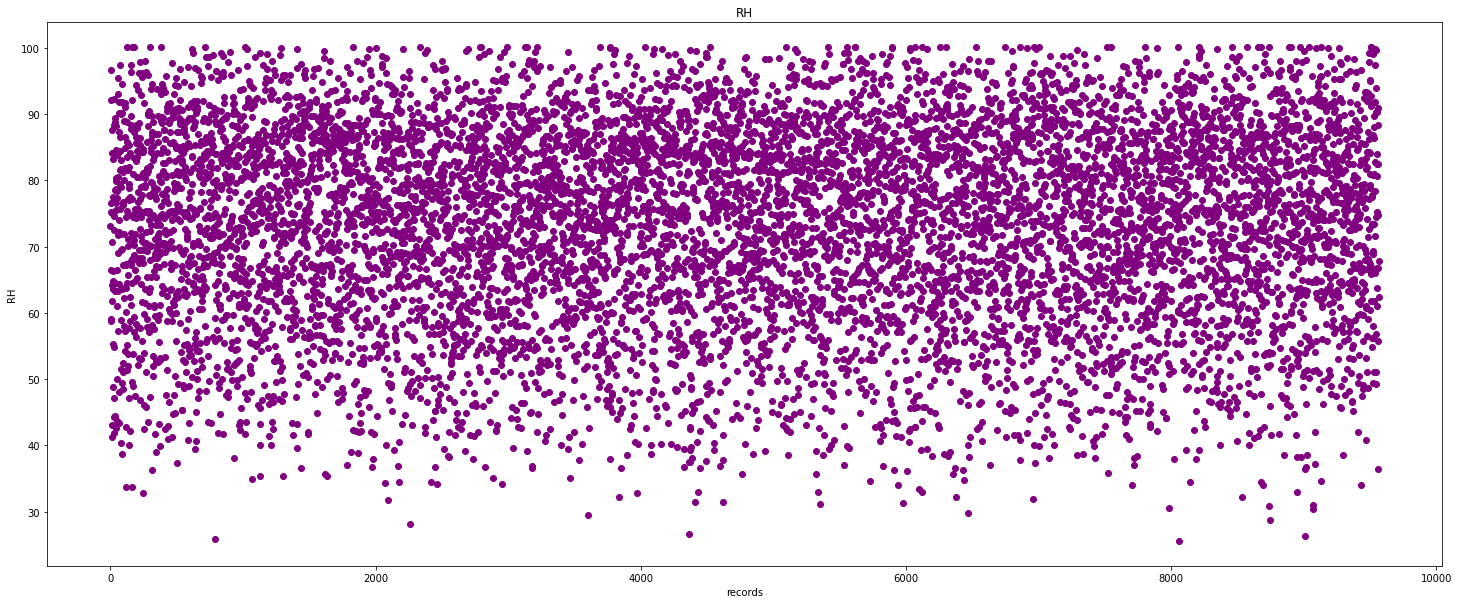

________________________________________________________________________________________________________________


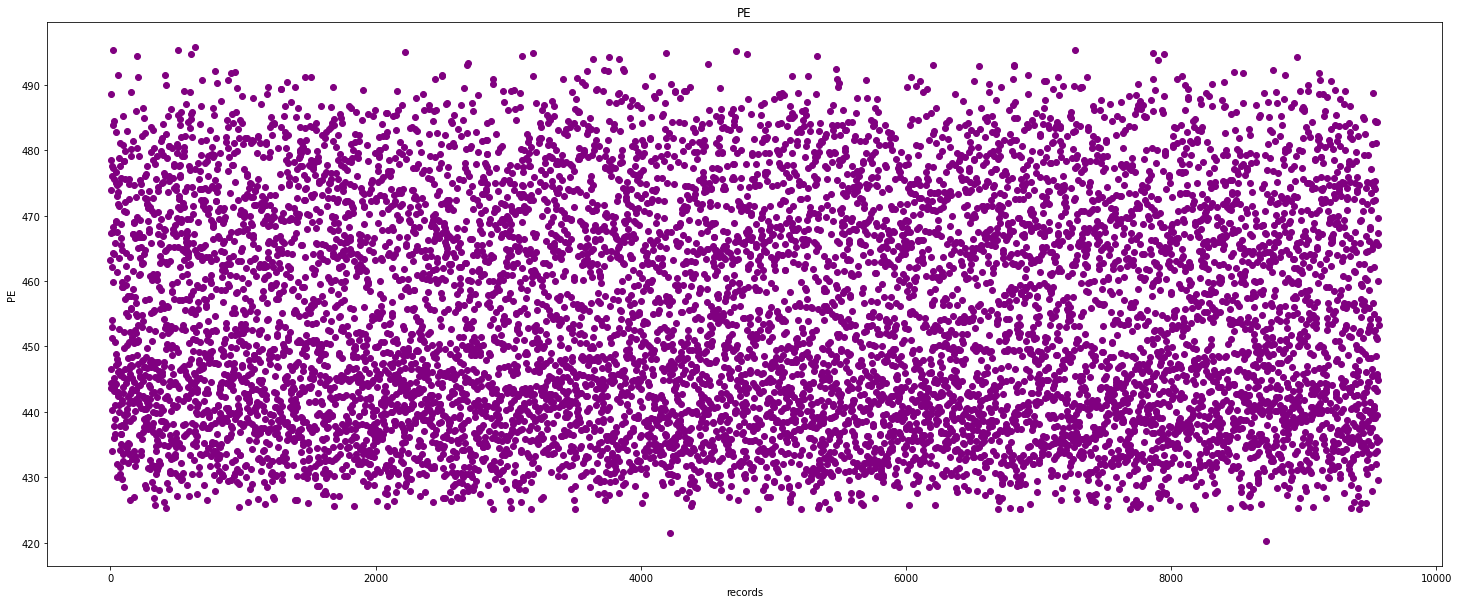

In [ ]:
#check if there is any trends of data chenign over time per each variable
# Create figure and plot space
for col in pp_dataset.columns:
  print("________________________________________________________________________________________________________________")
  fig, ax = plt.subplots(figsize=(25, 10))

  # Add x-axis and y-axis
  ax.scatter(df.index.values,
             df[col],
            color='purple')

  # Set title and labels for axes
  ax.set(xlabel="records",
       ylabel=col,
       title=col)

  plt.show()

No clear pattern can be detected and data preprocessing methods for timeseries data can`t be applied

### 1.2 Data Transformation

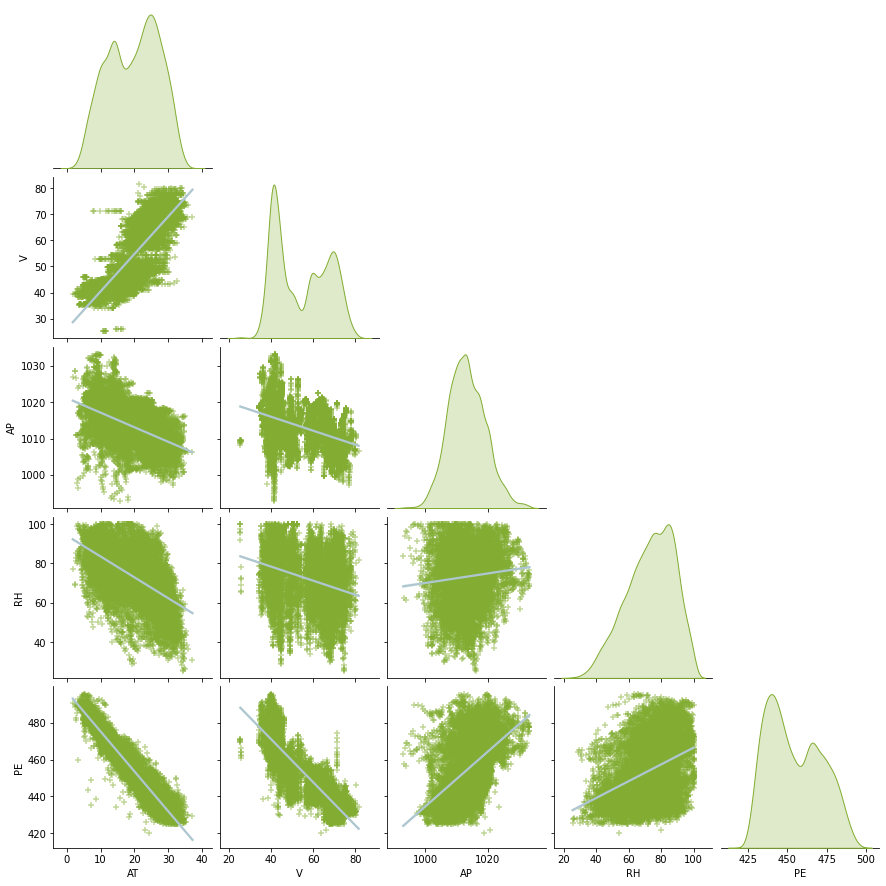

In [ ]:
#what we have
sns.pairplot(pp_dataset,
                 markers="+",
                 kind='reg',
                 diag_kind="kde",
                 plot_kws={'line_kws':{'color':'#aec6cf'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#82ad32'}},
               corner=True,
                 diag_kws= {'color': '#82ad32'})

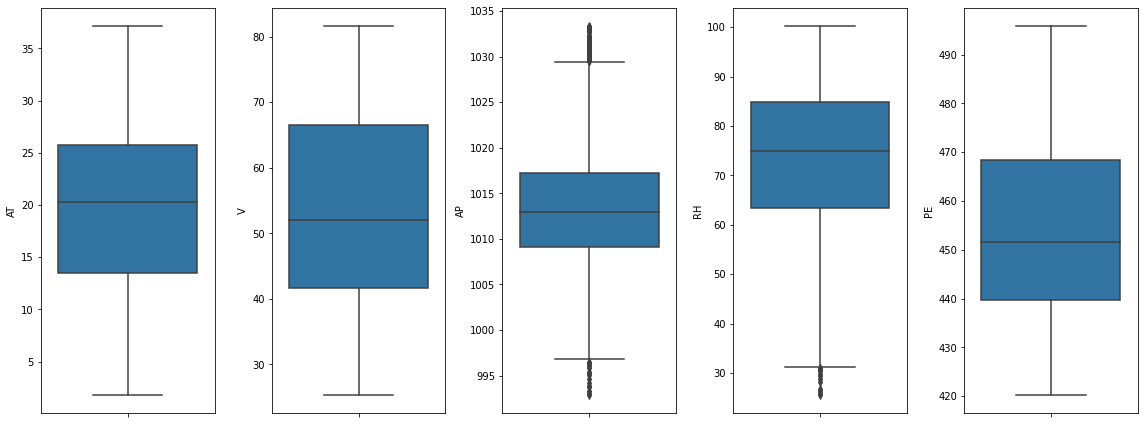

In [ ]:
#check outliers
X = pp_dataset.copy()
features = X.columns.tolist()

plt.figure(figsize=(16,6))

for i,col in enumerate(features):    
    plt.subplot(1,5,i + 1)
    sns.boxplot(y=col, data=pp_dataset)
    #plt.ylabel('')

plt.tight_layout()

plt.show()

- In the first graphic above it can be seen that variables 'AP' and 'RH' can be normalized. Also correlation of output variable to 'AT' and to 'V' tends towards linear.
- In the second graphic it can be seen that variables 'AP' and 'RH' have outliers that can be treated.

#### -outliers

Winsorize method

The (limits[0])th lowest values are set to the (limits[0])th percentile, and the (limits[1])th highest values are set to the (1 - limits[1])th percentile. Masked values are skipped.

[scipy official source](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html)

In [ ]:
#treat outliers with winsorize method
X_train, X_test, y_train, y_test = reset_t_t_split(pp_dataset_normalised, KNNImputer(n_neighbors=2))
X_train_df = pd.DataFrame(X_train, columns = ['AT','V','AP', 'RH'])
#transfrom 'AP' column
pp_dataset_AP = X_train_df['AP']
pp_dataset_AP_win = winsorize(pp_dataset_AP, (0.00165, 0.015))
pp_dataset_AP_win= pd.DataFrame(pp_dataset_AP_win)
pp_dataset_AP_win = pp_dataset_AP_win.rename(columns = {0: 'new_AP'})
#transfrom "RH" column
pp_dataset_RH = X_train_df['RH']
pp_dataset_RH_win = winsorize(pp_dataset_RH, (0.00135, 0))
pp_dataset_RH_win= pd.DataFrame(pp_dataset_RH_win)
pp_dataset_RH_win = pp_dataset_RH_win.rename(columns = {0: 'new_RH'})

In [ ]:
#join transfromed columns 'RH' and 'AP' with not normalized columns
df_outliers = X_train_df[['RH', 'AP']].copy()
extracted_col = pp_dataset_RH_win["new_RH"]
df_outliers = df_outliers.join(extracted_col)
extracted_col_2 = pp_dataset_AP_win["new_AP"]
df_outliers = df_outliers.join(extracted_col_2)

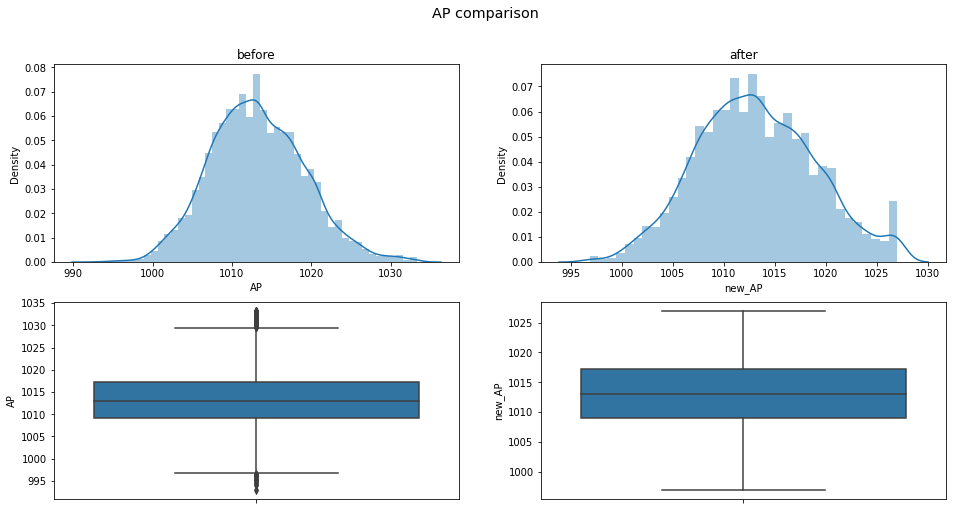

In [ ]:
#compare results for column 'AP'
boxplot_compare_dist(df_outliers,"AP", "new_AP")

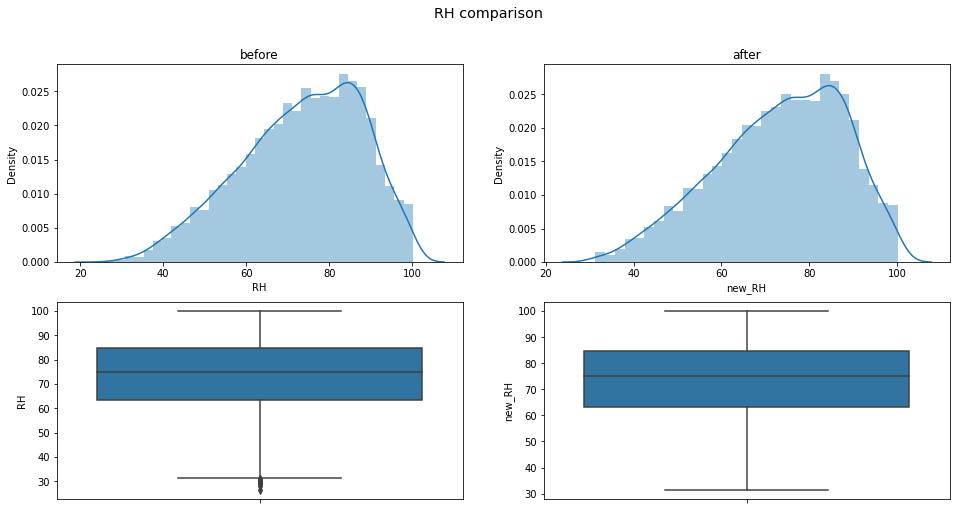

In [ ]:
#compare results for column 'RH'
boxplot_compare_dist(df_outliers,"RH", "new_RH")

In graphics it can be seen that in case of 'RH' variable after outliers treatment there were no drastic changes, but in case of 'AT' variable in lower limmit after treatment there is increase in density. 
Both variables treatment will be checked on base model later on.

#### -normalization

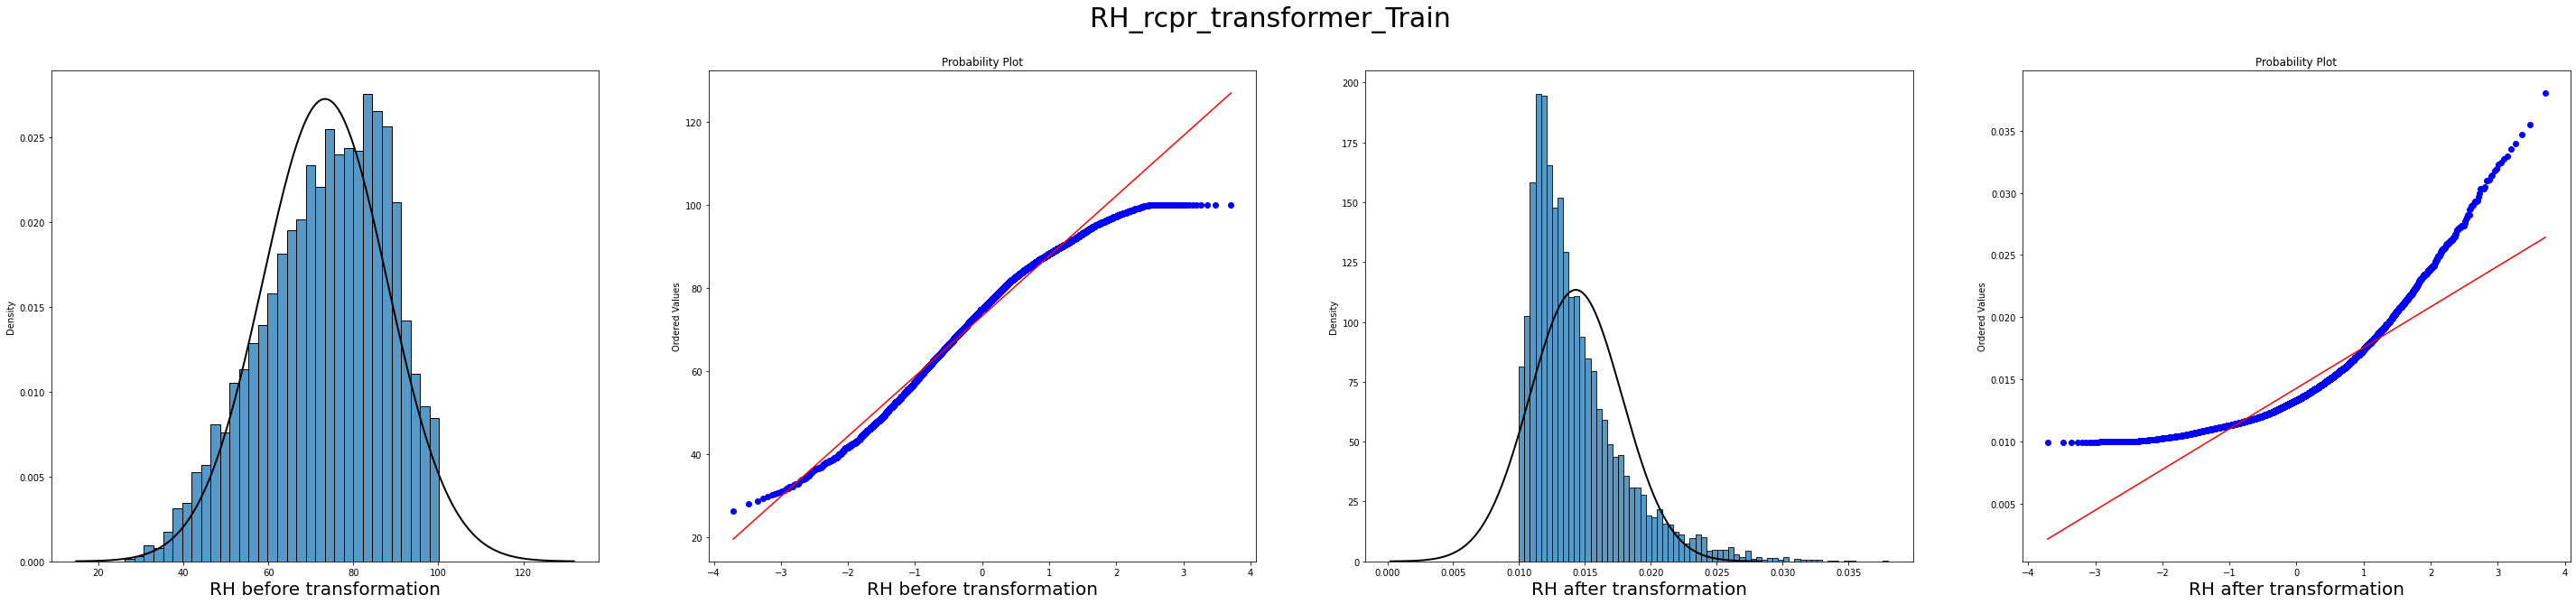

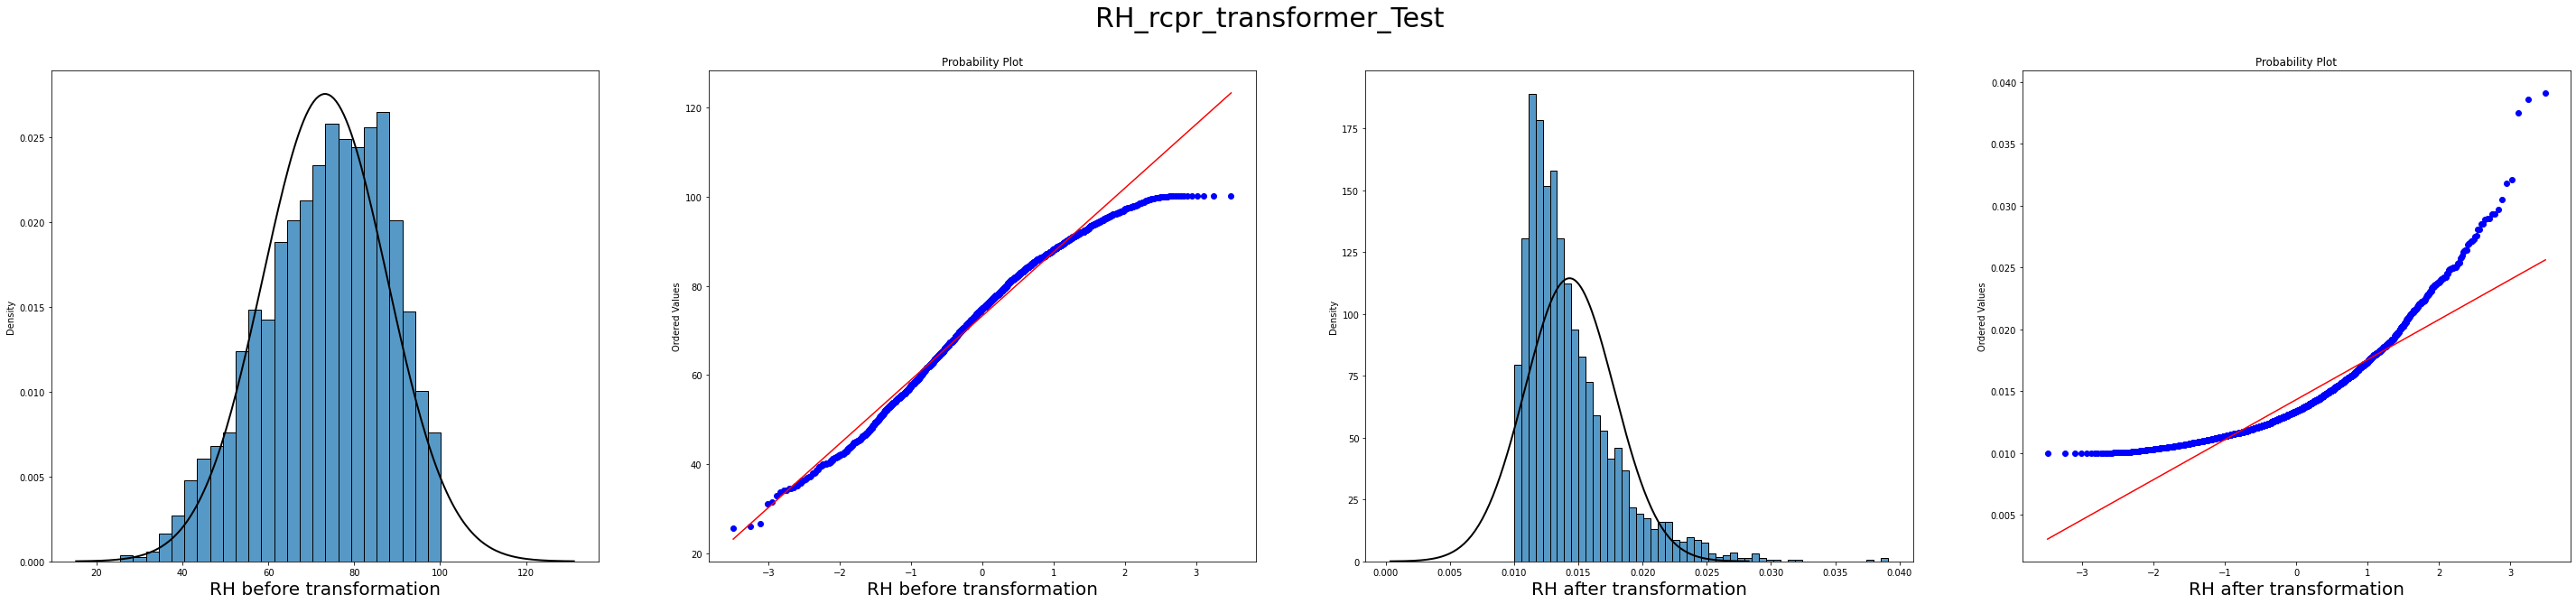

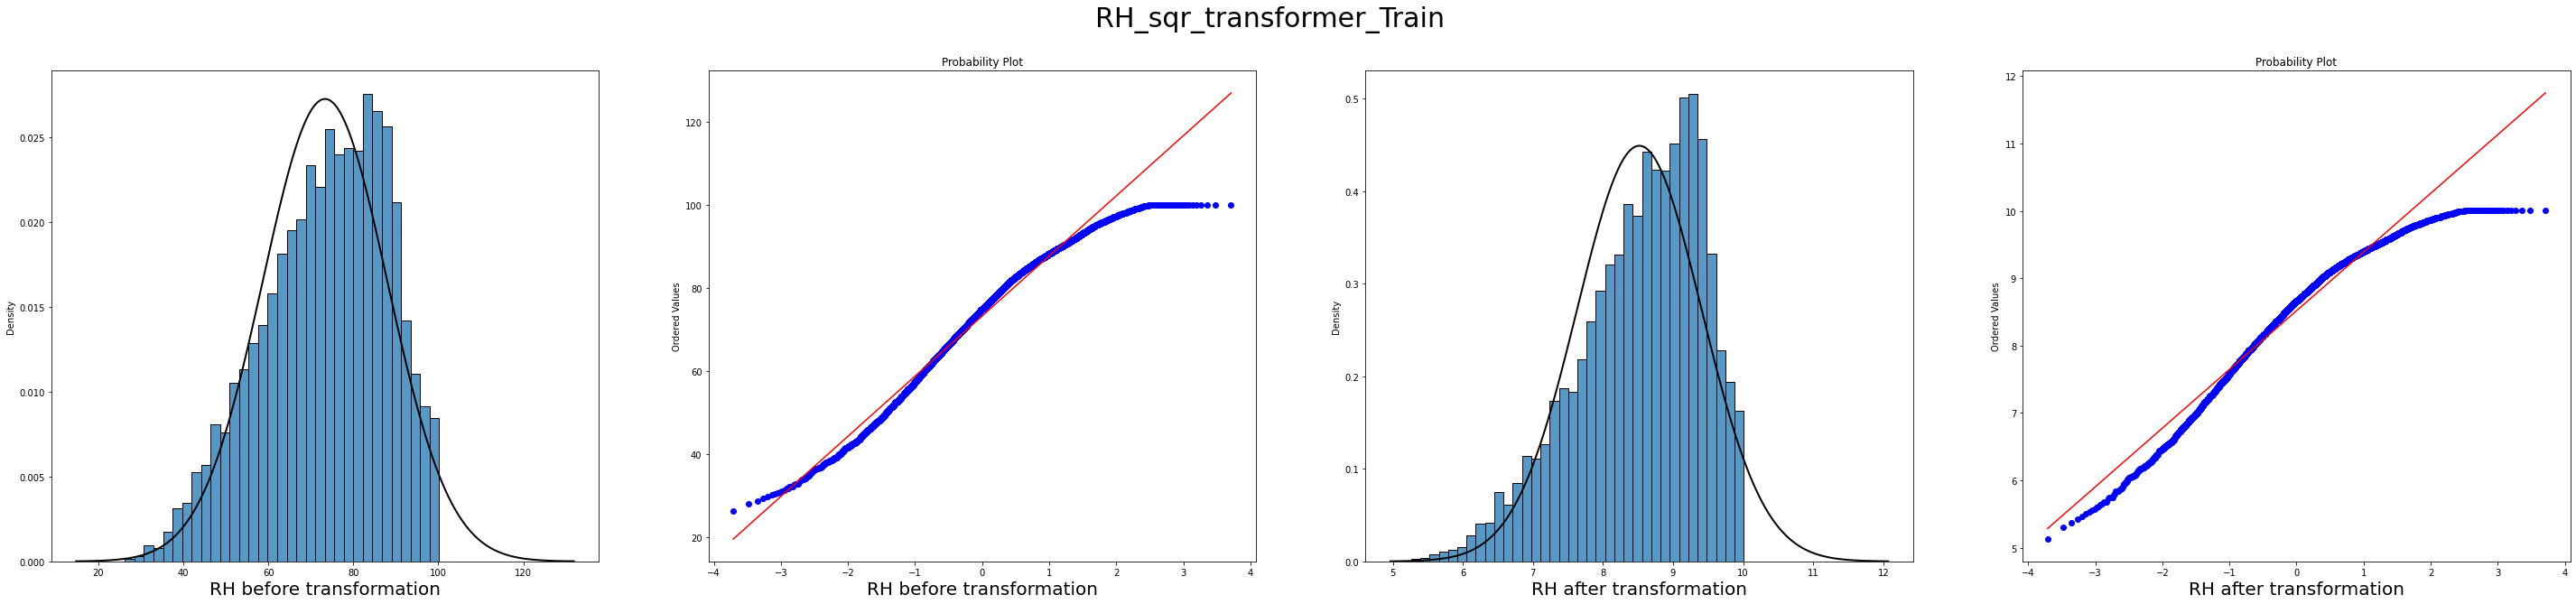

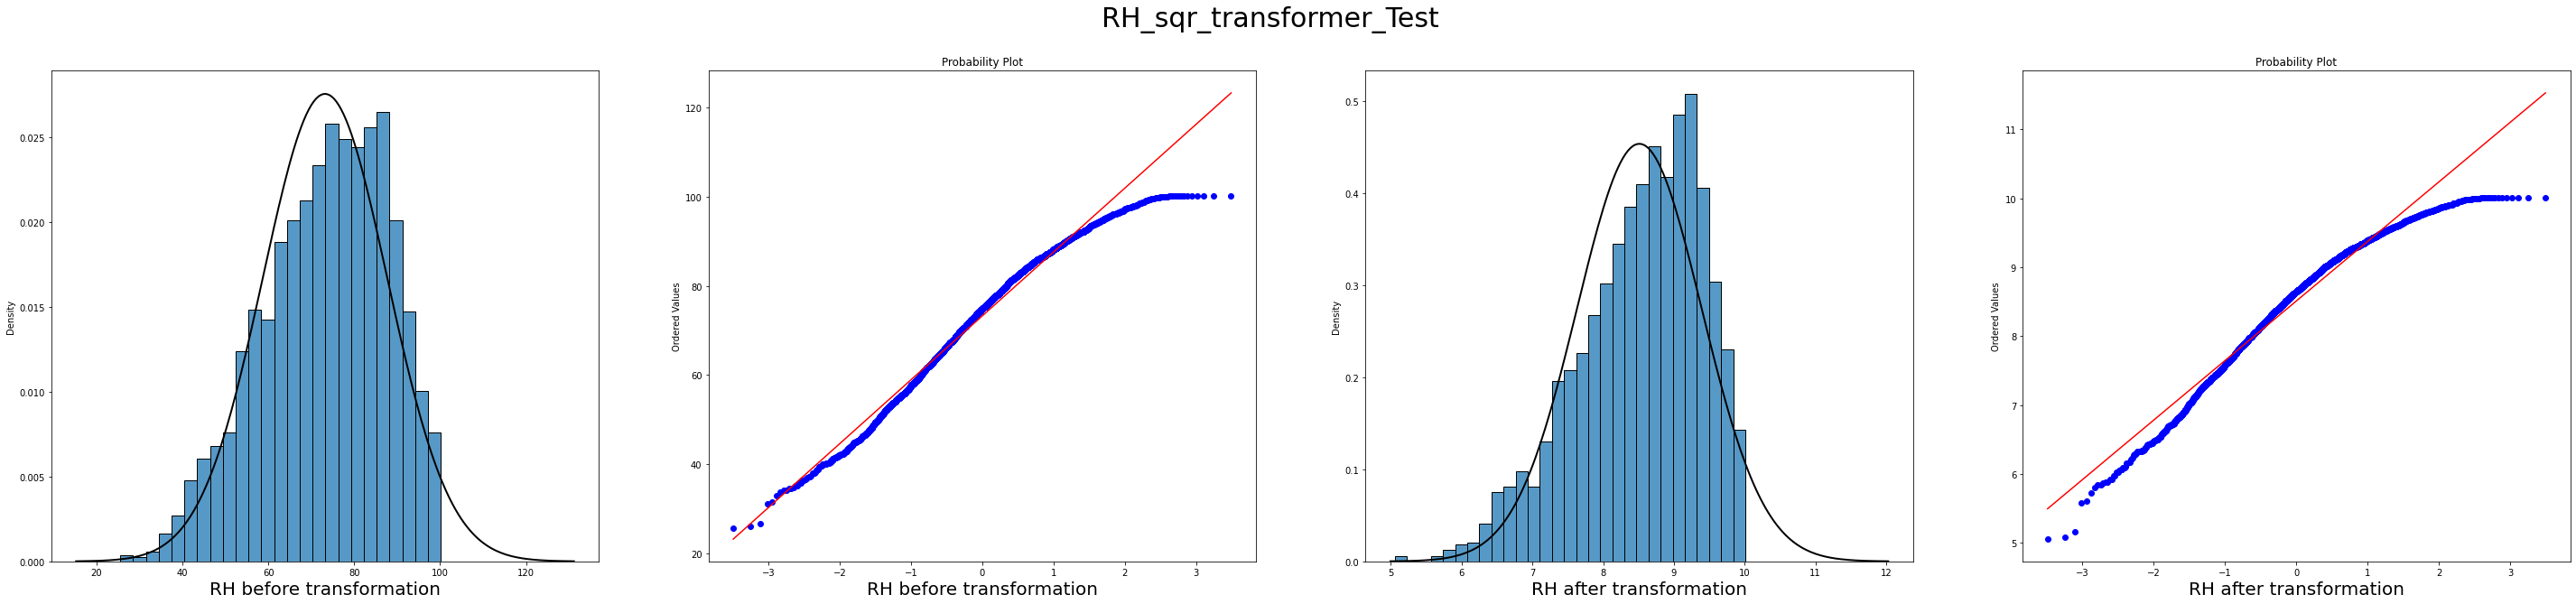

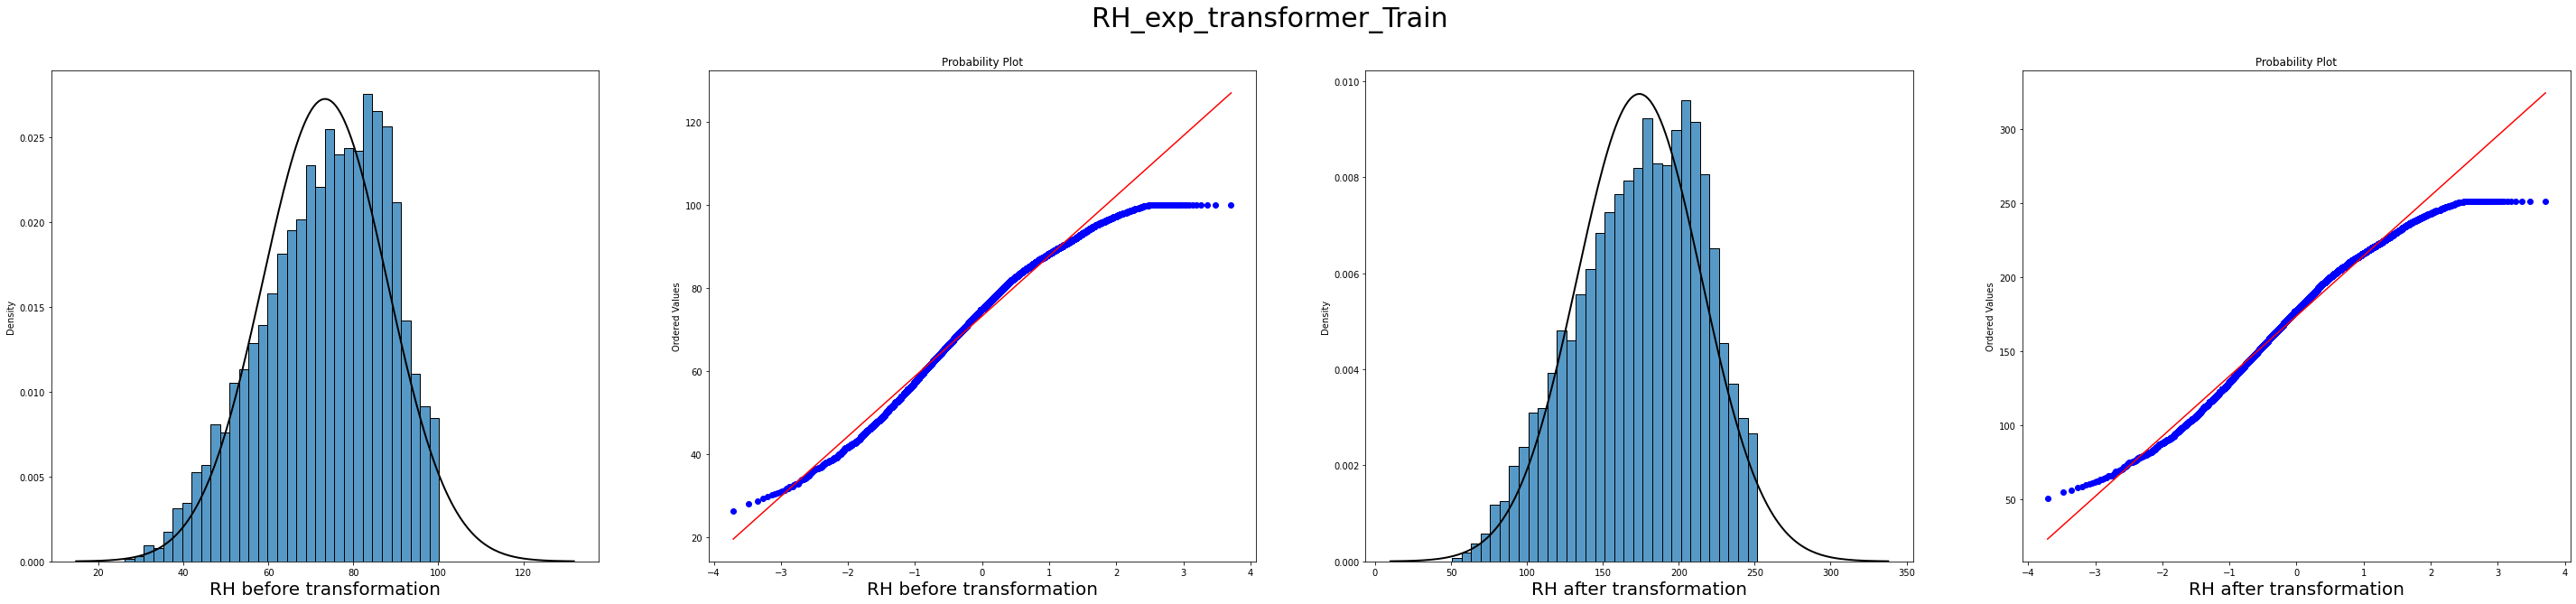

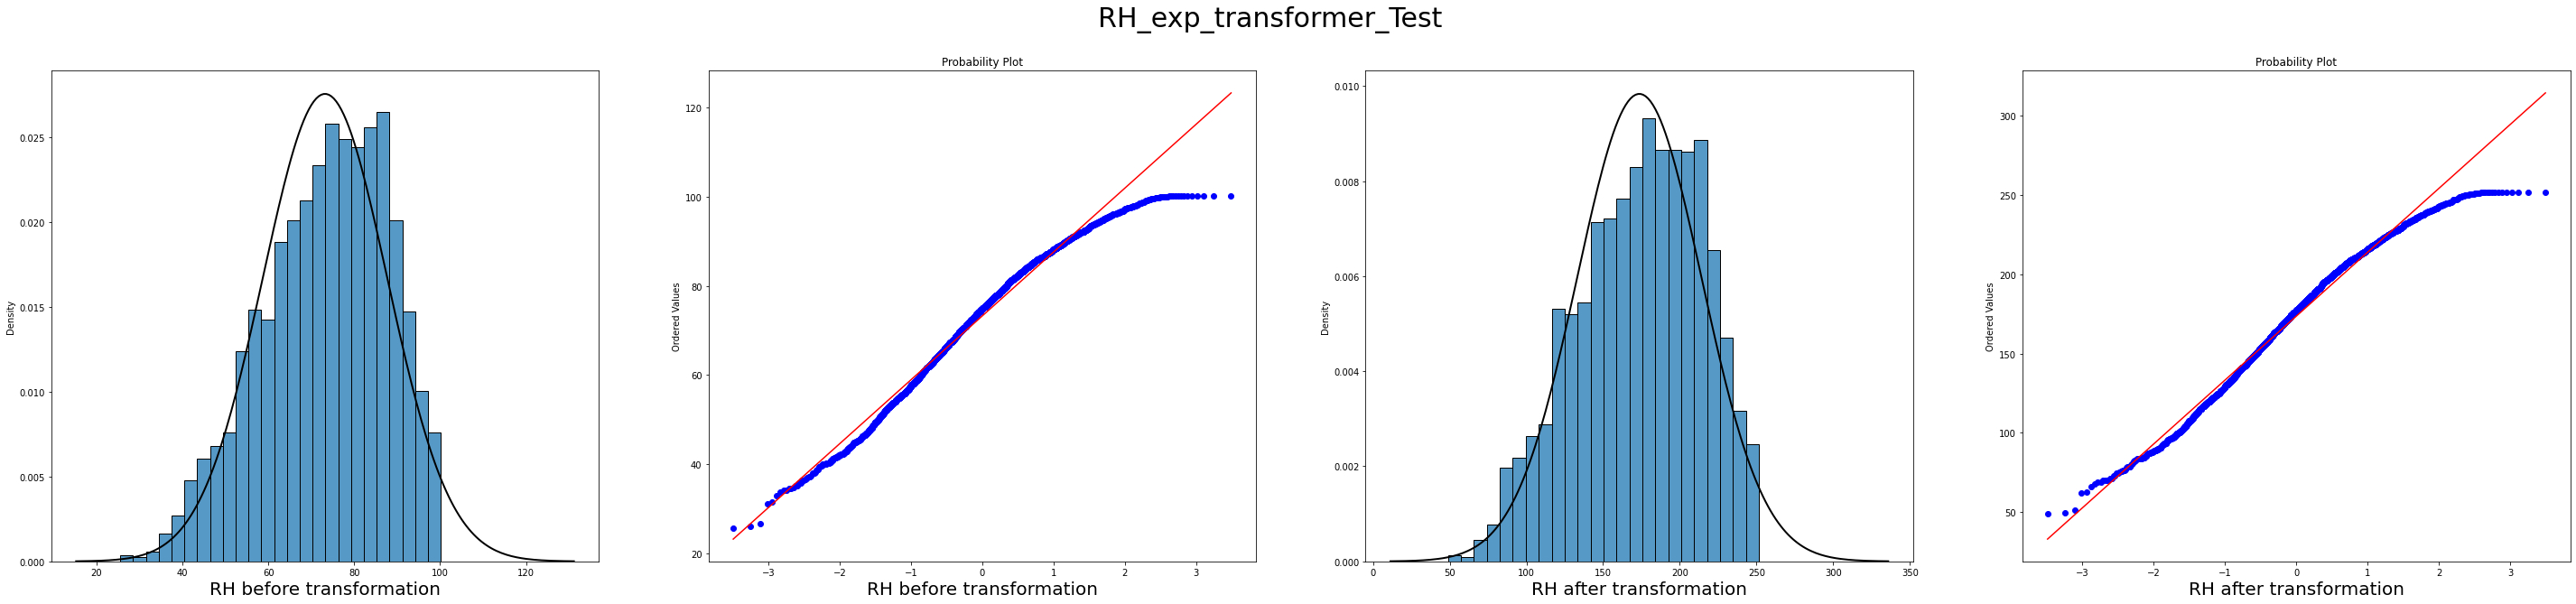

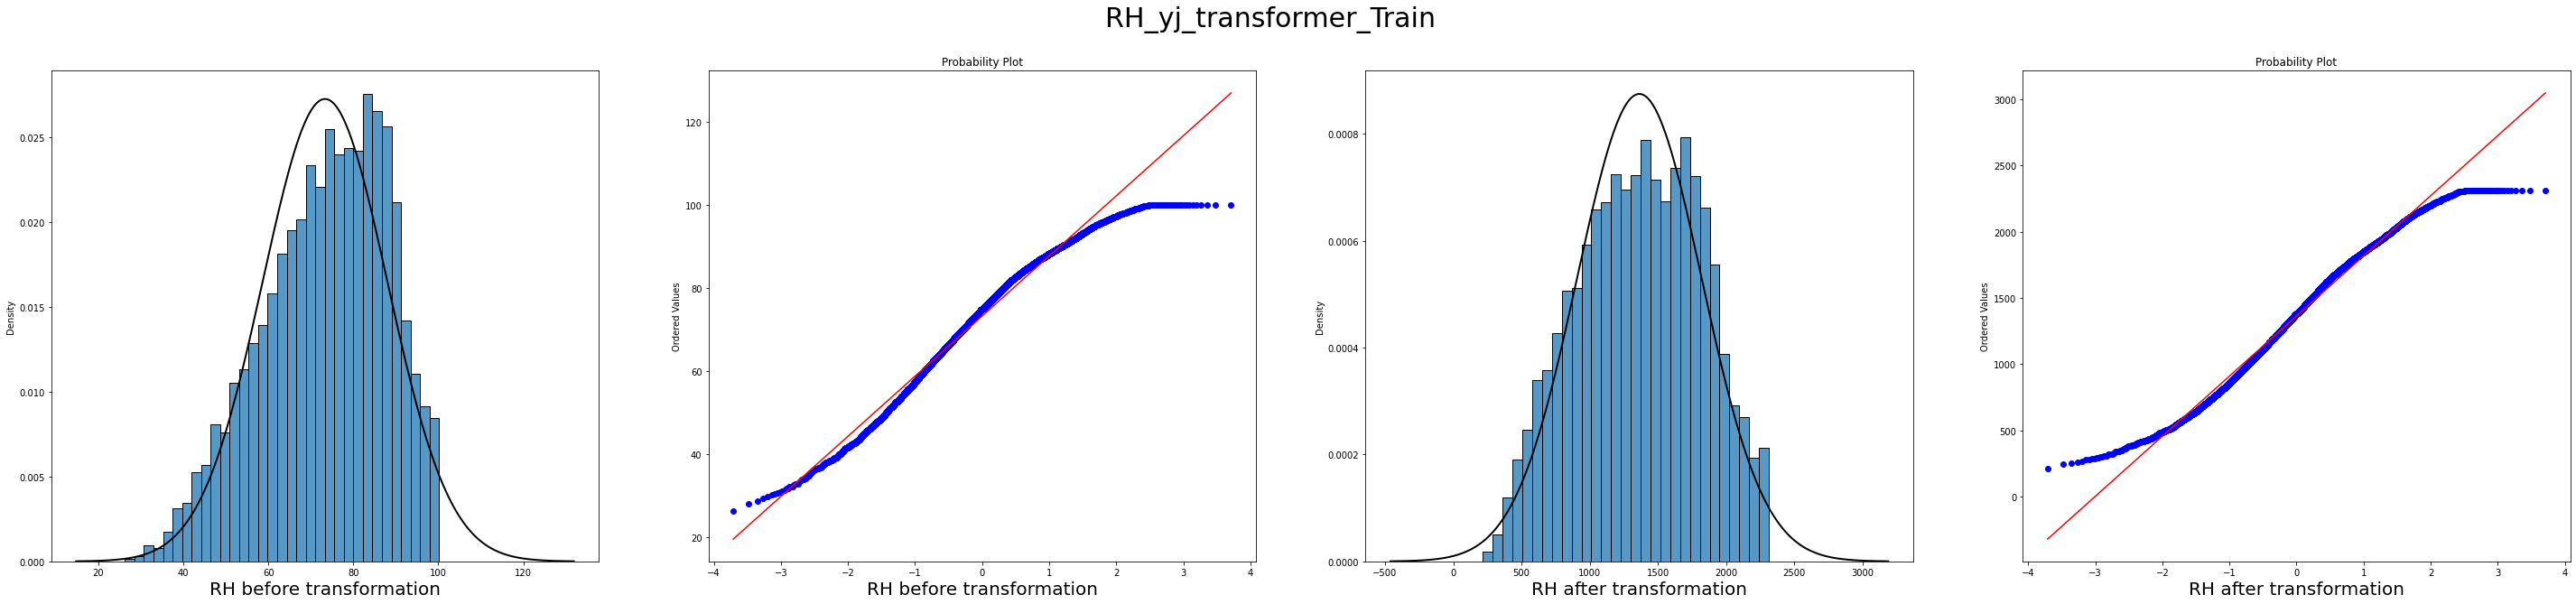

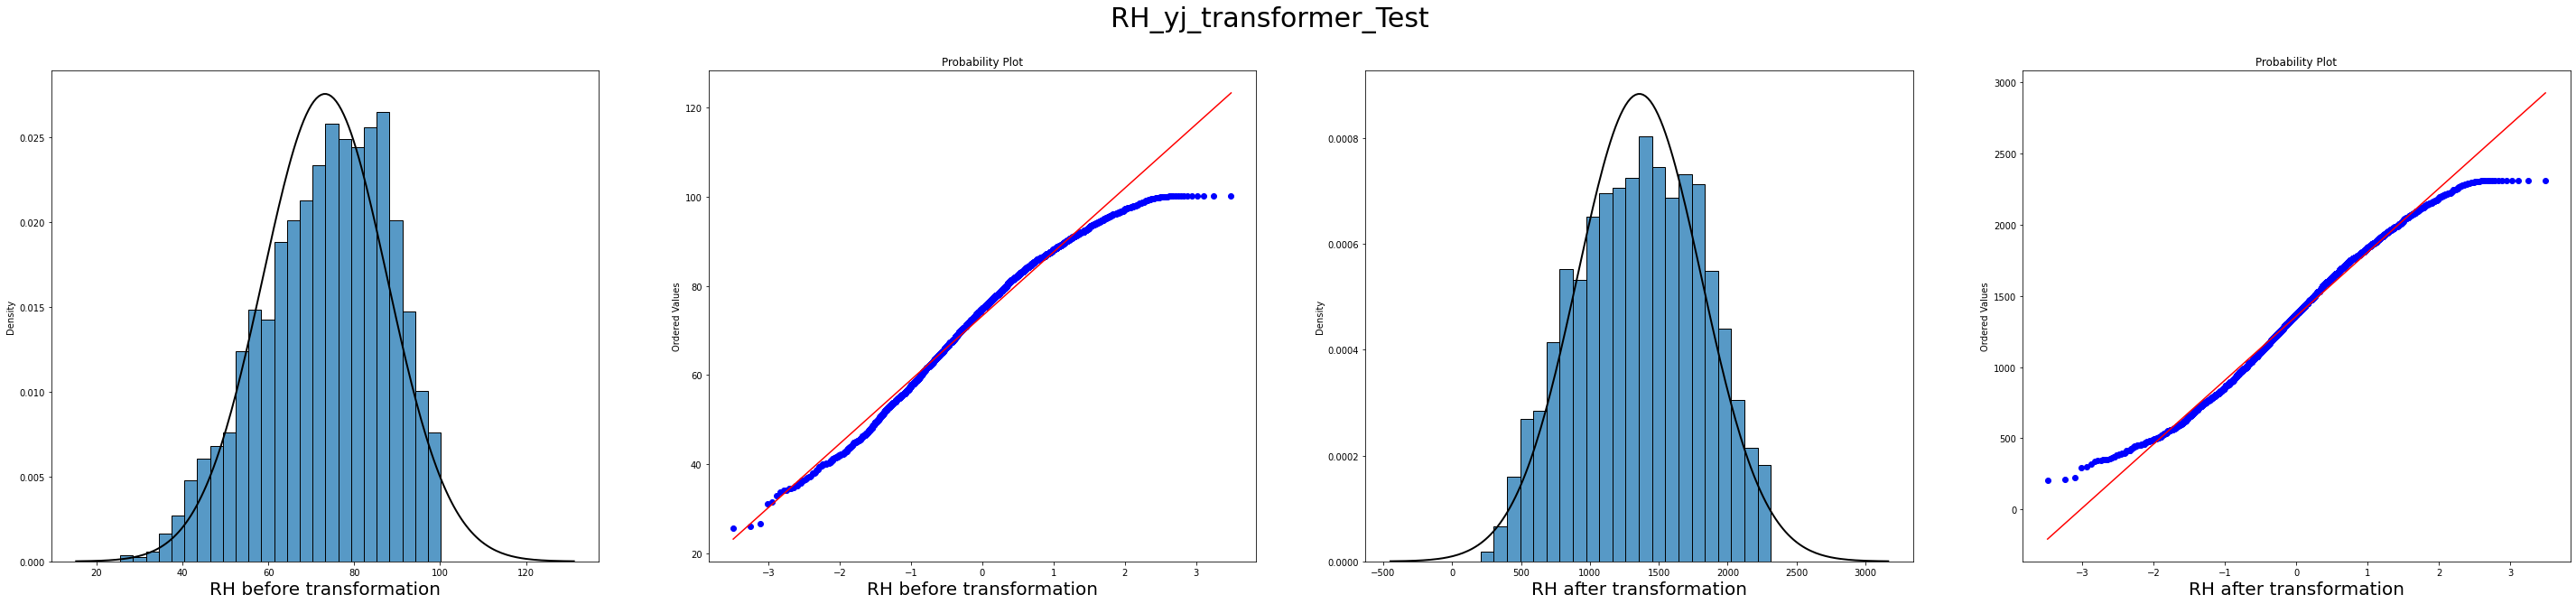

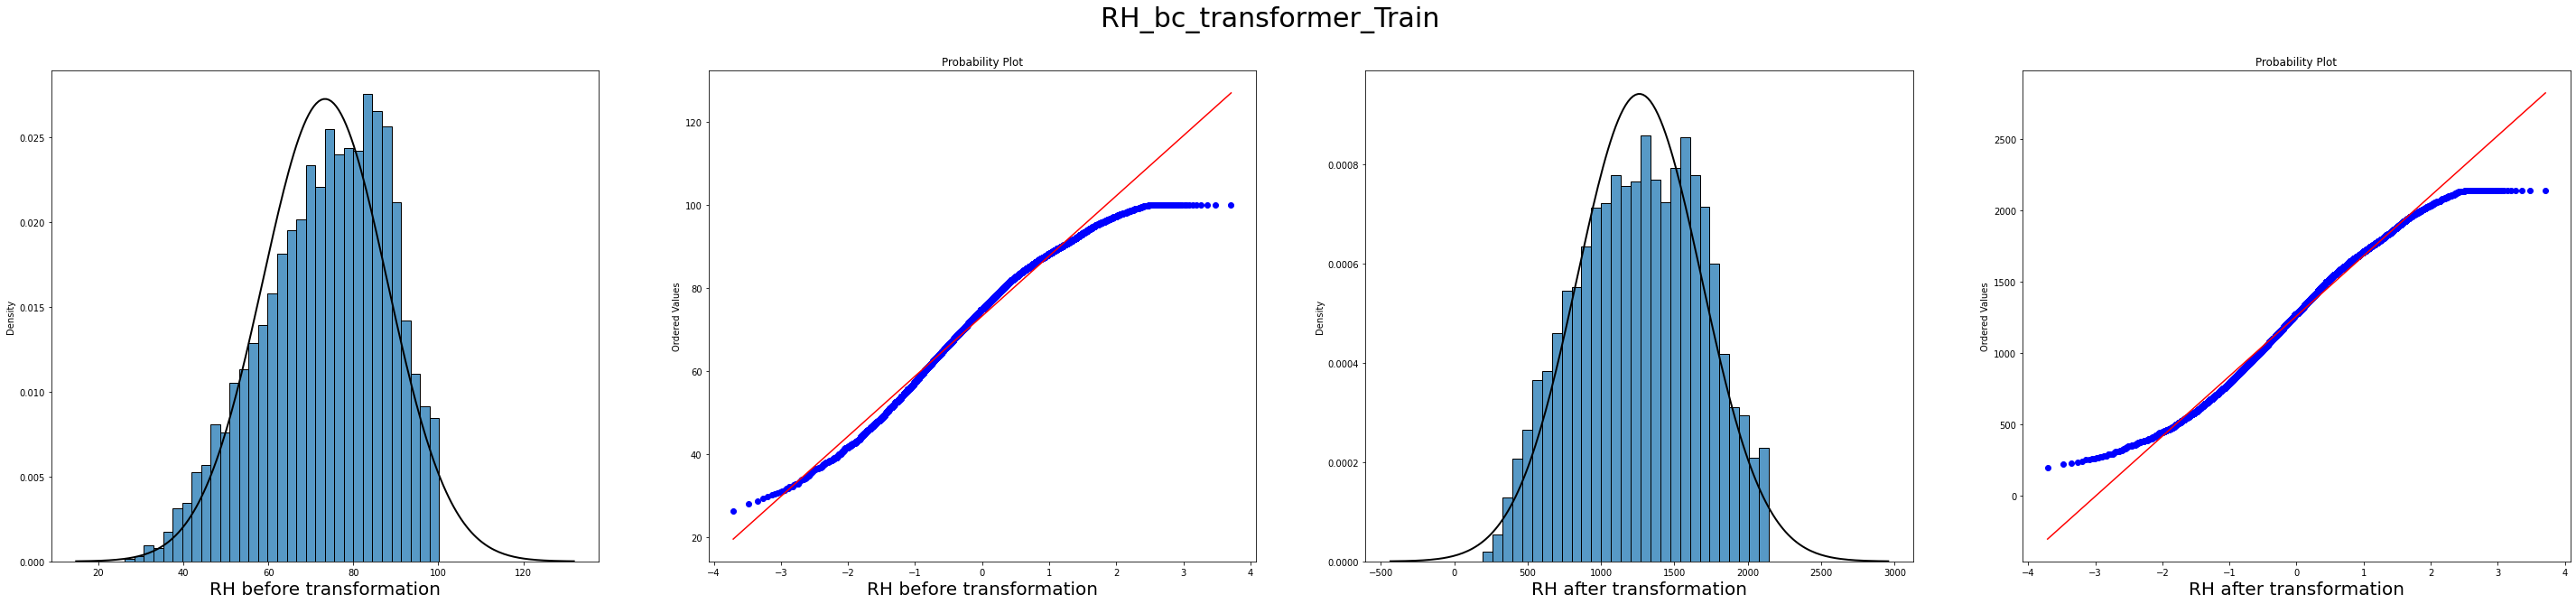

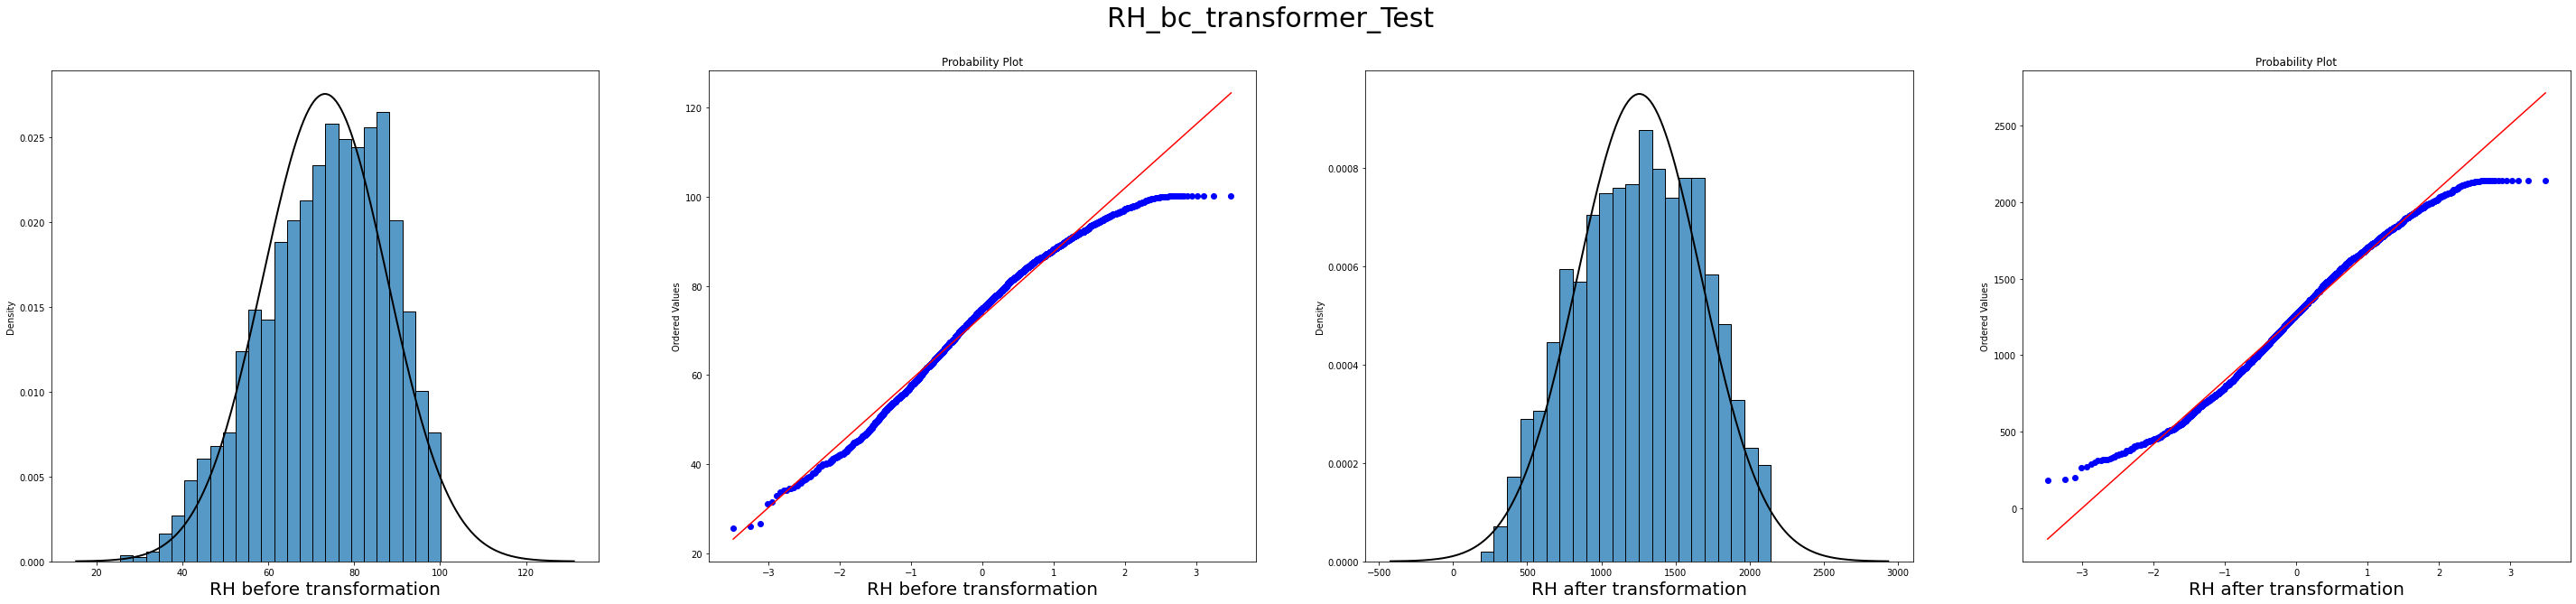

In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(pp_dataset_normalised, KNNImputer(n_neighbors=2))
transform_list(X_train, X_test, 'RH')

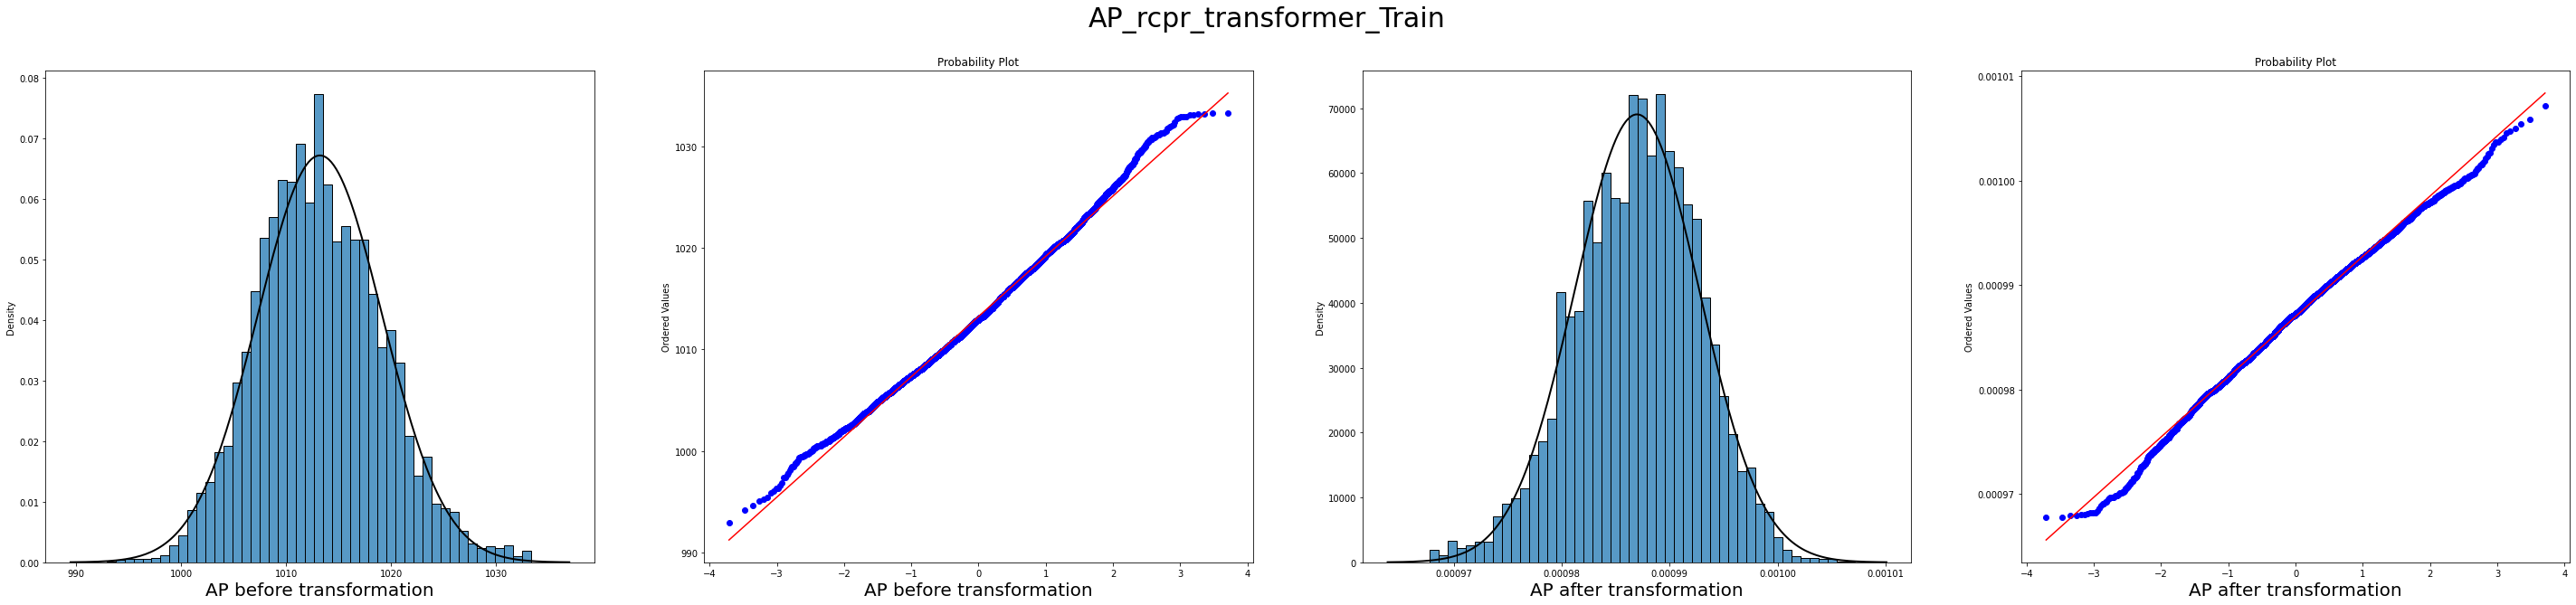

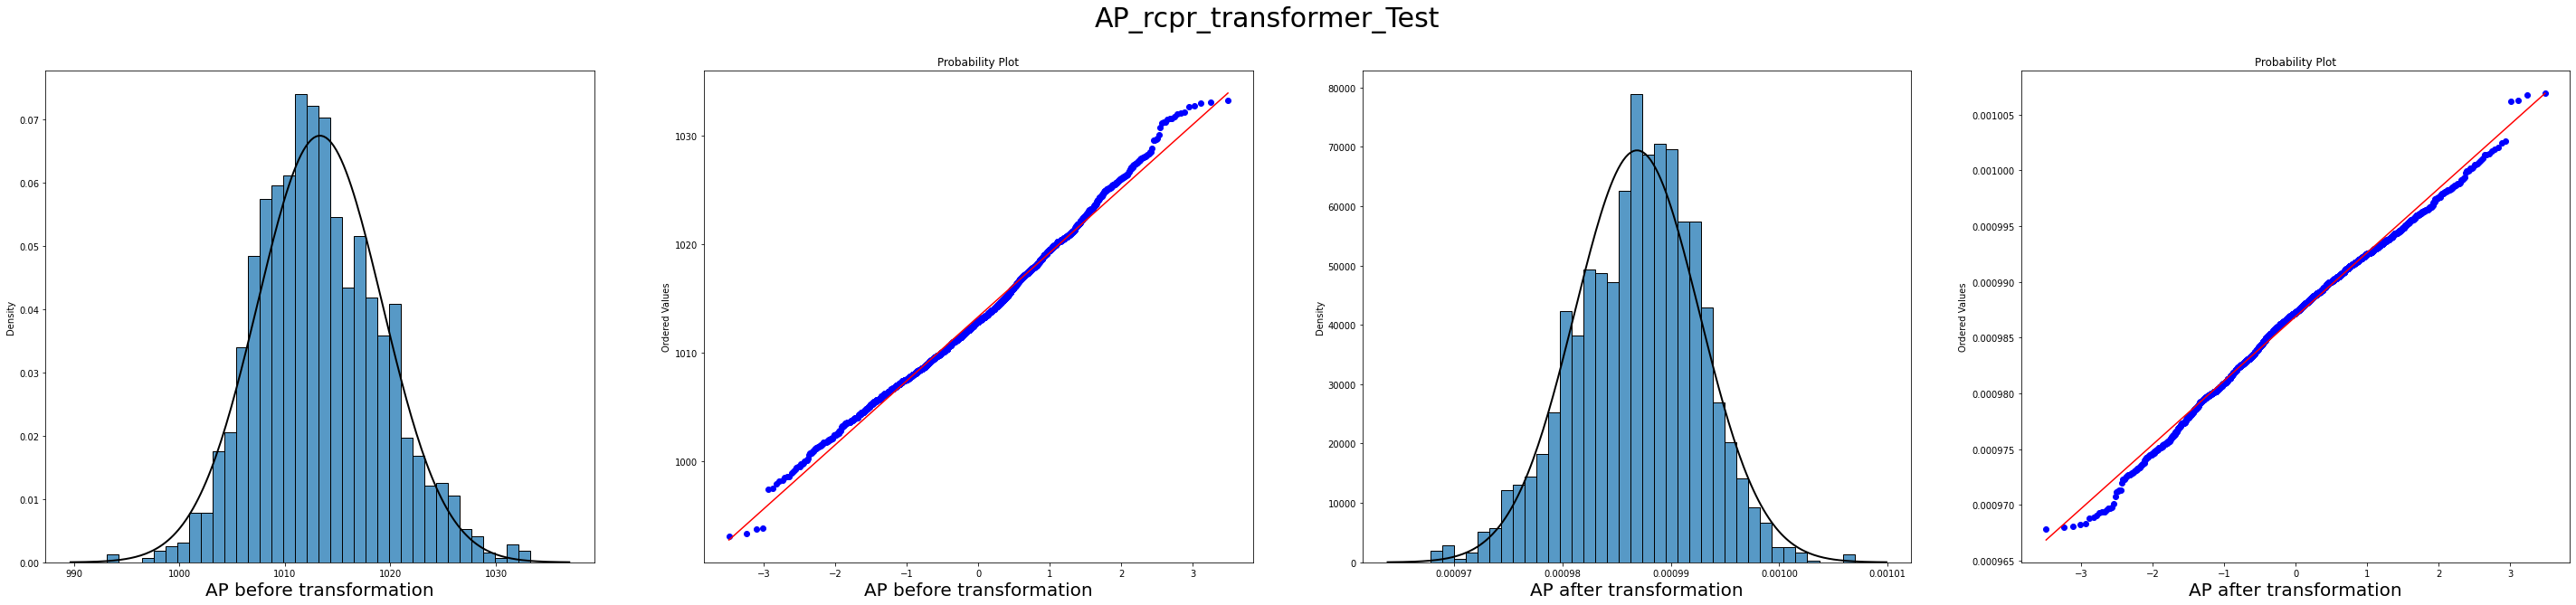

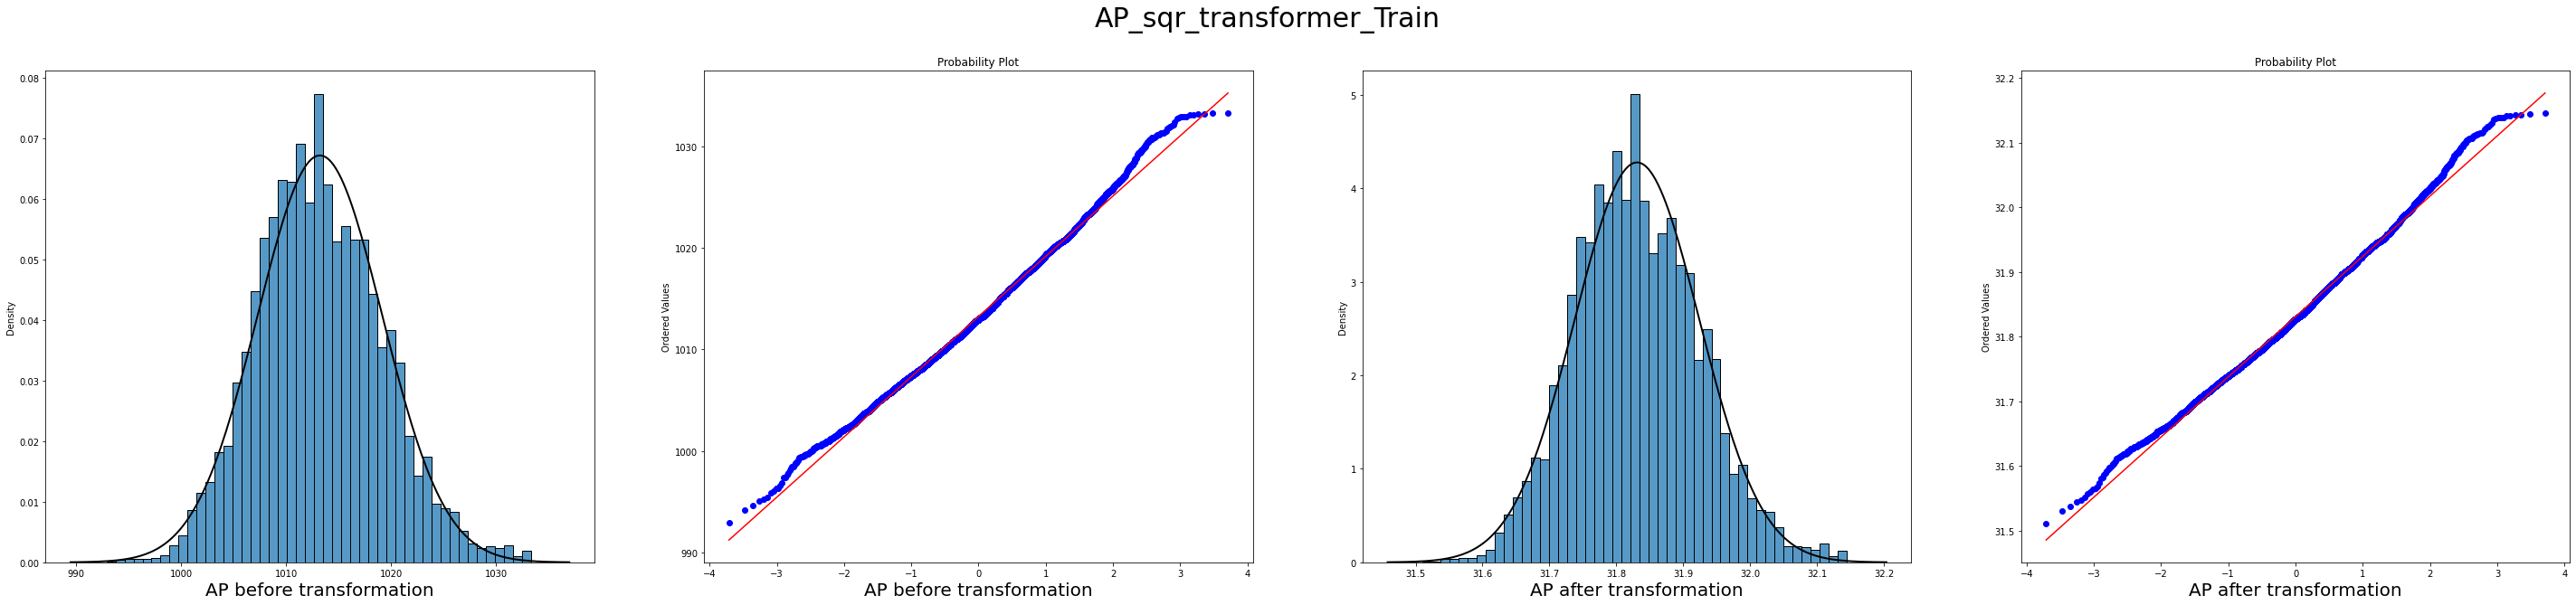

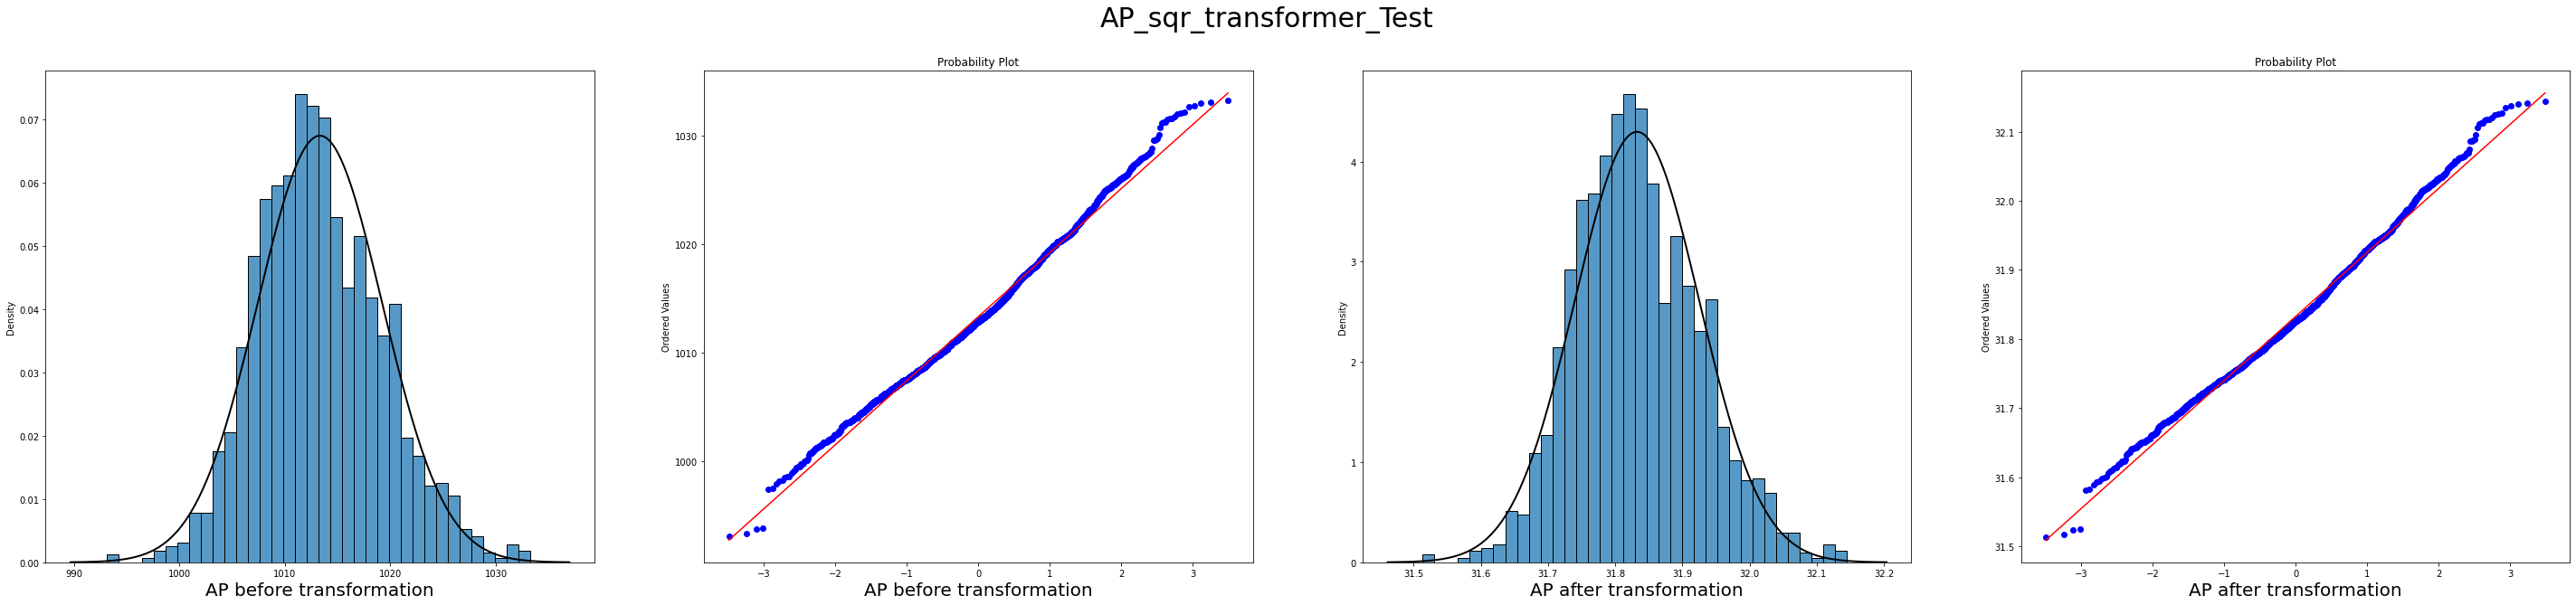

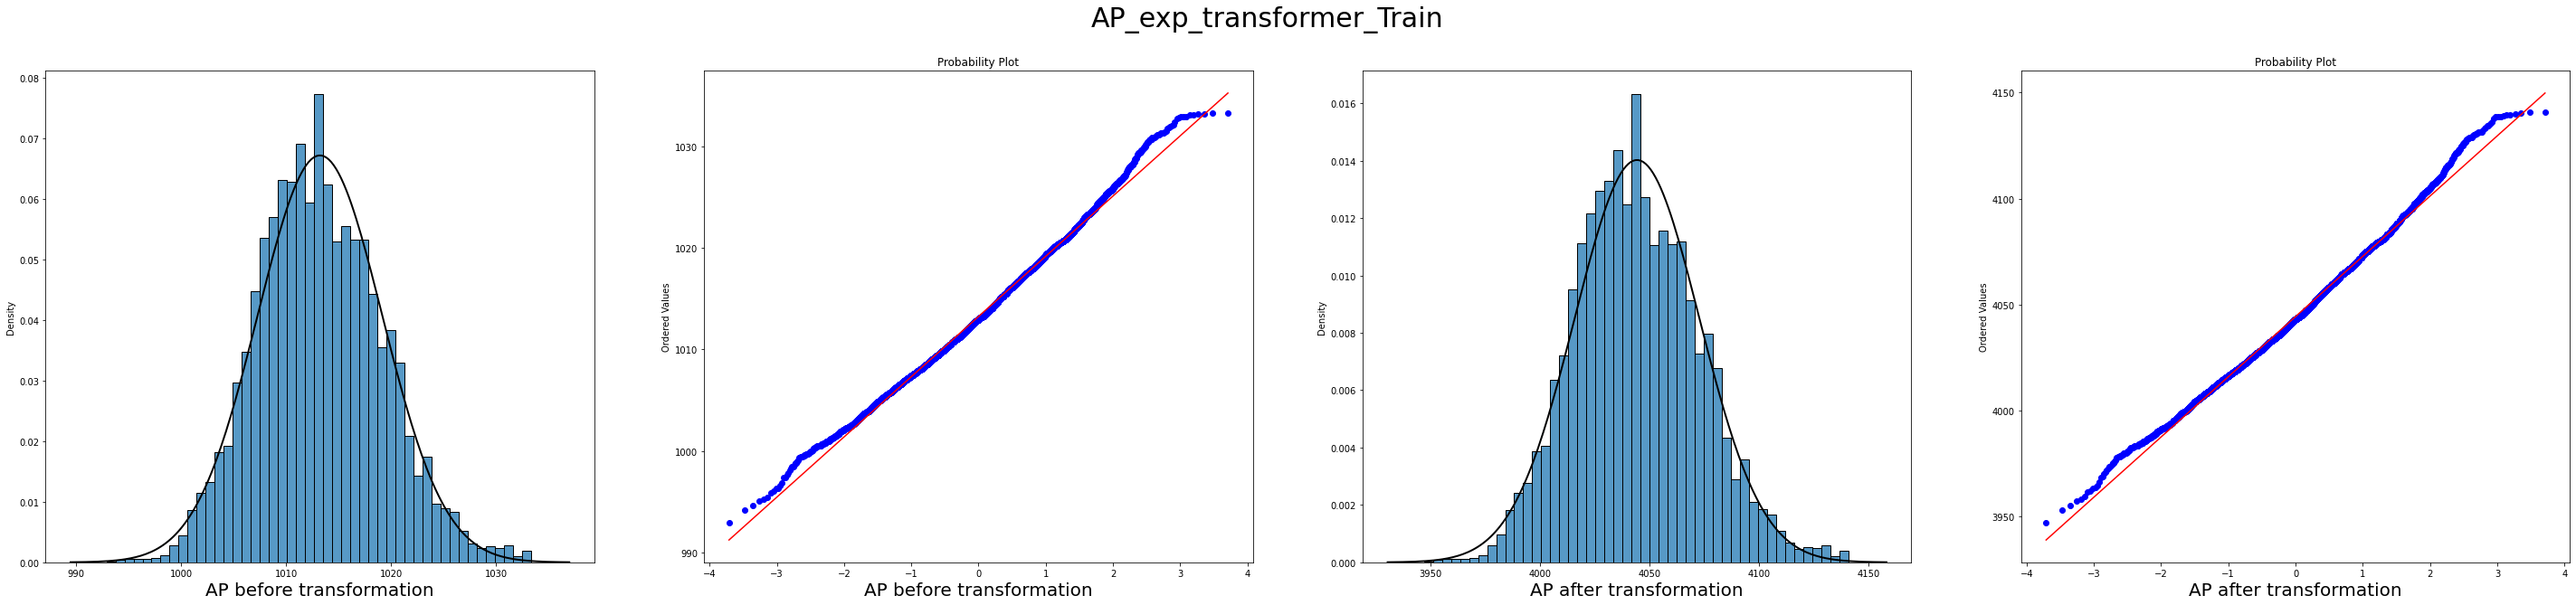

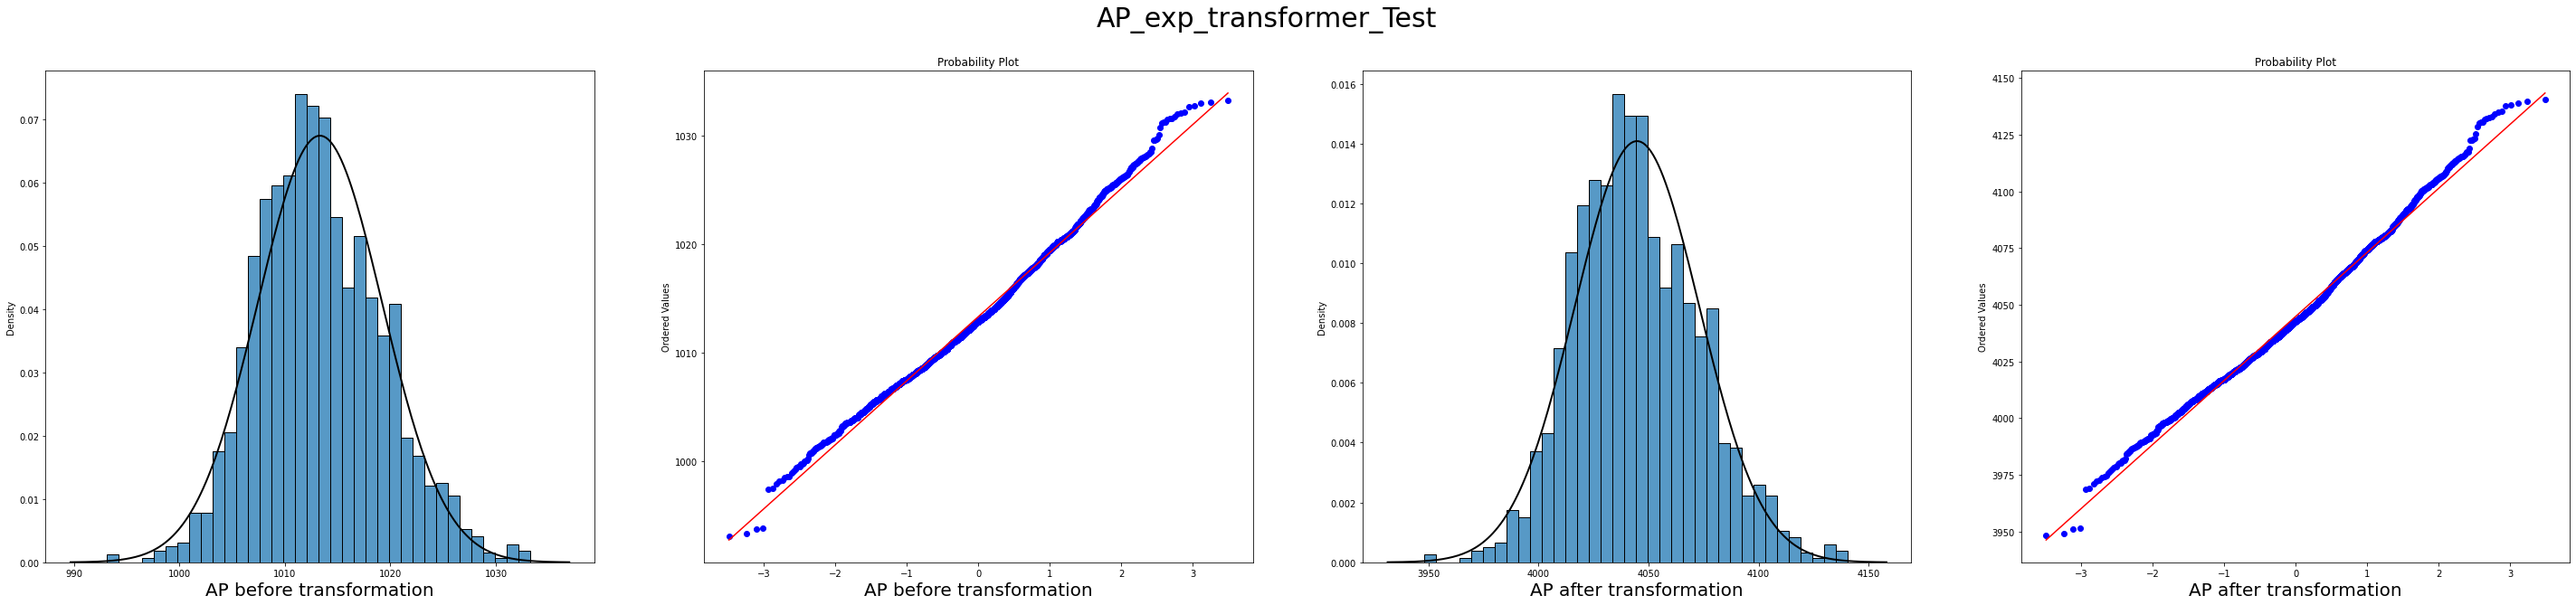

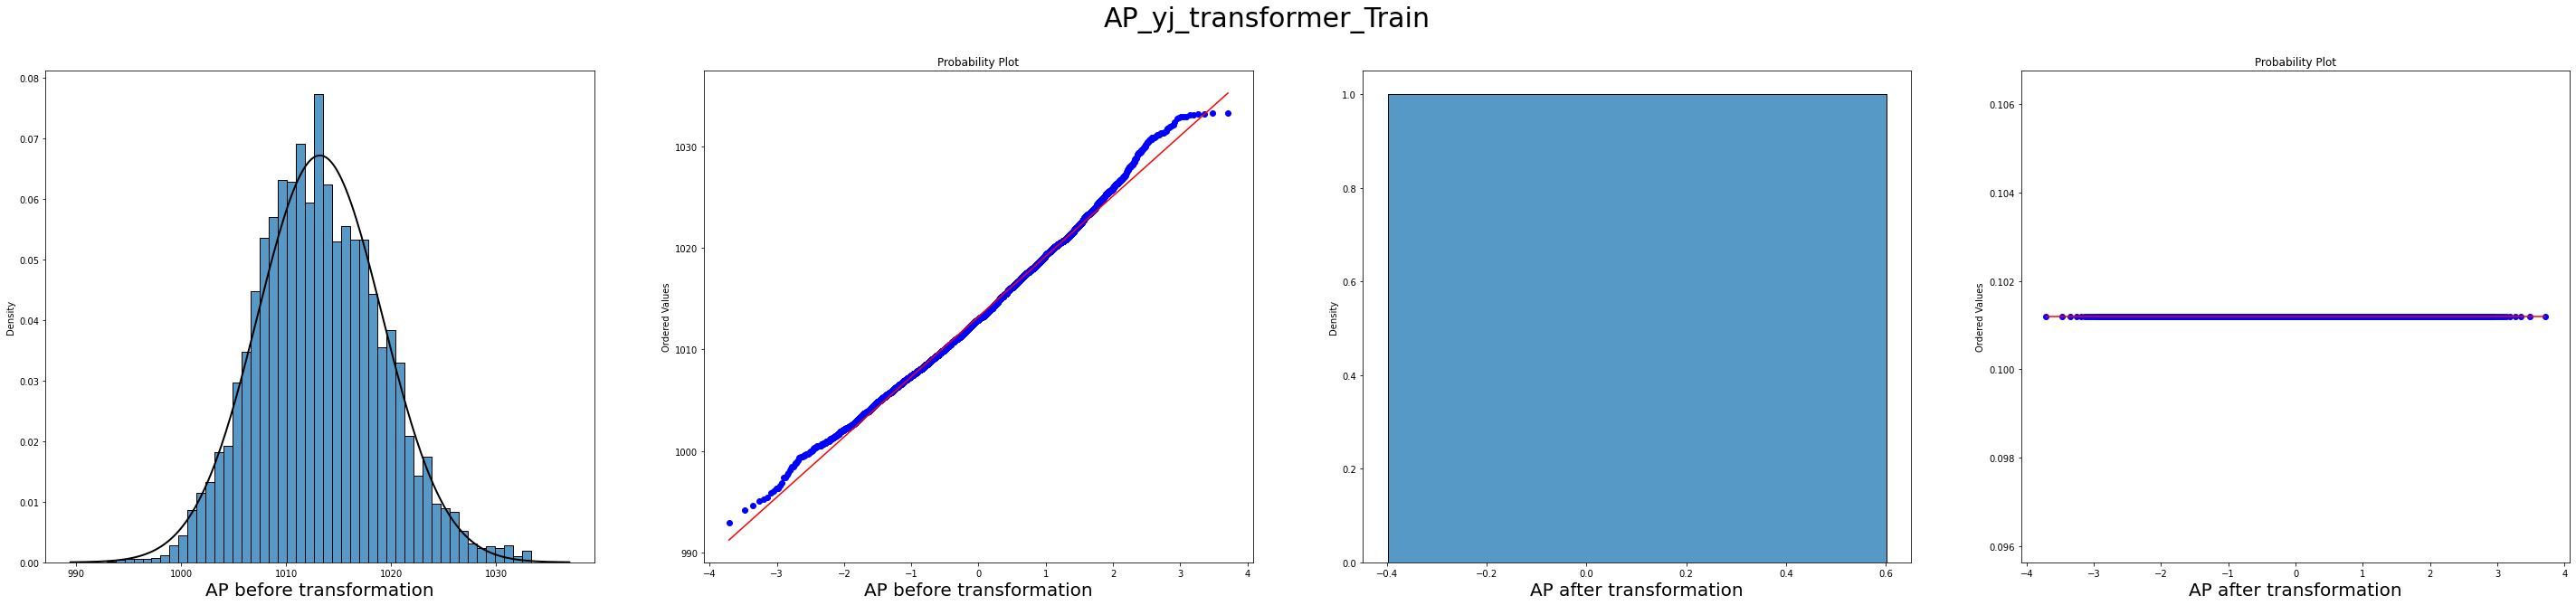

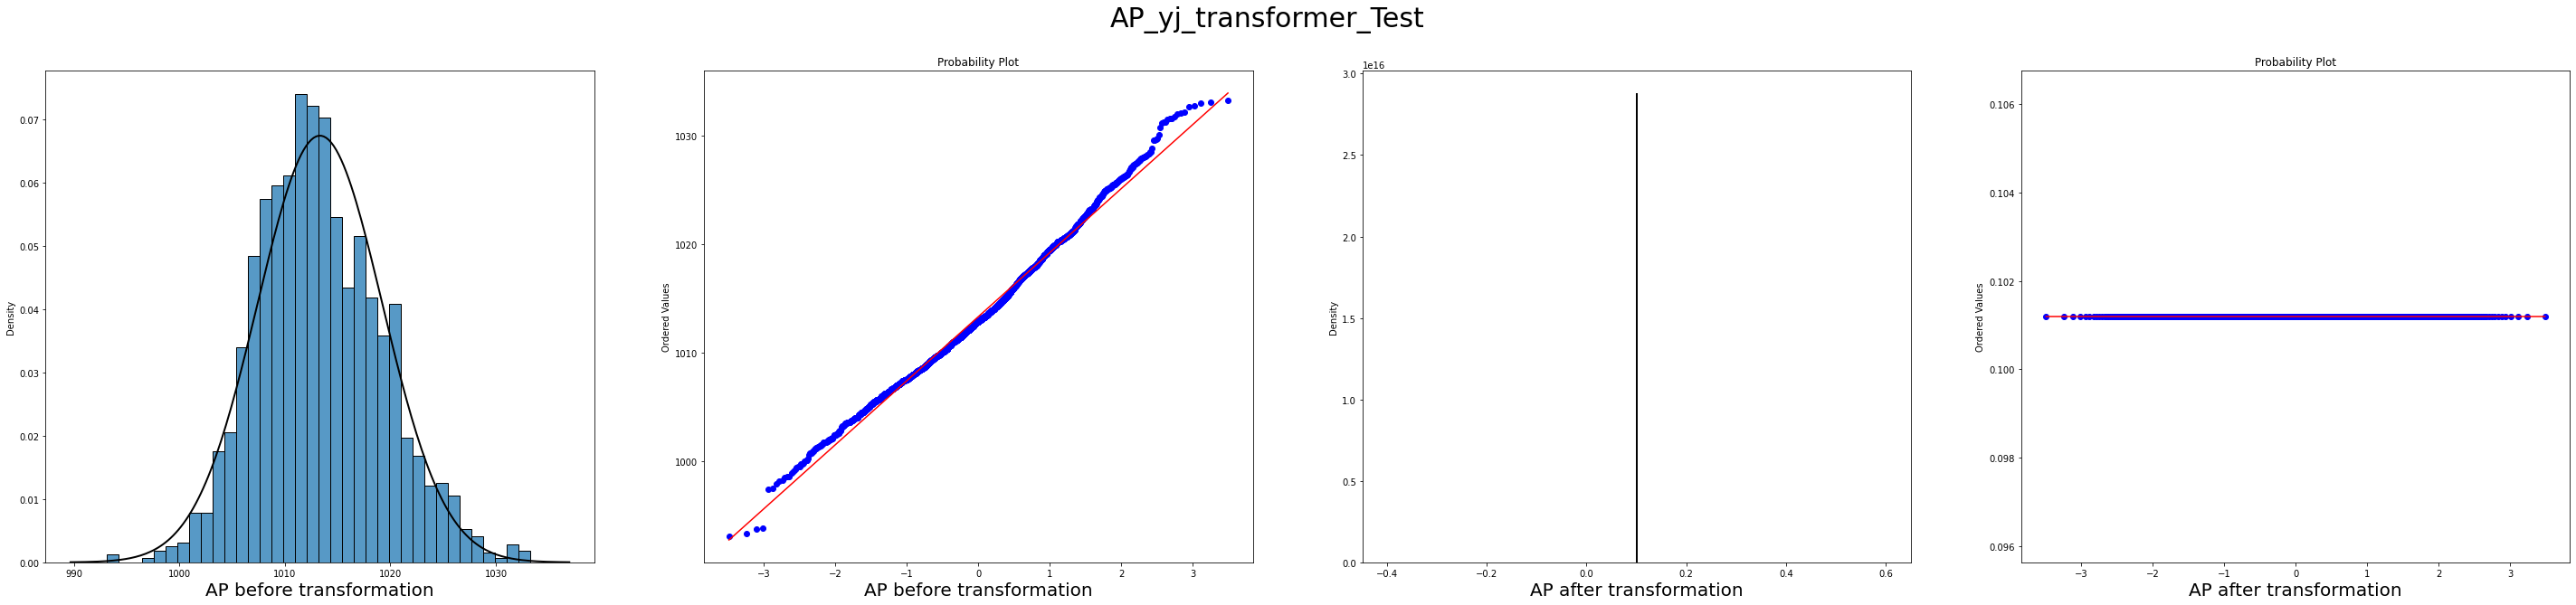

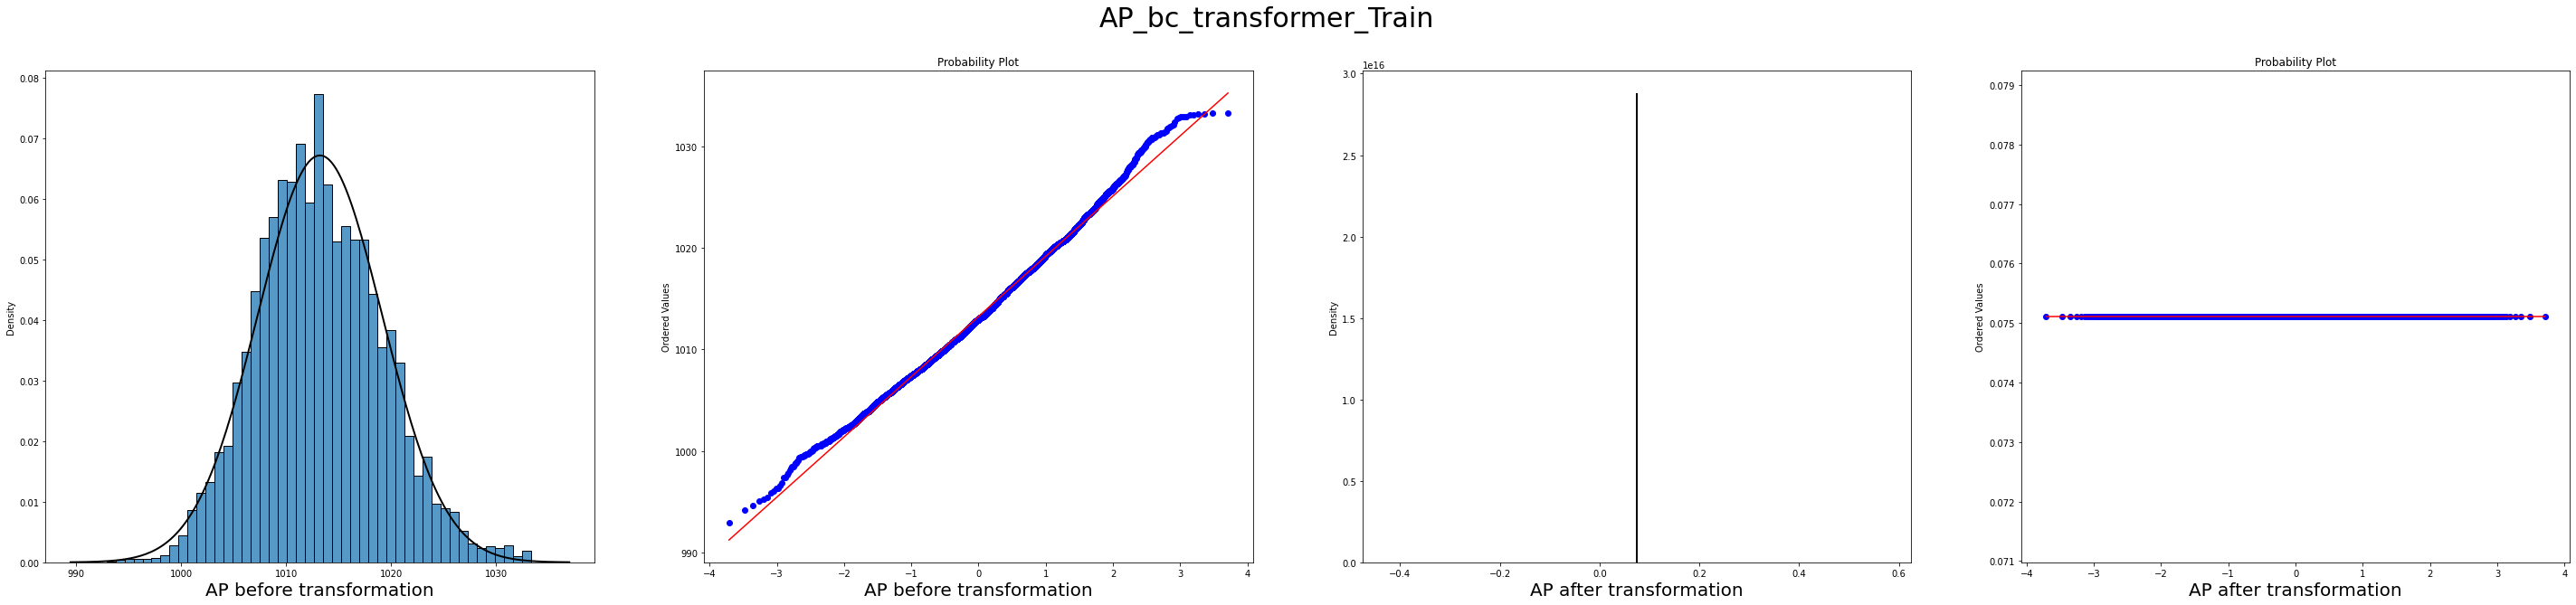

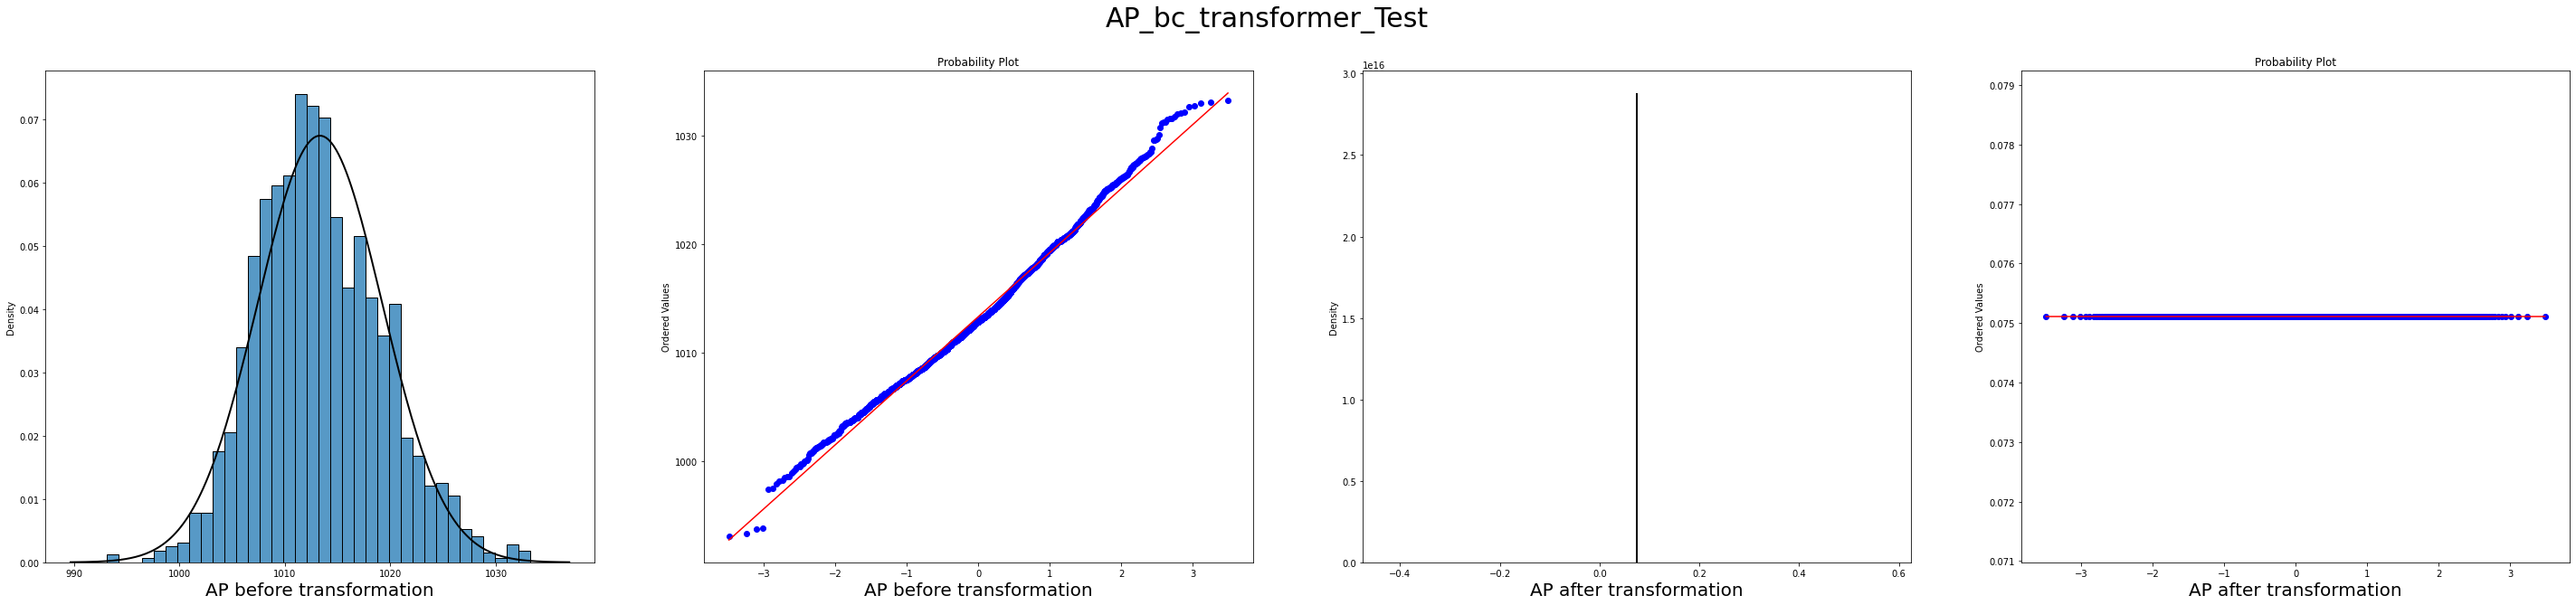

In [ ]:
X_train, X_test, y_train, y_test = reset_t_t_split(pp_dataset_normalised, KNNImputer(n_neighbors=2))
transform_list(X_train, X_test, 'AP')

- In case of 'RH' variable bc and yj transfromers show light improvement and will be tested on base model later on.
- In case of 'AP' variable rcpr transformer show light improvement and will be tested on base model later on


# 2.BaseModel

In [ ]:
pipe_simple = define_pipeline_simple(StandardScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, SimpleImputer(strategy = 'median'))
train_report_hist_pipe ("basemodel",LinearRegression(), pipe)

coefficient of determination: 0.9261519326237648
         modelName     mse    mae     evs      r2
0  basemodel_train  21.448  3.659  92.615  92.615
1   basemodel_test  22.164  3.687  92.441  92.440


## 2.1 BaseModel Imputer tuning

In [ ]:
#basic_model_imputer_mean
pipe_simple = define_pipeline_simple(StandardScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, SimpleImputer(strategy = 'mean'))
train_report_hist_pipe ("basemodel_imputer_mean",LinearRegression(), pipe)

coefficient of determination: 0.9259682919282918
                      modelName     mse    mae     evs      r2
0  basemodel_imputer_mean_train  21.501  3.661  92.597  92.597
1   basemodel_imputer_mean_test  22.216  3.688  92.423  92.422


In [ ]:
#basic_model_imputer_most_frequent
pipe_simple = define_pipeline_simple(StandardScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, SimpleImputer(strategy = 'most_frequent'))
train_report_hist_pipe ("basemodel_imputer_most_frequent",LinearRegression(), pipe)

coefficient of determination: 0.9213119341280759
                               modelName     mse    mae     evs      r2
0  basemodel_imputer_most_frequent_train  22.853  3.705  92.131  92.131
1   basemodel_imputer_most_frequent_test  23.220  3.722  92.081  92.079


In [ ]:
pipe_simple = define_pipeline_simple(StandardScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2))
train_report_hist_pipe ("basemodel_knnimputer",LinearRegression(), pipe)

coefficient of determination: 0.9286300855389036
                    modelName     mse    mae     evs      r2
0  basemodel_knnimputer_train  20.728  3.619  92.863  92.863
1   basemodel_knnimputer_test  21.391  3.657  92.705  92.703


MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 
 
 
 
 3 
 basemodel_knnimputer 
 20.728 
 21.391 
 
 
 0 
 basemodel 
 21.448 
 22.164 
 
 
 1 
 basemodel_imputer_mean 
 21.501 
 22.216 
 
 
 2 
 basemodel_imputer_most_frequent 
 22.853 
 23.220 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 
 
 
 
 3 
 basemodel_knnimputer 
 3.619 
 3.657 
 
 
 0 
 basemodel 
 3.659 
 3.687 
 
 
 1 
 basemodel_imputer_mean 
 3.661 
 3.688 
 
 
 2 
 basemodel_imputer_most_frequent 
 3.705 
 3.722 
 
 
 
____
 
 r2score 
 
 
   
 modelName 
 train_r2score 
 test_r2score 
 
 
 
 
 3 
 basemodel_knnimputer 
 92.863 
 92.703 
 
 
 0 
 basemodel 
 92.615 
 92.440 
 
 
 1 
 basemodel_imputer_mean 
 92.597 
 92.422 
 
 
 2 
 basemodel_imputer_most_frequent 
 92.131 
 92.079 
 
 
 
____
 
 EVS 
 
 
   
 modelName 
 train_evs 
 test_evs 
 
 
 
 
 3 
 basemodel_knnimputer 
 92.863 
 92.705 
 
 
 0 
 basemodel 
 92.615 
 92.441 
 
 
 1 
 basemodel_imputer_mean 
 92.597 
 92.423 
 
 
 2 
 basemodel_imputer_most_frequent 
 92.131 
 92.081

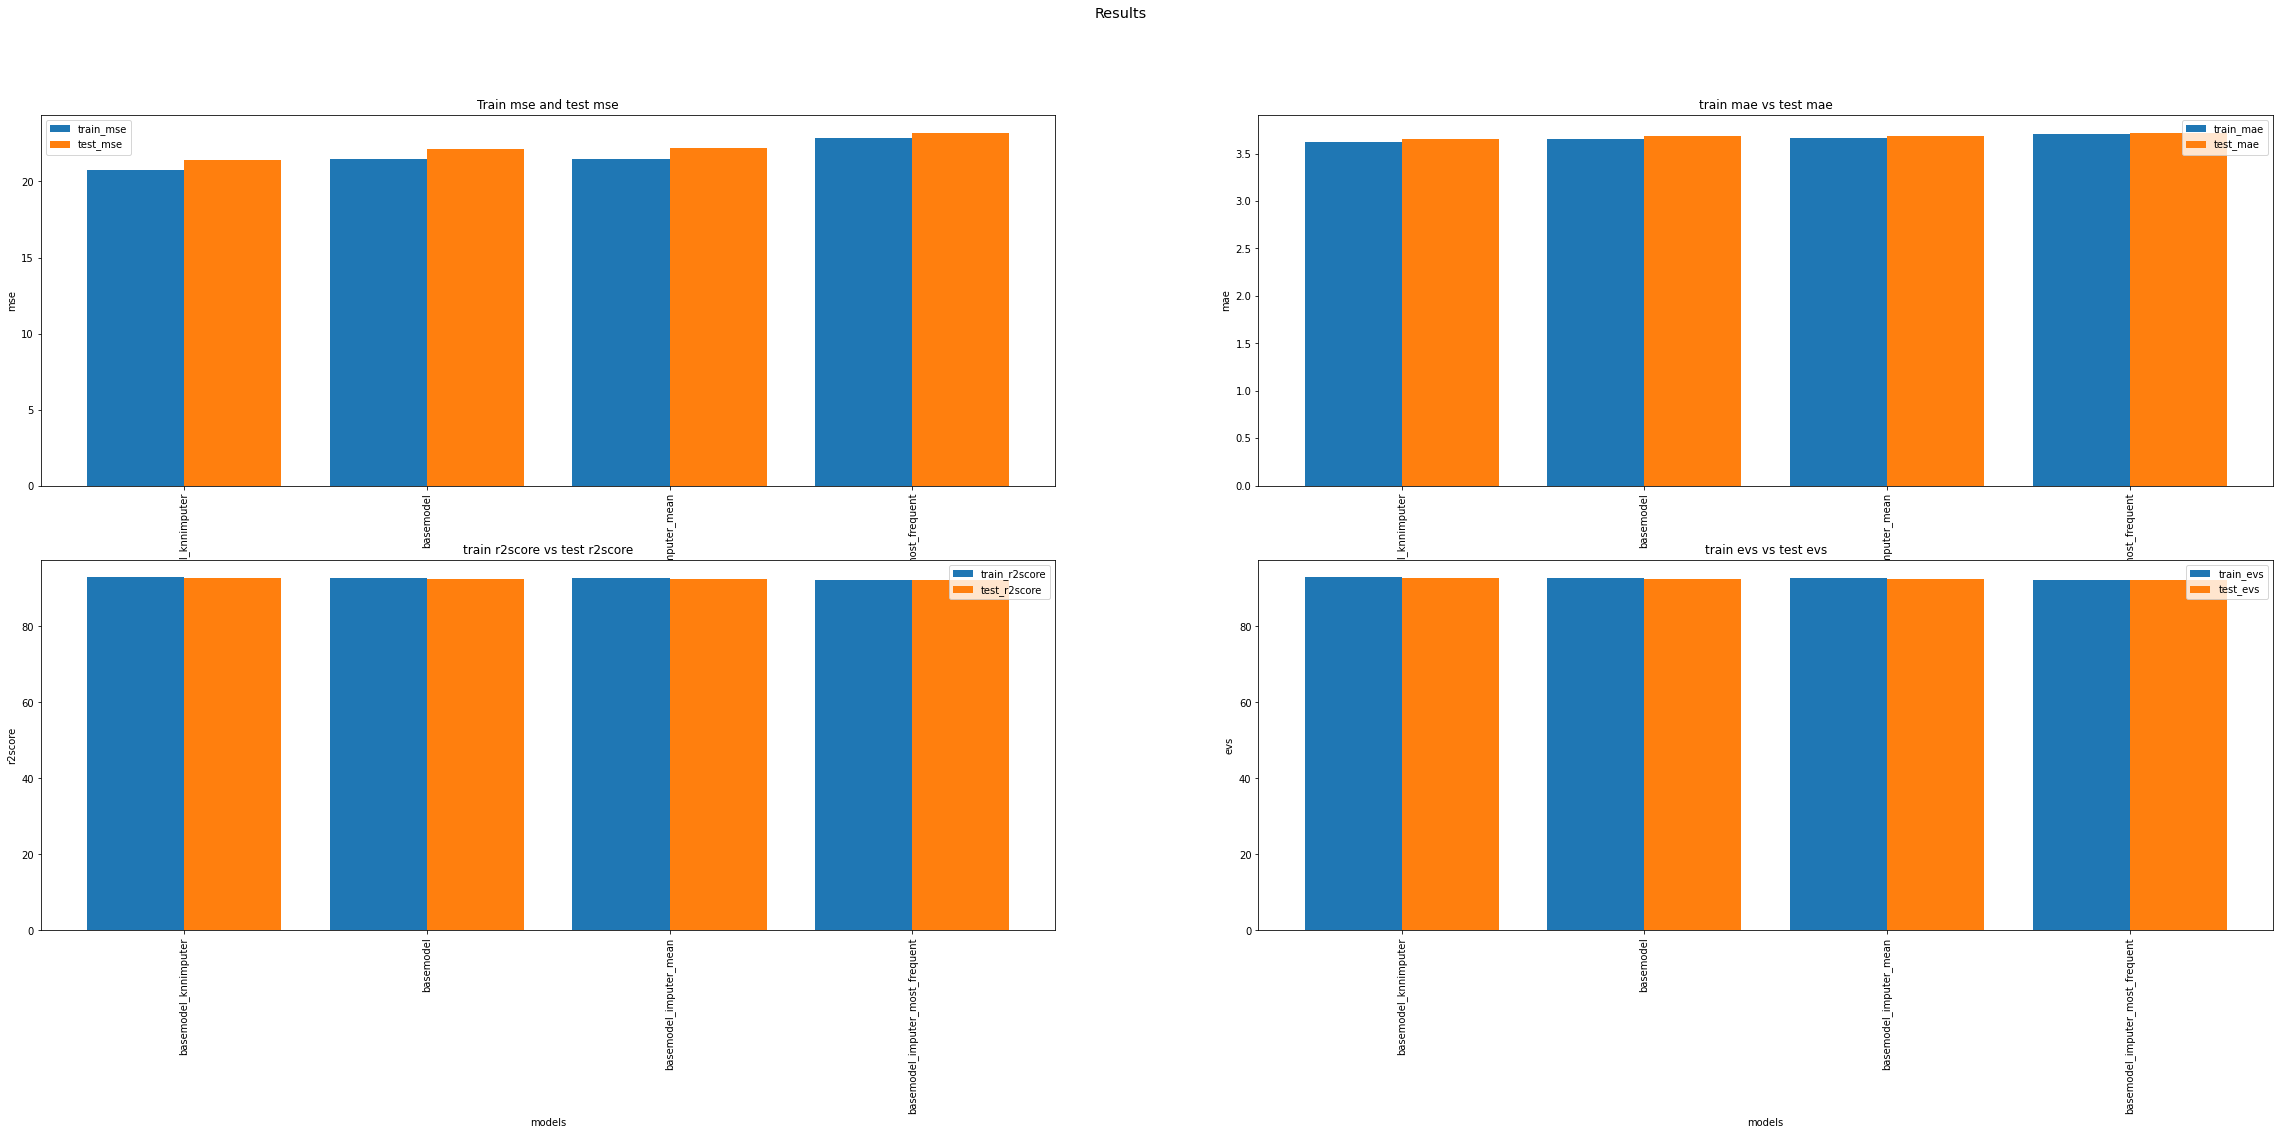

In [ ]:
show_results()

All options has shown no overfit, but knn imputer shows best results. Modell will be trained further on with KNN Imputer

## 2.2 BaseModel Scaler tuning

In [ ]:
pipe_simple = define_pipeline_simple(MinMaxScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2))
train_report_hist_pipe ("basemodel_knnimputer_MinMaxScaler",LinearRegression(), pipe)

coefficient of determination: 0.9286300855389036
                                 modelName     mse    mae     evs      r2
0  basemodel_knnimputer_MinMaxScaler_train  20.728  3.619  92.863  92.863
1   basemodel_knnimputer_MinMaxScaler_test  21.391  3.657  92.705  92.703


In [ ]:
pipe_simple = define_pipeline_simple( RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2))
train_report_hist_pipe ("basemodel_knnimputer_RobustSclaer",LinearRegression(), pipe)

coefficient of determination: 0.9286300855389036
                                 modelName     mse    mae     evs      r2
0  basemodel_knnimputer_RobustSclaer_train  20.728  3.619  92.863  92.863
1   basemodel_knnimputer_RobustSclaer_test  21.391  3.657  92.705  92.703


MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 
 
 
 
 1 
 basemodel_knnimputer 
 20.728 
 21.391 
 
 
 2 
 basemodel_knnimputer_MinMaxScaler 
 20.728 
 21.391 
 
 
 3 
 basemodel_knnimputer_RobustSclaer 
 20.728 
 21.391 
 
 
 0 
 basemodel 
 21.448 
 22.164 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 
 
 
 
 1 
 basemodel_knnimputer 
 3.619 
 3.657 
 
 
 2 
 basemodel_knnimputer_MinMaxScaler 
 3.619 
 3.657 
 
 
 3 
 basemodel_knnimputer_RobustSclaer 
 3.619 
 3.657 
 
 
 0 
 basemodel 
 3.659 
 3.687 
 
 
 
____
 
 r2score 
 
 
   
 modelName 
 train_r2score 
 test_r2score 
 
 
 
 
 1 
 basemodel_knnimputer 
 92.863 
 92.703 
 
 
 2 
 basemodel_knnimputer_MinMaxScaler 
 92.863 
 92.703 
 
 
 3 
 basemodel_knnimputer_RobustSclaer 
 92.863 
 92.703 
 
 
 0 
 basemodel 
 92.615 
 92.440 
 
 
 
____
 
 EVS 
 
 
   
 modelName 
 train_evs 
 test_evs 
 
 
 
 
 1 
 basemodel_knnimputer 
 92.863 
 92.705 
 
 
 2 
 basemodel_knnimputer_MinMaxScaler 
 92.863 
 92.705 
 
 
 3 
 basemodel_knnimputer_RobustSclaer 
 92.863 
 92.705 
 
 
 0 
 basemodel 
 92.615 
 92.441

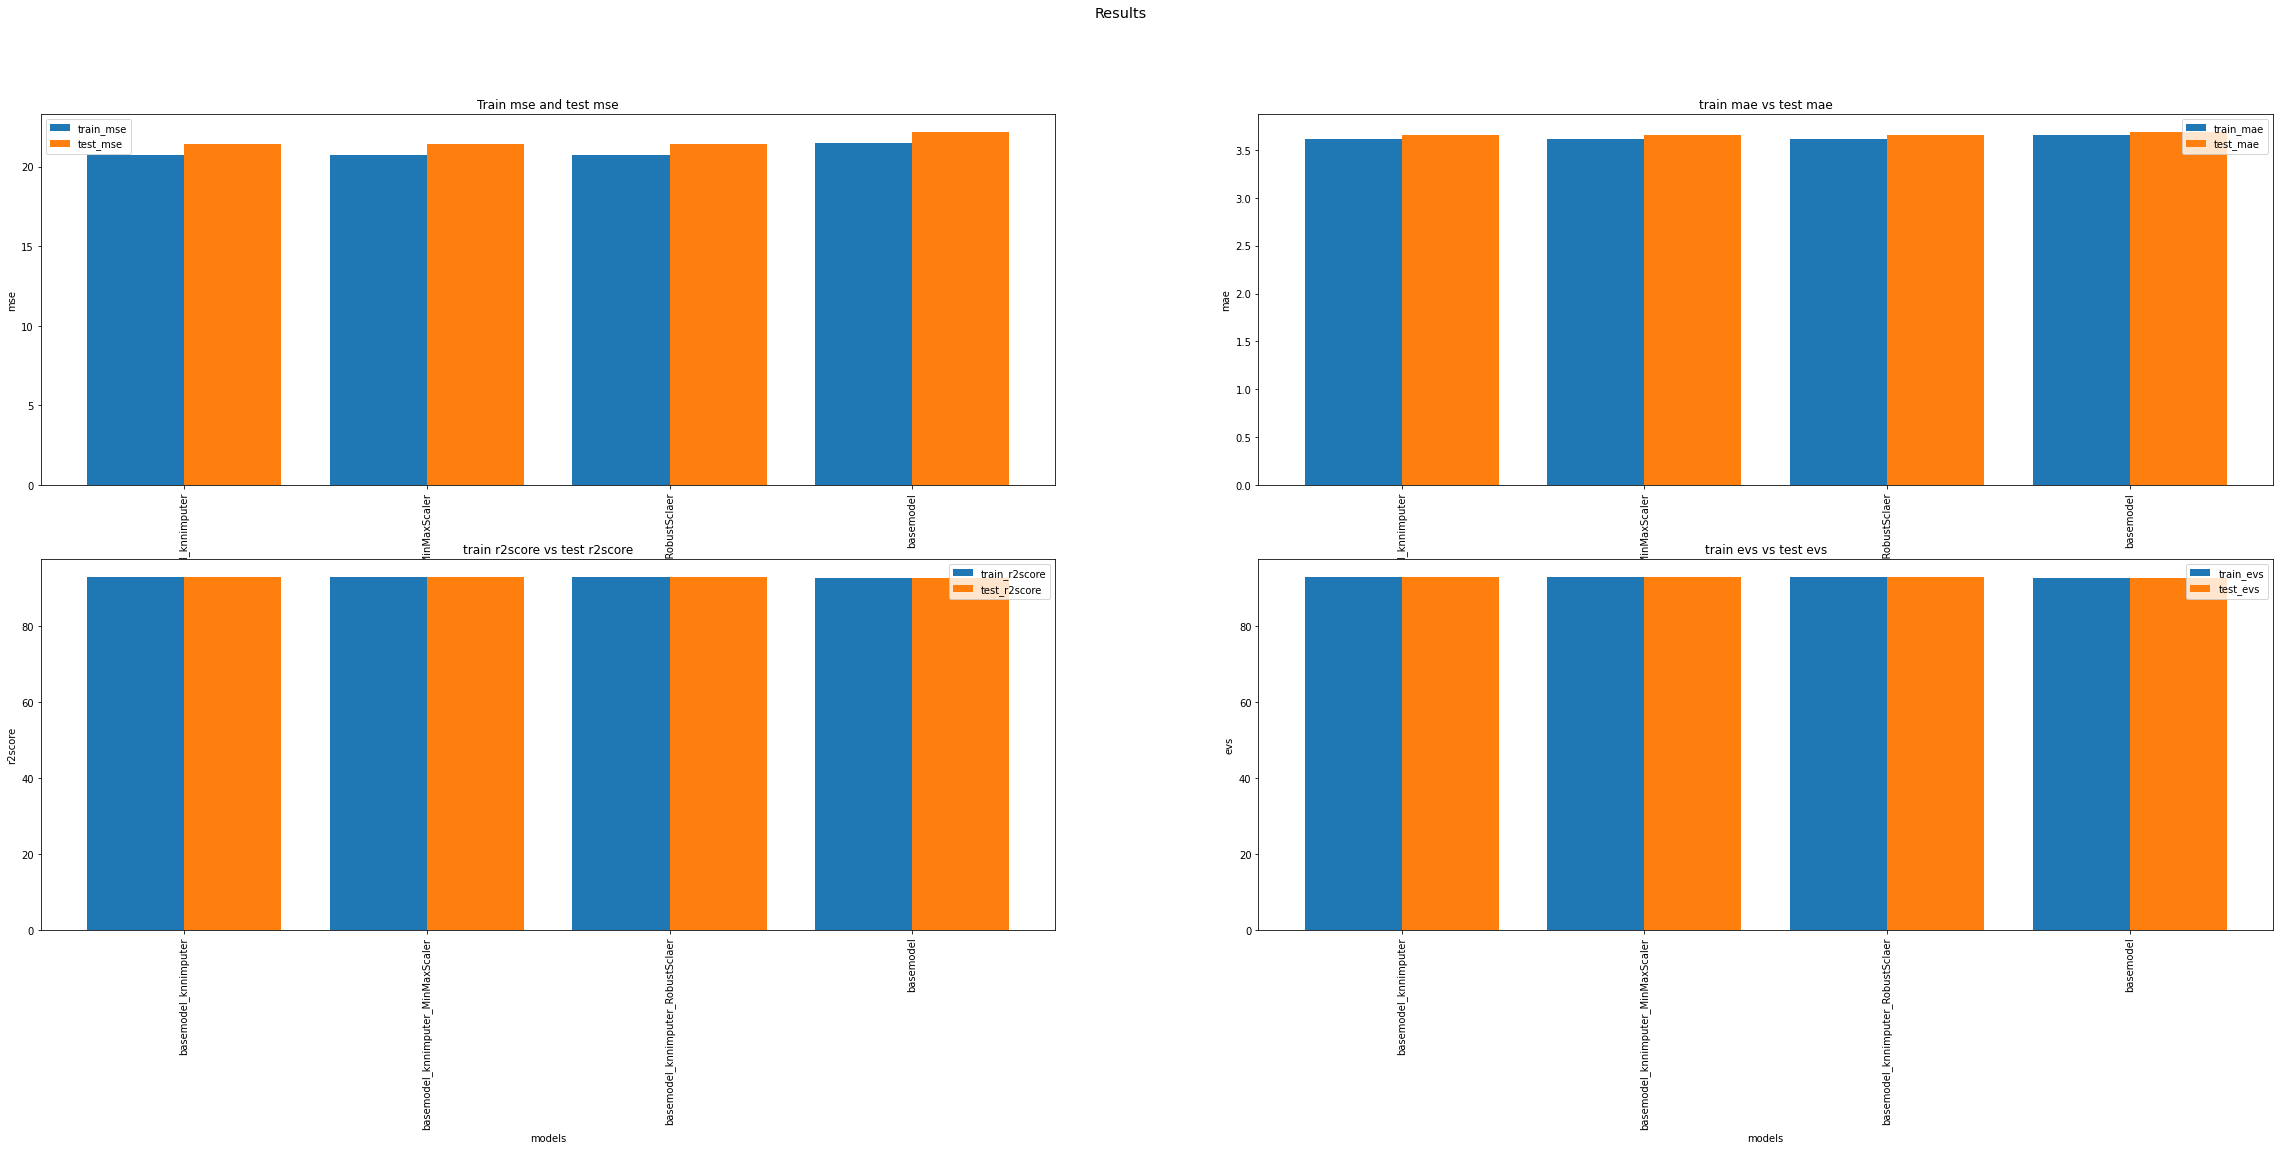

In [ ]:
show_results()

It can be seen that model with both variables RH and AP winozorized worked best in relation to all metrics except for 

## 2.3 Preprocessing Tuning

### -winsorize

In [ ]:
pipe_simple = define_pipeline_simple(RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2), True, True)
train_report_hist_pipe ("b_knn_RS_RH_AP_winsorize",LinearRegression(), pipe)

coefficient of determination: 0.9286539400864207
                        modelName     mse    mae     evs      r2
0  b_knn_RS_RH_AP_winsorize_train  20.721  3.618  92.865  92.865
1   b_knn_RS_RH_AP_winsorize_test  21.376  3.656  92.710  92.709


In [ ]:
pipe_simple = define_pipeline_simple(RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2), True, False)
train_report_hist_pipe ("b_knn_RS_RH_winsorize",LinearRegression(), pipe)

coefficient of determination: 0.9286288956547235
                     modelName     mse    mae     evs      r2
0  b_knn_RS_RH_winsorize_train  20.728  3.619  92.863  92.863
1   b_knn_RS_RH_winsorize_test  21.390  3.657  92.705  92.704


In [ ]:
pipe_simple = define_pipeline_simple(RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2), False, True)
train_report_hist_pipe ("b_knn_RS_AP_winsorize",LinearRegression(), pipe)

coefficient of determination: 0.9286551040352856
                     modelName     mse    mae     evs      r2
0  b_knn_RS_AP_winsorize_train  20.721  3.618  92.866  92.866
1   b_knn_RS_AP_winsorize_test  21.377  3.655  92.709  92.708


MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 
 
 
 
 3 
 b_knn_RS_RH_AP_winsorize 
 20.721 
 21.376 
 
 
 5 
 b_knn_RS_AP_winsorize 
 20.721 
 21.377 
 
 
 4 
 b_knn_RS_RH_winsorize 
 20.728 
 21.390 
 
 
 1 
 basemodel_knnimputer 
 20.728 
 21.391 
 
 
 2 
 basemodel_knnimputer_RobustSclaer 
 20.728 
 21.391 
 
 
 0 
 basemodel 
 21.448 
 22.164 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 
 
 
 
 5 
 b_knn_RS_AP_winsorize 
 3.618 
 3.655 
 
 
 3 
 b_knn_RS_RH_AP_winsorize 
 3.618 
 3.656 
 
 
 1 
 basemodel_knnimputer 
 3.619 
 3.657 
 
 
 2 
 basemodel_knnimputer_RobustSclaer 
 3.619 
 3.657 
 
 
 4 
 b_knn_RS_RH_winsorize 
 3.619 
 3.657 
 
 
 0 
 basemodel 
 3.659 
 3.687 
 
 
 
____
 
 r2score 
 
 
   
 modelName 
 train_r2score 
 test_r2score 
 
 
 
 
 3 
 b_knn_RS_RH_AP_winsorize 
 92.865 
 92.709 
 
 
 5 
 b_knn_RS_AP_winsorize 
 92.866 
 92.708 
 
 
 4 
 b_knn_RS_RH_winsorize 
 92.863 
 92.704 
 
 
 1 
 basemodel_knnimputer 
 92.863 
 92.703 
 
 
 2 
 basemodel_knnimputer_RobustSclaer 
 92.863 
 92.703 
 
 
 0 
 basemodel 
 92.615 
 92.440 
 
 
 
____
 
 EVS 
 
 
   
 modelName 
 train_evs 
 test_evs 
 
 
 
 
 3 
 b_knn_RS_RH_AP_winsorize 
 92.865 
 92.710 
 
 
 5 
 b_knn_RS_AP_winsorize 
 92.866 
 92.709 
 
 
 1 
 basemodel_knnimputer 
 92.863 
 92.705 
 
 
 2 
 basemodel_knnimputer_RobustSclaer 
 92.863 
 92.705 
 
 
 4 
 b_knn_RS_RH_winsorize 
 92.863 
 92.705 
 
 
 0 
 basemodel 
 92.615 
 92.441

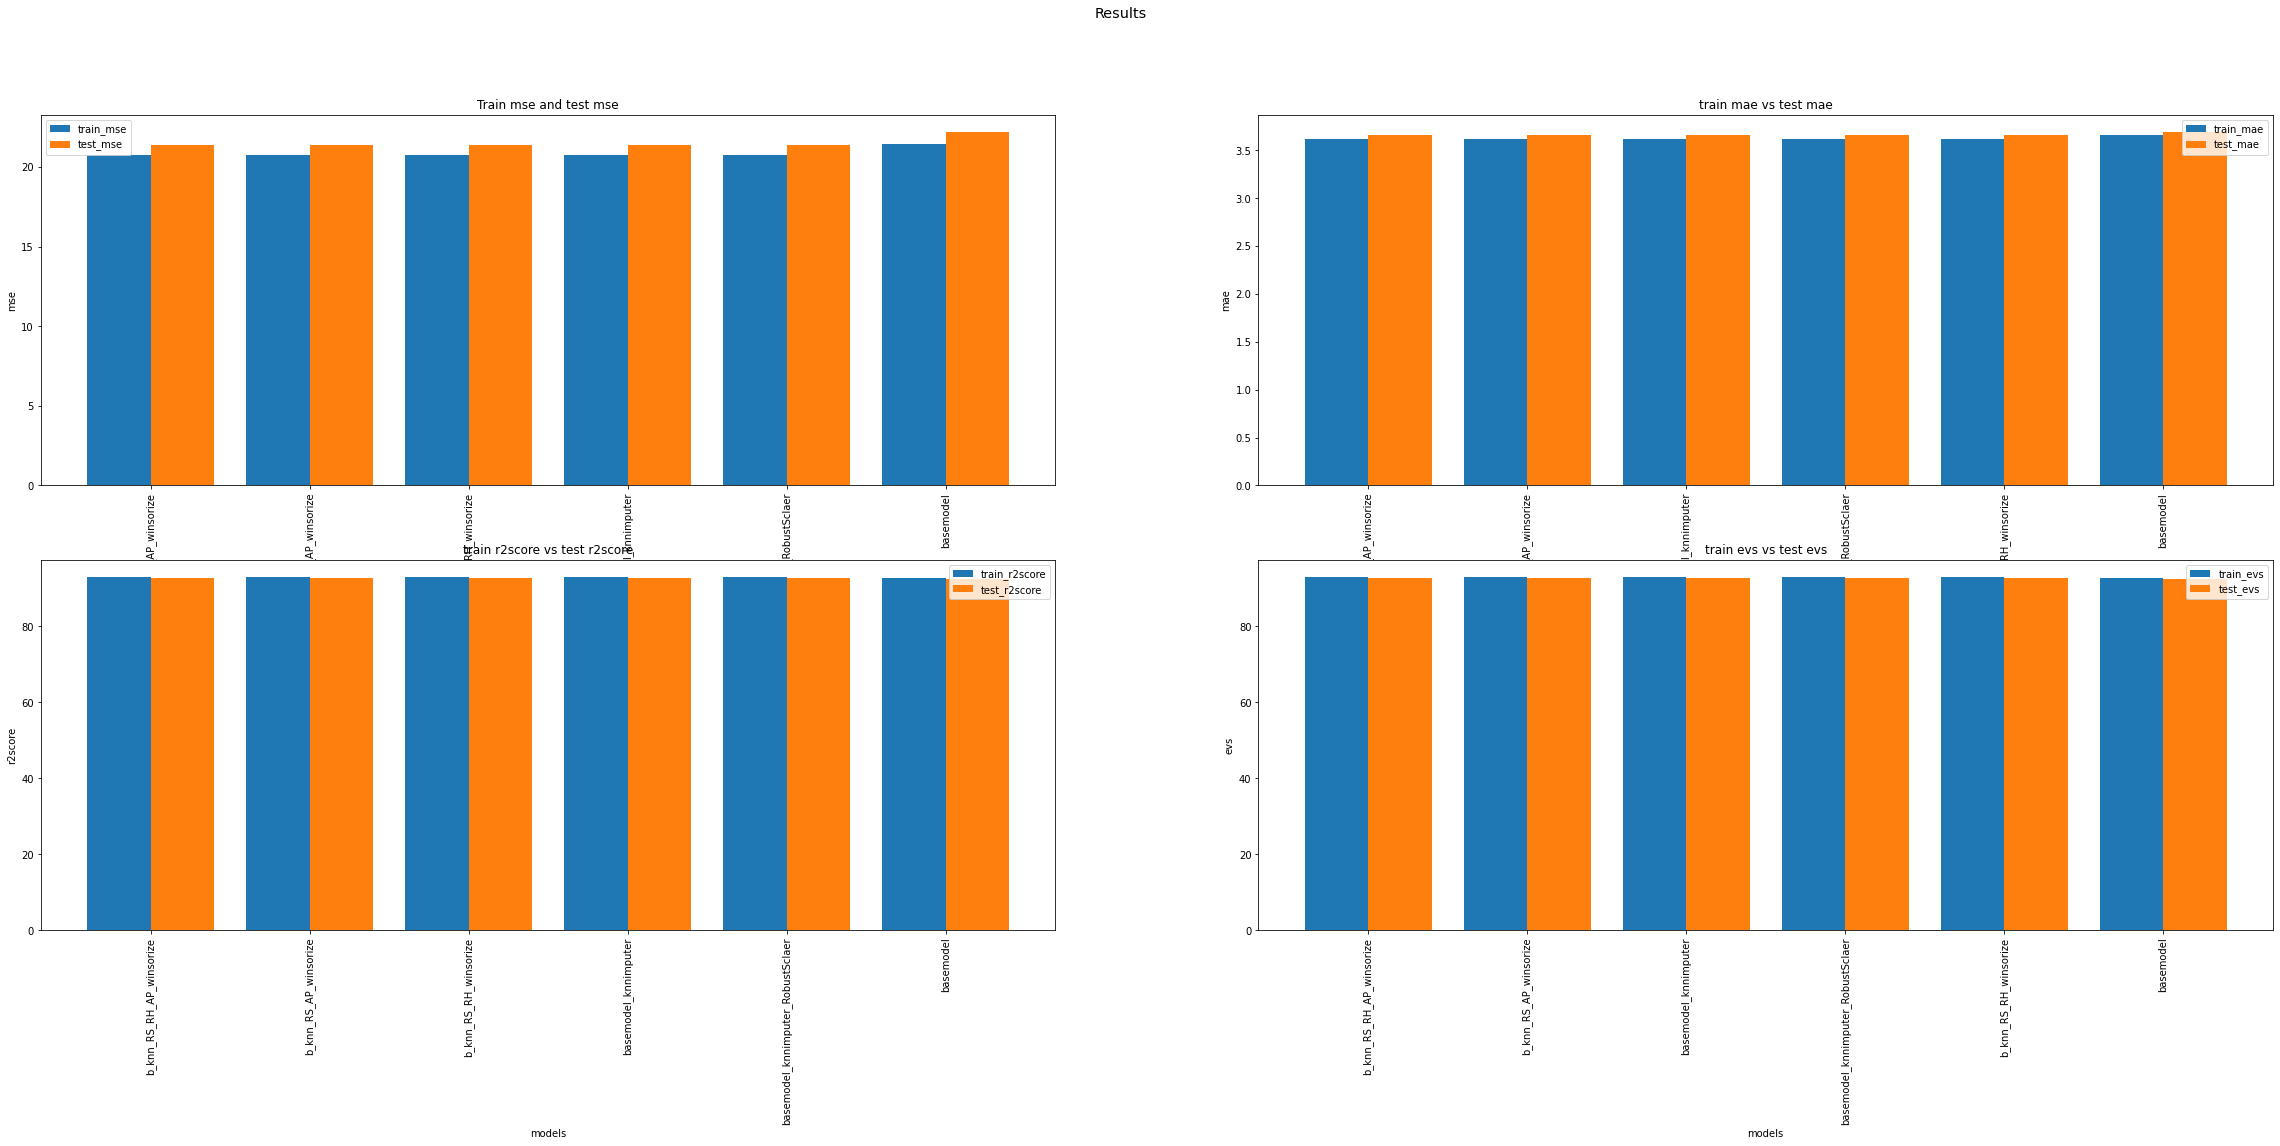

In [ ]:
show_results()

It can be seen that model with both variables RH and AP with treated outliers worked the best in all metrics except for MAE, it is the second best, but difference in 0.001 for test dataset can be neglected.
This modification will be trained further.

### -normalize

In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
bc_transformer = PowerTransformer(method = 'box-cox', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),bc_transformer, rcpr_transformer)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
train_report_hist_pipe ("b_knn_RS_RH_AP_winsorize_RCPR_BC",LinearRegression(), pipe)
pipe_complex

coefficient of determination: 0.9283085127258944
                                modelName     mse    mae     evs      r2
0  b_knn_RS_RH_AP_winsorize_RCPR_BC_train  20.821  3.620  92.831  92.831
1   b_knn_RS_RH_AP_winsorize_RCPR_BC_test  21.503  3.661  92.666  92.665


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('transformer_step',
                                                  PowerTransformer(method='box-cox',
                                                                   standardize=False)),
                                                 ('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('preprocess_step',
                                                  FunctionTransformer(func=<function <lambda> at 0x7f9c522d7c10>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['AP'])])

In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
train_report_hist_pipe ("b_knn_RS_RH_AP_winsorize_RCPR_YJ",LinearRegression(), pipe)
pipe_complex

coefficient of determination: 0.9283067413671923
                                modelName     mse    mae     evs      r2
0  b_knn_RS_RH_AP_winsorize_RCPR_YJ_train  20.822  3.620  92.831  92.831
1   b_knn_RS_RH_AP_winsorize_RCPR_YJ_test  21.504  3.661  92.666  92.665


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('transformer_step',
                                                  PowerTransformer(standardize=False)),
                                                 ('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('preprocess_step',
                                                  FunctionTransformer(func=<function <lambda> at 0x7f9c4d08eee0>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['AP'])])

In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
train_report_hist_pipe ("b_knn_RS_RH_AP_winsorize_RCPR_na",LinearRegression(), pipe)
pipe_complex

coefficient of determination: 0.9286577831185505
                                modelName     mse    mae     evs      r2
0  b_knn_RS_RH_AP_winsorize_RCPR_na_train  20.720  3.618  92.866  92.866
1   b_knn_RS_RH_AP_winsorize_RCPR_na_test  21.374  3.655  92.711  92.709


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('preprocess_step',
                                                  FunctionTransformer(func=<function <lambda> at 0x7fcd5fa69670>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['AP'])])

In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, True, False)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
train_report_hist_pipe ("b_knn_RS_RH_AP_winsorize_na_YJ",LinearRegression(), pipe)
pipe_complex

coefficient of determination: 0.9283030366202226
                              modelName     mse    mae     evs      r2
0  b_knn_RS_RH_AP_winsorize_na_YJ_train  20.823  3.620  92.830  92.830
1   b_knn_RS_RH_AP_winsorize_na_YJ_test  21.506  3.661  92.665  92.664


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('transformer_step',
                                                  PowerTransformer(standardize=False)),
                                                 ('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['AP'])])

In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
bc_transformer = PowerTransformer(method = 'box-cox', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),bc_transformer, rcpr_transformer, True, False)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
train_report_hist_pipe ("b_knn_RS_RH_AP_winsorize_na_BC",LinearRegression(), pipe)
pipe_complex

coefficient of determination: 0.9283048076807996
                              modelName     mse    mae     evs      r2
0  b_knn_RS_RH_AP_winsorize_na_BC_train  20.822  3.620  92.830  92.830
1   b_knn_RS_RH_AP_winsorize_na_BC_test  21.505  3.661  92.665  92.664


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('transformer_step',
                                                  PowerTransformer(method='box-cox',
                                                                   standardize=False)),
                                                 ('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['AP'])])

MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 
 
 
 
 8 
 b_knn_RS_RH_AP_winsorize_RCPR_na 
 20.720 
 21.374 
 
 
 3 
 b_knn_RS_RH_AP_winsorize 
 20.721 
 21.376 
 
 
 5 
 b_knn_RS_AP_winsorize 
 20.721 
 21.377 
 
 
 4 
 b_knn_RS_RH_winsorize 
 20.728 
 21.390 
 
 
 1 
 basemodel_knnimputer 
 20.728 
 21.391 
 
 
 2 
 basemodel_knnimputer_RobustSclaer 
 20.728 
 21.391 
 
 
 6 
 b_knn_RS_RH_AP_winsorize_RCPR_BC 
 20.821 
 21.503 
 
 
 7 
 b_knn_RS_RH_AP_winsorize_RCPR_YJ 
 20.822 
 21.504 
 
 
 10 
 b_knn_RS_RH_AP_winsorize_na_BC 
 20.822 
 21.505 
 
 
 9 
 b_knn_RS_RH_AP_winsorize_na_YJ 
 20.823 
 21.506 
 
 
 0 
 basemodel 
 21.448 
 22.164 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 
 
 
 
 5 
 b_knn_RS_AP_winsorize 
 3.618 
 3.655 
 
 
 8 
 b_knn_RS_RH_AP_winsorize_RCPR_na 
 3.618 
 3.655 
 
 
 3 
 b_knn_RS_RH_AP_winsorize 
 3.618 
 3.656 
 
 
 1 
 basemodel_knnimputer 
 3.619 
 3.657 
 
 
 2 
 basemodel_knnimputer_RobustSclaer 
 3.619 
 3.657 
 
 
 4 
 b_knn_RS_RH_winsorize 
 3.619 
 3.657 
 
 
 6 
 b_knn_RS_RH_AP_winsorize_RCPR_BC 
 3.620 
 3.661 
 
 
 7 
 b_knn_RS_RH_AP_winsorize_RCPR_YJ 
 3.620 
 3.661 
 
 
 9 
 b_knn_RS_RH_AP_winsorize_na_YJ 
 3.620 
 3.661 
 
 
 10 
 b_knn_RS_RH_AP_winsorize_na_BC 
 3.620 
 3.661 
 
 
 0 
 basemodel 
 3.659 
 3.687 
 
 
 
____
 
 r2score 
 
 
   
 modelName 
 train_r2score 
 test_r2score 
 
 
 
 
 3 
 b_knn_RS_RH_AP_winsorize 
 92.865 
 92.709 
 
 
 8 
 b_knn_RS_RH_AP_winsorize_RCPR_na 
 92.866 
 92.709 
 
 
 5 
 b_knn_RS_AP_winsorize 
 92.866 
 92.708 
 
 
 4 
 b_knn_RS_RH_winsorize 
 92.863 
 92.704 
 
 
 1 
 basemodel_knnimputer 
 92.863 
 92.703 
 
 
 2 
 basemodel_knnimputer_RobustSclaer 
 92.863 
 92.703 
 
 
 6 
 b_knn_RS_RH_AP_winsorize_RCPR_BC 
 92.831 
 92.665 
 
 
 7 
 b_knn_RS_RH_AP_winsorize_RCPR_YJ 
 92.831 
 92.665 
 
 
 9 
 b_knn_RS_RH_AP_winsorize_na_YJ 
 92.830 
 92.664 
 
 
 10 
 b_knn_RS_RH_AP_winsorize_na_BC 
 92.830 
 92.664 
 
 
 0 
 basemodel 
 92.615 
 92.440 
 
 
 
____
 
 EVS 
 
 
   
 modelName 
 train_evs 
 test_evs 
 
 
 
 
 8 
 b_knn_RS_RH_AP_winsorize_RCPR_na 
 92.866 
 92.711 
 
 
 3 
 b_knn_RS_RH_AP_winsorize 
 92.865 
 92.710 
 
 
 5 
 b_knn_RS_AP_winsorize 
 92.866 
 92.709 
 
 
 1 
 basemodel_knnimputer 
 92.863 
 92.705 
 
 
 2 
 basemodel_knnimputer_RobustSclaer 
 92.863 
 92.705 
 
 
 4 
 b_knn_RS_RH_winsorize 
 92.863 
 92.705 
 
 
 6 
 b_knn_RS_RH_AP_winsorize_RCPR_BC 
 92.831 
 92.666 
 
 
 7 
 b_knn_RS_RH_AP_winsorize_RCPR_YJ 
 92.831 
 92.666 
 
 
 9 
 b_knn_RS_RH_AP_winsorize_na_YJ 
 92.830 
 92.665 
 
 
 10 
 b_knn_RS_RH_AP_winsorize_na_BC 
 92.830 
 92.665 
 
 
 0 
 basemodel 
 92.615 
 92.441

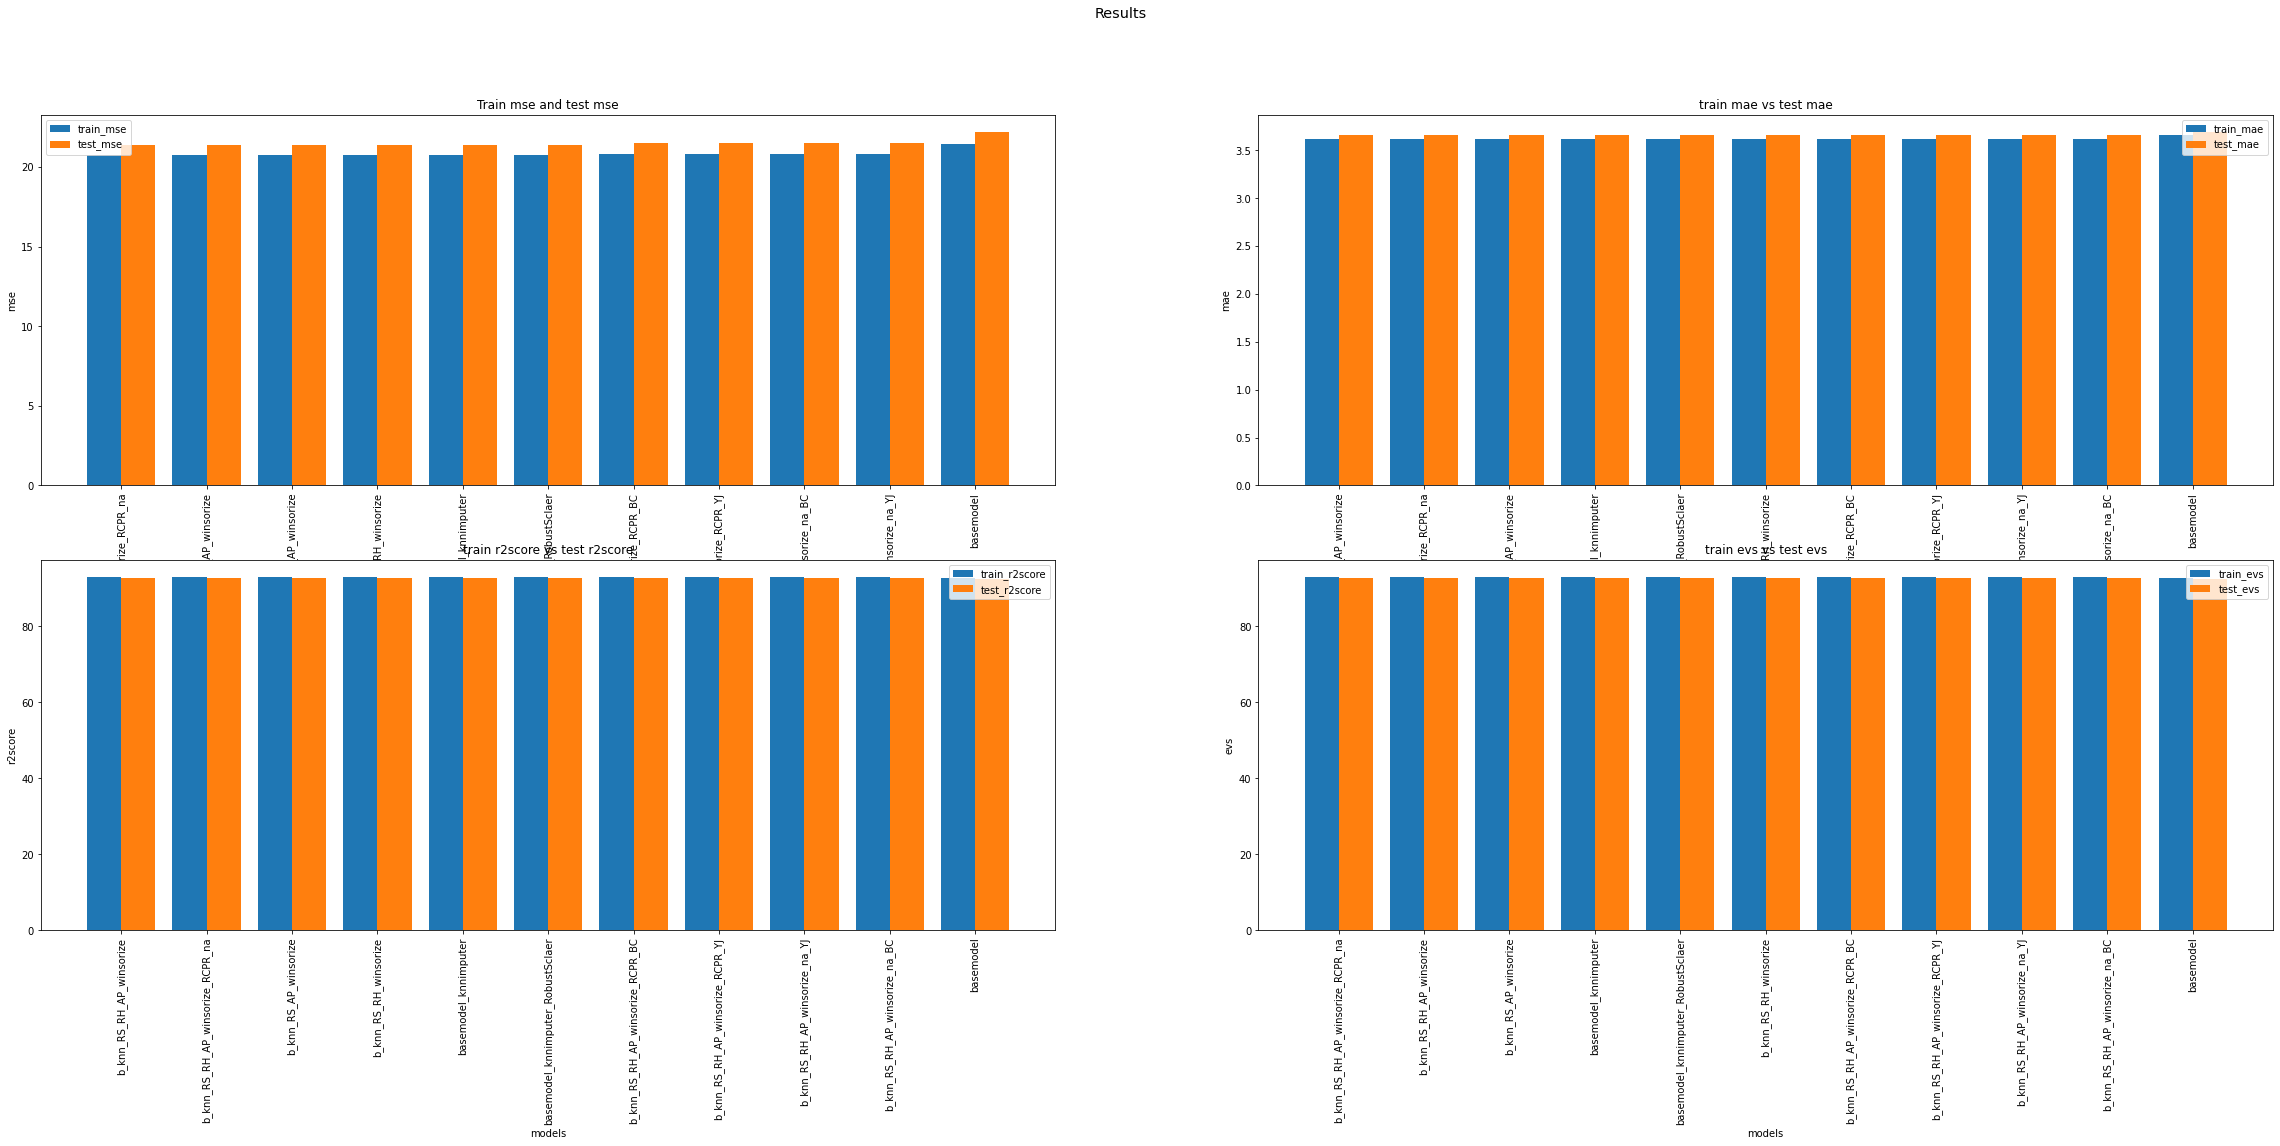

In [ ]:
show_results()

It can be seen that model with AP normalized variable and both AP and RH transfromed variables variables has shown best results. It will be further trained.

#3.ML model development

## 3.1 Regressor

### Lasso

In [ ]:
pipe_simple = define_pipeline_simple(RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2), True, True)
y_train = y_train.ravel()
lasso = linear_model.Lasso(alpha=0.1)
train_report_hist_pipe ("b_Lasso_knn_RS_RH_AP_winsorize",lasso, pipe)

coefficient of determination: 0.8254933977267015
                              modelName     mse   mae     evs      r2
0  b_Lasso_knn_RS_RH_AP_winsorize_train  50.682  5.86  82.549  82.549
1   b_Lasso_knn_RS_RH_AP_winsorize_test  50.413  5.86  82.804  82.804


In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
y_train = y_train.ravel()
lasso = linear_model.Lasso(alpha=0.1)
train_report_hist_pipe ("b_Lasso_knn_RS_RH_AP_winsorize_RCPR_na_Logistic",lasso, pipe)
pipe_complex

coefficient of determination: 0.8254933977267015
                                           modelName     mse   mae     evs  \
0  b_Lasso_knn_RS_RH_AP_winsorize_RCPR_na_Logisti...  50.682  5.86  82.549   
1  b_Lasso_knn_RS_RH_AP_winsorize_RCPR_na_Logisti...  50.413  5.86  82.804   

       r2  
0  82.549  
1  82.804  


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('preprocess_step',
                                                  FunctionTransformer(func=<function <lambda> at 0x7f9c4a9a0280>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['AP'])])

### SVR

In [ ]:
pipe_simple = define_pipeline_simple(RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2), True, True)
y_train = y_train.ravel()
train_report_hist_pipe ("b_SVR_knn_RS_RH_AP_winsorize",SVR(), pipe)

coefficient of determination: 0.9455167283630047
                            modelName     mse    mae     evs      r2
0  b_SVR_knn_RS_RH_AP_winsorize_train  15.823  3.030  94.553  94.552
1   b_SVR_knn_RS_RH_AP_winsorize_test  16.483  3.106  94.378  94.378


In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
y_train = y_train.ravel()
train_report_hist_pipe ("b_SVR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic",SVR(), pipe)
pipe_complex

coefficient of determination: 0.9455199976977026
                                           modelName     mse    mae     evs  \
0  b_SVR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic_...  15.823  3.030  94.553   
1  b_SVR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic_...  16.486  3.106  94.377   

       r2  
0  94.552  
1  94.377  


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('preprocess_step',
                                                  FunctionTransformer(func=<function <lambda> at 0x7f9c4a9a0550>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['AP'])])

### DecisionTree

In [ ]:
pipe_simple = define_pipeline_simple(RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2), True, True)
y_train = y_train.ravel()
train_report_hist_pipe ("b_DTR_knn_RS_RH_AP_winsorize",DecisionTreeRegressor(), pipe)

coefficient of determination: 1.0
                            modelName     mse    mae      evs       r2
0  b_DTR_knn_RS_RH_AP_winsorize_train   0.000  0.000  100.000  100.000
1   b_DTR_knn_RS_RH_AP_winsorize_test  21.861  3.215   92.544   92.543


In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
y_train = y_train.ravel()
train_report_hist_pipe ("b_DTR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic",DecisionTreeRegressor(), pipe)
pipe_complex

coefficient of determination: 1.0
                                           modelName     mse    mae      evs  \
0  b_DTR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic_...   0.000  0.000  100.000   
1  b_DTR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic_...  21.772  3.198   92.578   

        r2  
0  100.000  
1   92.573  


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('preprocess_step',
                                                  FunctionTransformer(func=<function <lambda> at 0x7f9c4a9a0670>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['AP'])])

### RandomForest

In [ ]:
pipe_simple = define_pipeline_simple(RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2), True, True)
y_train = y_train.ravel()
train_report_hist_pipe ("b_RFR_knn_RS_RH_AP_winsorize",RandomForestRegressor(), pipe)

coefficient of determination: 0.9942283612268242
                            modelName     mse    mae     evs      r2
0  b_RFR_knn_RS_RH_AP_winsorize_train   1.676  0.913  99.423  99.423
1   b_RFR_knn_RS_RH_AP_winsorize_test  11.648  2.441  96.027  96.027


In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
y_train = y_train.ravel()
train_report_hist_pipe ("b_RFR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic",RandomForestRegressor(), pipe)
pipe_complex

coefficient of determination: 0.9941803786507566
                                           modelName     mse    mae     evs  \
0  b_RFR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic_...   1.690  0.915  99.418   
1  b_RFR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic_...  11.694  2.447  96.011   

       r2  
0  99.418  
1  96.011  


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('preprocess_step',
                                                  FunctionTransformer(func=<function <lambda> at 0x7f9c4ab30af0>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['AP'])])

### GradientBoostRegressor

In [ ]:
pipe_simple = define_pipeline_simple(RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=2), True, True)
y_train = y_train.ravel()
train_report_hist_pipe ("b_GBR_knn_RS_RH_AP_winsorize",GradientBoostingRegressor(), pipe)

coefficient of determination: 0.952786223975461
                            modelName     mse    mae     evs      r2
0  b_GBR_knn_RS_RH_AP_winsorize_train  13.712  2.815  95.279  95.279
1   b_GBR_knn_RS_RH_AP_winsorize_test  15.587  2.991  94.683  94.683


In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=2), True, True)
y_train = y_train.ravel()
train_report_hist_pipe ("b_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic",GradientBoostingRegressor(), pipe)
pipe_complex

coefficient of determination: 0.952786223975461
                                           modelName     mse    mae     evs  \
0  b_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic_...  13.712  2.815  95.279   
1  b_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic_...  15.585  2.991  94.684   

       r2  
0  95.279  
1  94.684  


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('preprocess_step',
                                                  FunctionTransformer(func=<function <lambda> at 0x7fcd5f9354c0>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['AP'])])

MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 
 
 
 
 10 
 b_RFR_knn_RS_RH_AP_winsorize 
 1.676 
 11.648 
 
 
 11 
 b_RFR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 1.690 
 11.694 
 
 
 13 
 b_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 13.712 
 15.585 
 
 
 12 
 b_GBR_knn_RS_RH_AP_winsorize 
 13.712 
 15.587 
 
 
 6 
 b_SVR_knn_RS_RH_AP_winsorize 
 15.823 
 16.483 
 
 
 7 
 b_SVR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 15.823 
 16.486 
 
 
 3 
 b_knn_RS_RH_AP_winsorize_RCPR_na 
 20.720 
 21.374 
 
 
 2 
 b_knn_RS_RH_AP_winsorize 
 20.721 
 21.376 
 
 
 0 
 basemodel_knnimputer 
 20.728 
 21.391 
 
 
 1 
 basemodel_knnimputer_RobustSclaer 
 20.728 
 21.391 
 
 
 9 
 b_DTR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 0.000 
 21.772 
 
 
 8 
 b_DTR_knn_RS_RH_AP_winsorize 
 0.000 
 21.861 
 
 
 4 
 b_Lasso_knn_RS_RH_AP_winsorize 
 50.682 
 50.413 
 
 
 5 
 b_Lasso_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 50.682 
 50.413 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 
 
 
 
 10 
 b_RFR_knn_RS_RH_AP_winsorize 
 0.913 
 2.441 
 
 
 11 
 b_RFR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 0.915 
 2.447 
 
 
 12 
 b_GBR_knn_RS_RH_AP_winsorize 
 2.815 
 2.991 
 
 
 13 
 b_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 2.815 
 2.991 
 
 
 6 
 b_SVR_knn_RS_RH_AP_winsorize 
 3.030 
 3.106 
 
 
 7 
 b_SVR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 3.030 
 3.106 
 
 
 9 
 b_DTR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 0.000 
 3.198 
 
 
 8 
 b_DTR_knn_RS_RH_AP_winsorize 
 0.000 
 3.215 
 
 
 3 
 b_knn_RS_RH_AP_winsorize_RCPR_na 
 3.618 
 3.655 
 
 
 2 
 b_knn_RS_RH_AP_winsorize 
 3.618 
 3.656 
 
 
 0 
 basemodel_knnimputer 
 3.619 
 3.657 
 
 
 1 
 basemodel_knnimputer_RobustSclaer 
 3.619 
 3.657 
 
 
 4 
 b_Lasso_knn_RS_RH_AP_winsorize 
 5.860 
 5.860 
 
 
 5 
 b_Lasso_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 5.860 
 5.860 
 
 
 
____
 
 r2score 
 
 
   
 modelName 
 train_r2score 
 test_r2score 
 
 
 
 
 10 
 b_RFR_knn_RS_RH_AP_winsorize 
 99.423 
 96.027 
 
 
 11 
 b_RFR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 99.418 
 96.011 
 
 
 13 
 b_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 95.279 
 94.684 
 
 
 12 
 b_GBR_knn_RS_RH_AP_winsorize 
 95.279 
 94.683 
 
 
 6 
 b_SVR_knn_RS_RH_AP_winsorize 
 94.552 
 94.378 
 
 
 7 
 b_SVR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 94.552 
 94.377 
 
 
 2 
 b_knn_RS_RH_AP_winsorize 
 92.865 
 92.709 
 
 
 3 
 b_knn_RS_RH_AP_winsorize_RCPR_na 
 92.866 
 92.709 
 
 
 0 
 basemodel_knnimputer 
 92.863 
 92.703 
 
 
 1 
 basemodel_knnimputer_RobustSclaer 
 92.863 
 92.703 
 
 
 9 
 b_DTR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 100.000 
 92.573 
 
 
 8 
 b_DTR_knn_RS_RH_AP_winsorize 
 100.000 
 92.543 
 
 
 4 
 b_Lasso_knn_RS_RH_AP_winsorize 
 82.549 
 82.804 
 
 
 5 
 b_Lasso_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 82.549 
 82.804 
 
 
 
____
 
 EVS 
 
 
   
 modelName 
 train_evs 
 test_evs 
 
 
 
 
 10 
 b_RFR_knn_RS_RH_AP_winsorize 
 99.423 
 96.027 
 
 
 11 
 b_RFR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 99.418 
 96.011 
 
 
 13 
 b_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 95.279 
 94.684 
 
 
 12 
 b_GBR_knn_RS_RH_AP_winsorize 
 95.279 
 94.683 
 
 
 6 
 b_SVR_knn_RS_RH_AP_winsorize 
 94.553 
 94.378 
 
 
 7 
 b_SVR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 94.553 
 94.377 
 
 
 3 
 b_knn_RS_RH_AP_winsorize_RCPR_na 
 92.866 
 92.711 
 
 
 2 
 b_knn_RS_RH_AP_winsorize 
 92.865 
 92.710 
 
 
 0 
 basemodel_knnimputer 
 92.863 
 92.705 
 
 
 1 
 basemodel_knnimputer_RobustSclaer 
 92.863 
 92.705 
 
 
 9 
 b_DTR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 100.000 
 92.578 
 
 
 8 
 b_DTR_knn_RS_RH_AP_winsorize 
 100.000 
 92.544 
 
 
 4 
 b_Lasso_knn_RS_RH_AP_winsorize 
 82.549 
 82.804 
 
 
 5 
 b_Lasso_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 82.549 
 82.804

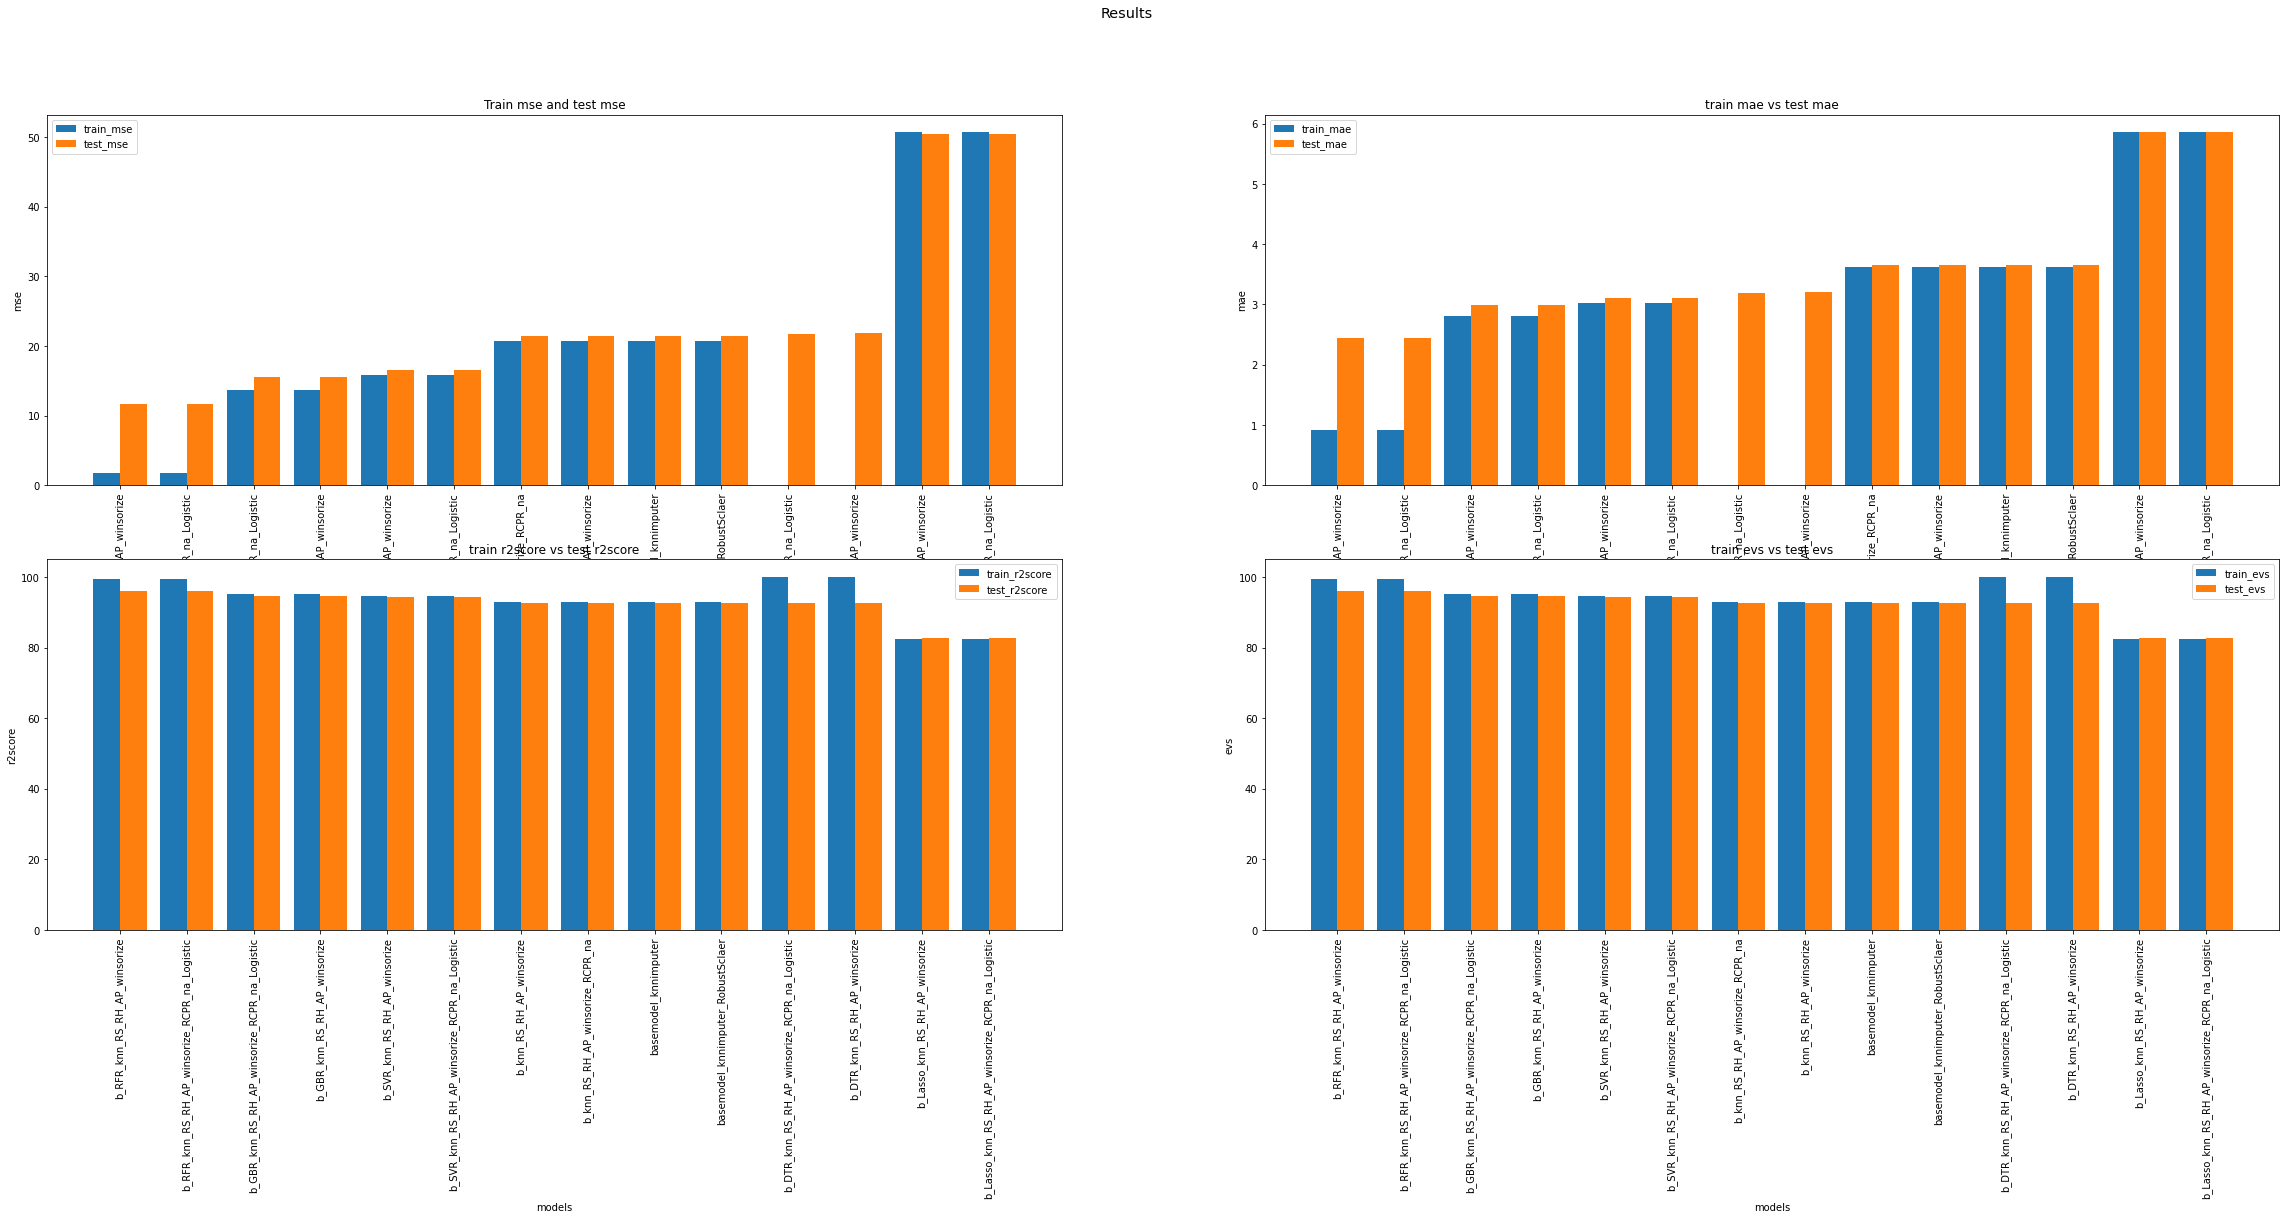

In [ ]:
show_results()

It can be seen that the most optimal model is trained with Gradient Boost Regressor

## 3.2 GridSearch

### - Grid Search GBR

In [ ]:
X = pp_dataset.iloc[:, :-1].values
y= pp_dataset.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
y_test_orig, y_train_orig = y_test, y_train

cols = ['AT', 'V', 'AP', 'RH']

X_train_i = winsorize_nparray(X_train, 3,  0.00135, 0)
X_test_i = winsorize_nparray(X_test, 3,  0.00135, 0)
X_train_i= winsorize_nparray(X_train, 2,  0.00165, 0.015)
X_test_i= winsorize_nparray(X_test, 2,  0.00165, 0.015)
cols = ['AT', 'V', 'RH', 'AP']

X_train_i = pd.DataFrame(X_train_i, columns = cols)
X_test_i = pd.DataFrame(X_test_i, columns = cols)

In [ ]:
est =Pipeline(steps =[
              ('imp', KNNImputer()),
               ('stsc', RobustScaler()),
               ('reg', GradientBoostingRegressor())])

In [ ]:
parameters = {
    'imp__n_neighbors': [200, 190, 210],
    'reg__learning_rate': [0.027,0.025,0.03,0.035],
    'reg__subsample'    : [0.9, 0.8, 0.5],
    'reg__n_estimators' : [2100, 2500,2000],
    'reg__max_depth'    : [6,5,4]
                 }

In [ ]:
grid_GBR = GridSearchCV(estimator=est, param_grid = parameters, cv = 2, n_jobs=-1, scoring = 'r2')
grid_GBR.fit(X_train_i, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imp', KNNImputer()),
                                       ('stsc', RobustScaler()),
                                       ('reg', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'imp__n_neighbors': [200, 190, 210],
                         'reg__learning_rate': [0.027, 0.025, 0.03, 0.035],
                         'reg__max_depth': [6, 5, 4],
                         'reg__n_estimators': [2100, 2500, 2000],
                         'reg__subsample': [0.9, 0.8, 0.5]},
             scoring='r2')

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('imp', KNNImputer(n_neighbors=210)), ('stsc', RobustScaler()),
                ('reg',
                 GradientBoostingRegressor(learning_rate=0.025, max_depth=6,
                                           n_estimators=2100, subsample=0.8))])

 The best score across ALL searched params:
 0.9600930853244519

 The best parameters across ALL searched params:
 {'imp__n_neighbors': 210, 'reg__learning_rate': 0.025, 'reg__max_depth': 6, 'reg__n_estimators': 2100, 'reg__subsample': 0.8}


In [ ]:
pipe_simple = define_pipeline_simple(RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=210), True, True)
y_train = y_train.ravel()
train_report_hist_pipe ("b_grid_GBR_knn_RS_RH_AP_winsorize",GradientBoostingRegressor(learning_rate=0.025, max_depth=6,n_estimators=2100, subsample=0.8), pipe)

coefficient of determination: 0.9961588465755545
                                 modelName    mse    mae     evs      r2
0  b_grid_GBR_knn_RS_RH_AP_winsorize_train  1.116  0.833  99.616  99.616
1   b_grid_GBR_knn_RS_RH_AP_winsorize_test  9.137  2.132  96.885  96.883


### - Grid Search SVR

In [ ]:
X = pp_dataset.iloc[:, :-1].values
y= pp_dataset.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
y_test_orig, y_train_orig = y_test, y_train

cols = ['AT', 'V', 'AP', 'RH']

X_train_i = winsorize_nparray(X_train, 3,  0.00135, 0)
X_test_i = winsorize_nparray(X_test, 3,  0.00135, 0)
X_train_i= winsorize_nparray(X_train, 2,  0.00165, 0.015)
X_test_i= winsorize_nparray(X_test, 2,  0.00165, 0.015)
cols = ['AT', 'V', 'RH', 'AP']

X_train_i = pd.DataFrame(X_train_i, columns = cols)
X_test_i = pd.DataFrame(X_test_i, columns = cols)

In [ ]:
est =Pipeline(steps =[
              ('imp', KNNImputer()),
               ('stsc', RobustScaler()),
               ('reg', SVR())])

In [ ]:
parameters = {
    'imp__n_neighbors': [150,155, 145],
    'reg__kernel': ['linear', 'rbf','poly'],
    'reg__C'    : [1.5, 1.6, 1.4],
    'reg__gamma' : [1e-07, 1e-08, 1e-09],
    'reg__epsilon'    : [4, 5, 7, 9]
                 }

In [ ]:
grid_SVR = GridSearchCV(estimator=est, param_grid = parameters, cv = 2, n_jobs=-1, scoring = 'r2')
grid_SVR.fit(X_train_i, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imp', KNNImputer()),
                                       ('stsc', RobustScaler()),
                                       ('reg', SVR())]),
             n_jobs=-1,
             param_grid={'imp__n_neighbors': [150, 155, 145],
                         'reg__C': [1.5, 1.6, 1.4],
                         'reg__epsilon': [4, 5, 7, 9],
                         'reg__gamma': [1e-07, 1e-08, 1e-09],
                         'reg__kernel': ['linear', 'rbf', 'poly']},
             scoring='r2')

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_SVR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_SVR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_SVR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('imp', KNNImputer(n_neighbors=150)), ('stsc', RobustScaler()),
                ('reg', SVR(C=1.6, epsilon=4, gamma=1e-07, kernel='linear'))])

 The best score across ALL searched params:
 0.9283954741104401

 The best parameters across ALL searched params:
 {'imp__n_neighbors': 150, 'reg__C': 1.6, 'reg__epsilon': 4, 'reg__gamma': 1e-07, 'reg__kernel': 'linear'}


In [ ]:
pipe_simple = define_pipeline_simple(RobustScaler())
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_simple, KNNImputer(n_neighbors=190), True, True)
y_train = y_train.ravel()
train_report_hist_pipe ("b_SVR_knn_RS_RH_AP_winsorize",SVR(C = 1.5), pipe)

### - Grid Search GBR w. tranformation

In [ ]:
X = pp_dataset.iloc[:, :-1].values
y= pp_dataset.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
y_test_orig, y_train_orig = y_test, y_train

cols = ['AT', 'V', 'AP', 'RH']

X_train_i = winsorize_nparray(X_train, 3,  0.00135, 0)
X_test_i = winsorize_nparray(X_test, 3,  0.00135, 0)
X_train_i= winsorize_nparray(X_train, 2,  0.00165, 0.015)
X_test_i= winsorize_nparray(X_test, 2,  0.00165, 0.015)
cols = ['AT', 'V', 'RH', 'AP']

X_train_i = pd.DataFrame(X_train_i, columns = cols)
X_test_i = pd.DataFrame(X_test_i, columns = cols)

In [ ]:
rh_pipe = Pipeline([('imp', KNNImputer(n_neighbors=210)),
                    ('transf', PowerTransformer(method = 'yeo-johnson', standardize = False)),
                    ('scaler', RobustScaler())])

ap_pipe = Pipeline([('imp', KNNImputer(n_neighbors=210)),
                    ('transf', FunctionTransformer(lambda x: 1/x, validate = True)),
                    ('scaler', RobustScaler())])

simple_pipe = Pipeline([('imp', KNNImputer(n_neighbors=210)),
                        ('scaler', RobustScaler())]) 
                     
preprocessor = ColumnTransformer(transformers = 
                                 [("RH_col"  , rh_pipe  , ["RH"]),
                                  ("AP_col", ap_pipe, ["AP"])],
                                 remainder = simple_pipe
                                 )
est = Pipeline(steps = [('preprocessor', preprocessor),
                         ('reg', GradientBoostingRegressor())])

In [ ]:
parameters = {
    'reg__learning_rate': [0.027,0.025,0.020],
    'reg__subsample'    : [0.9, 0.8, 0.5],
    'reg__n_estimators' : [2100, 2500,2000],
    'reg__max_depth'    : [8,6,4]
                 }

In [ ]:
grid_GBR_plus = GridSearchCV(estimator=est, param_grid = parameters, cv = 2, n_jobs=-1, scoring = 'r2')
grid_GBR_plus.fit(X_train_i, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder=Pipeline(steps=[('imp',
                                                                                     KNNImputer(n_neighbors=210)),
                                                                                    ('scaler',
                                                                                     RobustScaler())]),
                                                          transformers=[('RH_col',
                                                                         Pipeline(steps=[('imp',
                                                                                          KNNImputer(n_neighbors=210)),
                                                                                         ('transf',
                                                                                          PowerTransformer(standardize=False)),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['RH']),
                                                                        ('AP_col',
                                                                         Pipeline(step...
                                                                                          KNNImputer(n_neighbors=210)),
                                                                                         ('transf',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7fe3d6ad2940>,
                                                                                                              validate=True)),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['AP'])])),
                                       ('reg', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'reg__learning_rate': [0.027, 0.025, 0.02],
                         'reg__max_depth': [8, 6, 4],
                         'reg__n_estimators': [2100, 2500, 2000],
                         'reg__subsample': [0.9, 0.8, 0.5]},
             scoring='r2')

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR_plus.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR_plus.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR_plus.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=Pipeline(steps=[('imp',
                                                              KNNImputer(n_neighbors=210)),
                                                             ('scaler',
                                                              RobustScaler())]),
                                   transformers=[('RH_col',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer(n_neighbors=210)),
                                                                  ('transf',
                                                                   PowerTransformer(standardize=False)),
                                                                  ('scaler',
                                                                   RobustScaler())]),


In [ ]:
rcpr_transformer = FunctionTransformer(lambda x: 1/x, validate = True)
yj_transformer = PowerTransformer(method = 'yeo-johnson', standardize = False)

pipe_complex = define_pipeline_complex(RobustScaler(),yj_transformer, rcpr_transformer, False, True)
X_train, X_test, y_train, y_test, pipe,  y_test_orig, y_train_orig = split_impute_scale_pipe (pp_dataset, pipe_complex, KNNImputer(n_neighbors=210), True, True)
y_train = y_train.ravel()
train_report_hist_pipe ("b_greed_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic",GradientBoostingRegressor(learning_rate=0.027, max_depth=6,n_estimators=2100, subsample=0.80------------), pipe)
pipe_complex

coefficient of determination: 0.9974305505579888
                                           modelName    mse    mae     evs  \
0  b_greed_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Log...  0.746  0.679  99.743   
1  b_greed_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Log...  9.027  2.100  96.922   

       r2  
0  99.743  
1  96.921  


ColumnTransformer(remainder=Pipeline(steps=[('scaler', RobustScaler())]),
                  transformers=[('RH_col',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['RH']),
                                ('AP_col',
                                 Pipeline(steps=[('preprocess_step',
                                                  FunctionTransformer(func=<function <lambda> at 0x7fcdc79c04c0>,
                                                                      validate=True)),
                                                 ('scaler', RobustScaler())]),
                                 ['AP'])])

## 3.3 ML Results

MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 
 
 
 
 8 
 b_greed_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 0.746 
 9.027 
 
 
 7 
 b_grid_GBR_knn_RS_RH_AP_winsorize 
 1.116 
 9.137 
 
 
 6 
 b_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 13.712 
 15.585 
 
 
 5 
 b_GBR_knn_RS_RH_AP_winsorize 
 13.712 
 15.587 
 
 
 4 
 b_knn_RS_RH_AP_winsorize_RCPR_na 
 20.720 
 21.374 
 
 
 3 
 b_knn_RS_RH_AP_winsorize 
 20.721 
 21.376 
 
 
 1 
 basemodel_knnimputer 
 20.728 
 21.391 
 
 
 2 
 basemodel_knnimputer_RobustSclaer 
 20.728 
 21.391 
 
 
 0 
 basemodel 
 21.448 
 22.164 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 
 
 
 
 8 
 b_greed_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 0.679 
 2.100 
 
 
 7 
 b_grid_GBR_knn_RS_RH_AP_winsorize 
 0.833 
 2.132 
 
 
 5 
 b_GBR_knn_RS_RH_AP_winsorize 
 2.815 
 2.991 
 
 
 6 
 b_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 2.815 
 2.991 
 
 
 4 
 b_knn_RS_RH_AP_winsorize_RCPR_na 
 3.618 
 3.655 
 
 
 3 
 b_knn_RS_RH_AP_winsorize 
 3.618 
 3.656 
 
 
 1 
 basemodel_knnimputer 
 3.619 
 3.657 
 
 
 2 
 basemodel_knnimputer_RobustSclaer 
 3.619 
 3.657 
 
 
 0 
 basemodel 
 3.659 
 3.687 
 
 
 
____
 
 r2score 
 
 
   
 modelName 
 train_r2score 
 test_r2score 
 
 
 
 
 8 
 b_greed_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 99.743 
 96.921 
 
 
 7 
 b_grid_GBR_knn_RS_RH_AP_winsorize 
 99.616 
 96.883 
 
 
 6 
 b_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 95.279 
 94.684 
 
 
 5 
 b_GBR_knn_RS_RH_AP_winsorize 
 95.279 
 94.683 
 
 
 3 
 b_knn_RS_RH_AP_winsorize 
 92.865 
 92.709 
 
 
 4 
 b_knn_RS_RH_AP_winsorize_RCPR_na 
 92.866 
 92.709 
 
 
 1 
 basemodel_knnimputer 
 92.863 
 92.703 
 
 
 2 
 basemodel_knnimputer_RobustSclaer 
 92.863 
 92.703 
 
 
 0 
 basemodel 
 92.615 
 92.440 
 
 
 
____
 
 EVS 
 
 
   
 modelName 
 train_evs 
 test_evs 
 
 
 
 
 8 
 b_greed_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 99.743 
 96.922 
 
 
 7 
 b_grid_GBR_knn_RS_RH_AP_winsorize 
 99.616 
 96.885 
 
 
 6 
 b_GBR_knn_RS_RH_AP_winsorize_RCPR_na_Logistic 
 95.279 
 94.684 
 
 
 5 
 b_GBR_knn_RS_RH_AP_winsorize 
 95.279 
 94.683 
 
 
 4 
 b_knn_RS_RH_AP_winsorize_RCPR_na 
 92.866 
 92.711 
 
 
 3 
 b_knn_RS_RH_AP_winsorize 
 92.865 
 92.710 
 
 
 1 
 basemodel_knnimputer 
 92.863 
 92.705 
 
 
 2 
 basemodel_knnimputer_RobustSclaer 
 92.863 
 92.705 
 
 
 0 
 basemodel 
 92.615 
 92.441

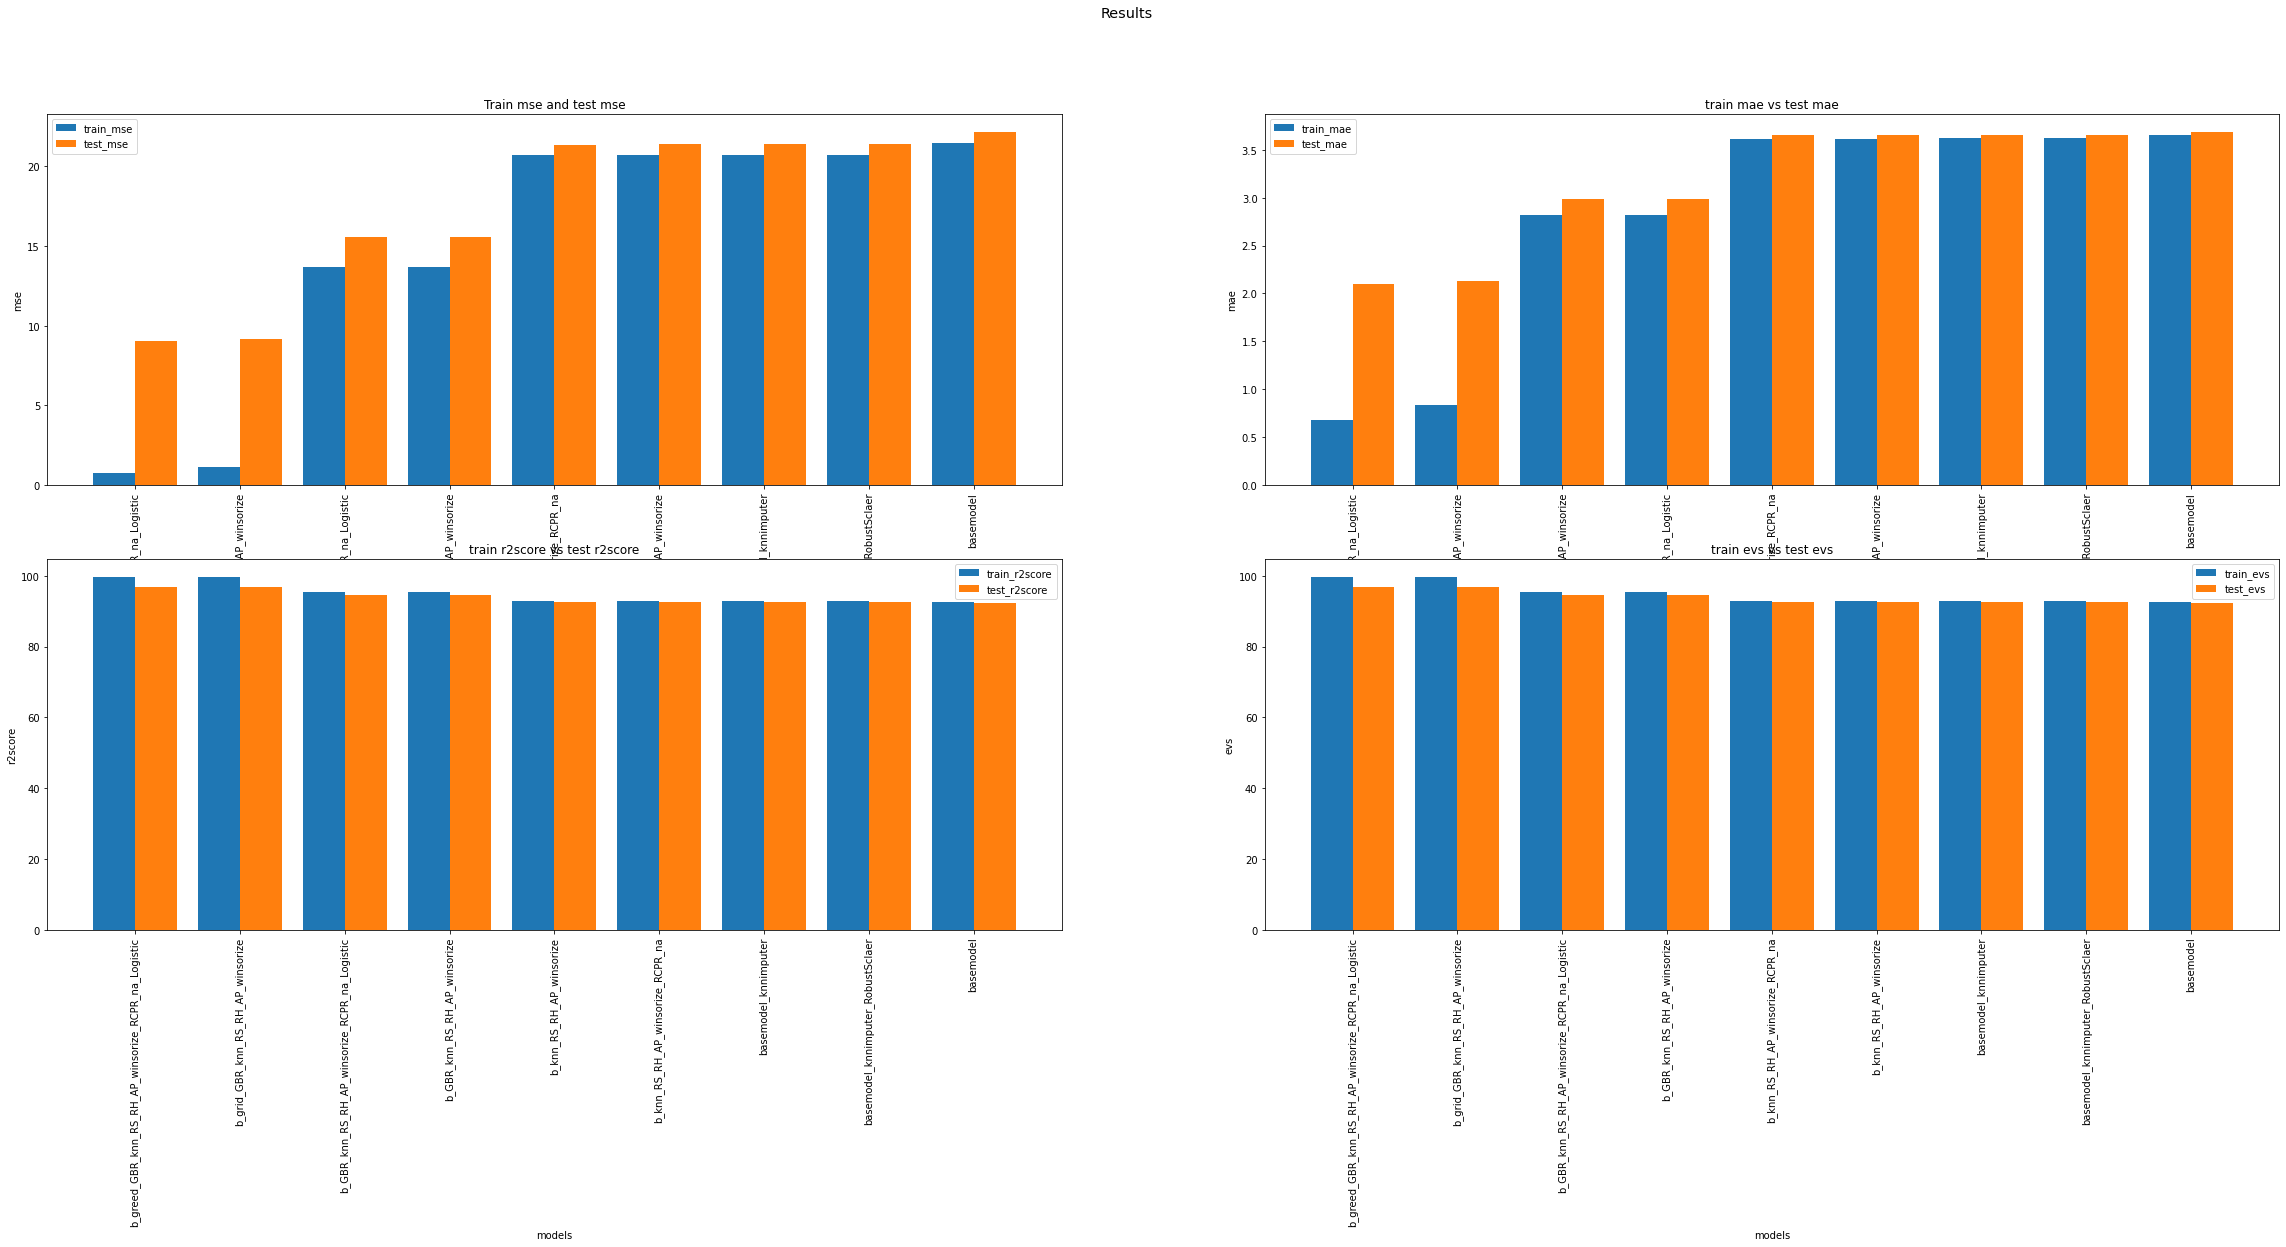

In [ ]:
show_results()

#Conclusion

Grid search along with variable normalization has improved model performance, but led to overfitting. 

The optimal preprocessing methods along with algorythm are:

- optimal imputer: KNN Imputer
- optimal scaler: RobustScaler
- optimal regressor: GradientBoostRegressor
- preprocesss data combination: outliers treatment for RH and AT variables and no normalization

Overall improvements of optimal model in comparison to base model are:
r2 and evs improved on >2%
mae improved on ~0.3
mse improved on ~4.5 but test_mse overfits in cmparison to train_mse on ~ 1.9



MSE 
 
 
   
 modelName 
 train_mse 
 test_mse 
 
 
 
 
 1 
 b_GBR_knn_RS_RH_AP_winsorize 
 13.712 
 15.587 
 
 
 0 
 basemodel 
 21.448 
 22.164 
 
 
 
____

 
 MAE 
 
 
   
 modelName 
 train_mae 
 test_mae 
 
 
 
 
 1 
 b_GBR_knn_RS_RH_AP_winsorize 
 2.815 
 2.991 
 
 
 0 
 basemodel 
 3.659 
 3.687 
 
 
 
____
 
 r2score 
 
 
   
 modelName 
 train_r2score 
 test_r2score 
 
 
 
 
 1 
 b_GBR_knn_RS_RH_AP_winsorize 
 95.279 
 94.683 
 
 
 0 
 basemodel 
 92.615 
 92.440 
 
 
 
____
 
 EVS 
 
 
   
 modelName 
 train_evs 
 test_evs 
 
 
 
 
 1 
 b_GBR_knn_RS_RH_AP_winsorize 
 95.279 
 94.683 
 
 
 0 
 basemodel 
 92.615 
 92.441

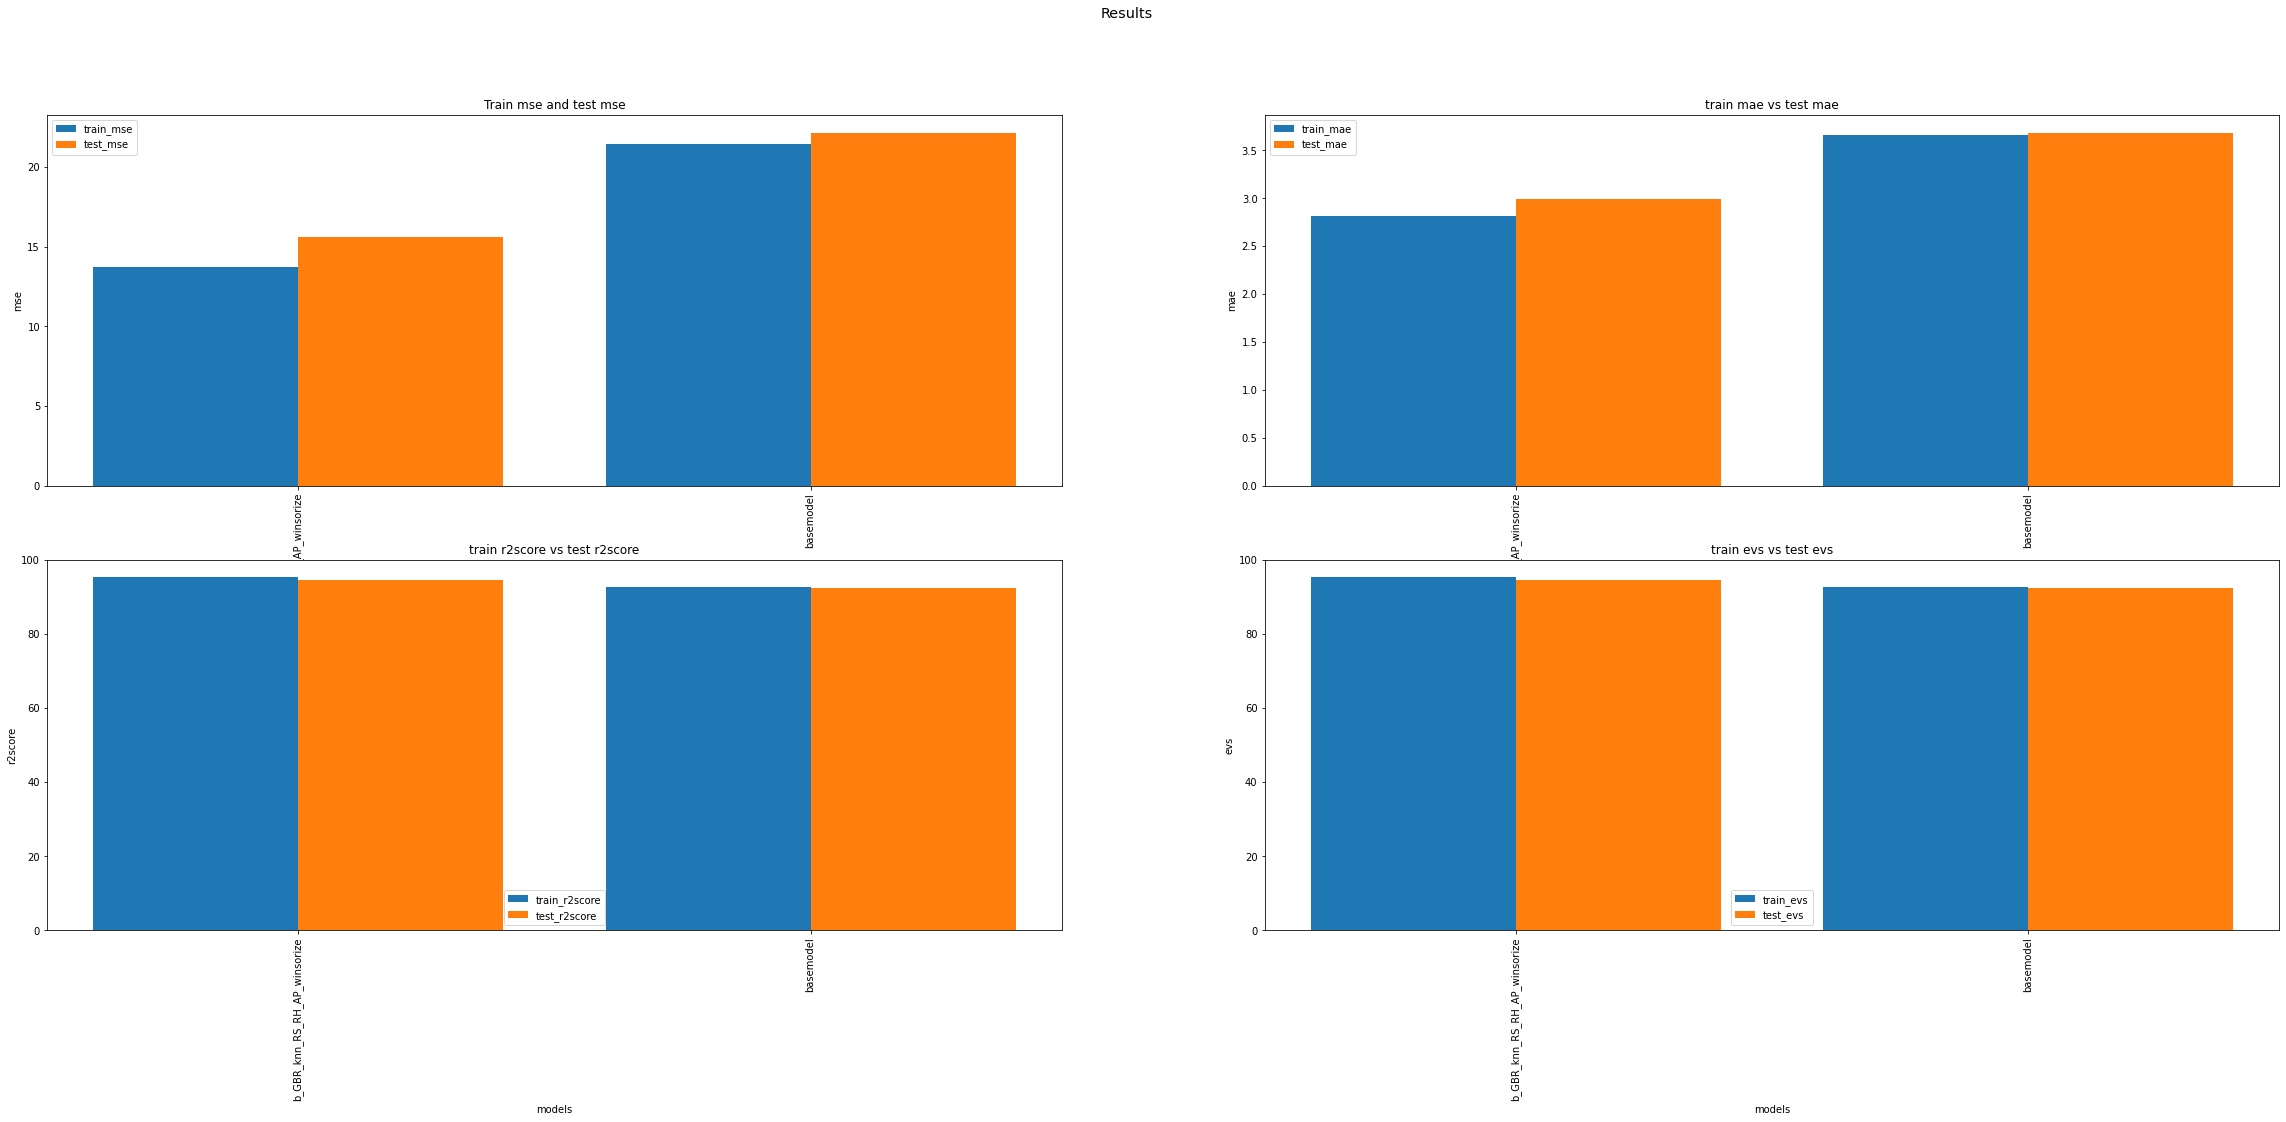

In [ ]:
show_results()